# Imports

In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2_contingency, ks_2samp
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load Data and Preprocessing

In [79]:
# Load dataset
df = pd.read_excel("../data/albion_dataset_2024.8.xlsx")

# Filter rows with valid diagnosis and visits
df_cleaned = df[df['DIAGNOSIS'].notna() & (df['DIAGNOSIS'] != 2) & (df['VisitNuA'] != 999)]

# Replace 0 with 1 in IADL columns
iadl_columns = [f'IADL{i}' for i in range(1, 9)]
df_cleaned[iadl_columns] = df_cleaned[iadl_columns].replace(0, 1)

# Function to map CDR values
def map_values(val):
    mapping = {0.0: 0, 0.5: 1, 1.0: 2, 1.5: 3, 2.0: 3, 3.0: 4, 999.0: 999}
    return mapping.get(val, val)

# Apply mapping function to CDR columns
cdr_columns = [f'CDR{i}' for i in range(1, 7)]
df_cleaned[cdr_columns] = df_cleaned[cdr_columns].applymap(map_values)

# Rename column (error)
if 'UODRS3e' in df_cleaned.columns:
    df_cleaned.rename(columns={'UODRS3e': 'UPDRS3e'}, inplace=True)

# Replace invalid values with valid values from other visits
def replace_invalid(group, column):
    valid_values = group[(group[column] != 999) & (~group[column].isna())][column]
    if not valid_values.empty:
        valid_value = valid_values.iloc[0]
        group[column] = group[column].replace(999, valid_value).fillna(valid_value)
    return group

# Apply replacement for MH and FH features
mh_features = [f'MH{i}' for i in range(1, 23)]
fh_features = [f'FH{i}' for i in range(1, 17)]
all_features = mh_features + fh_features
for feature in all_features:
    df_cleaned = df_cleaned.groupby('ID').apply(lambda group: replace_invalid(group, feature)).reset_index(drop=True)

# Last Observation Carried Forward for Marital Status and Living Arrangement
df_cleaned['ΜaritalC'] = df_cleaned.groupby('ID')['ΜaritalC'].fillna(method='ffill')
df_cleaned['Living_Arrangement'] = df_cleaned.groupby('ID')['Living_Arrangement'].fillna(method='ffill')

# Filter for third visit and reset index
df_cleaned = df_cleaned[df_cleaned['VisitNuA'] == 3].reset_index(drop=True)

# List of columns to select
columns = [
    "ID", "SEX", "EDU", "AgeC", "ΜaritalC", 
    "Living_Arrangement", "WorkStat", "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", 
    "MH8", "MH9", "MH10", "MH11", "MH12", "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", 
    "MH20", "MH21", "MH22", "SMOKING", "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", 
    "MED7", "MED8", "MED9", "MED10", "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", 
    "MED18", "MED19", "MED20", "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "NPI_TOT", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "CDR_TOT", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8", "IADL_TOT", "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "HACH_TOT", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14", "UPDRS_TOT", "MMSE", "ZME", "ZEX", 
    "ZVS", "ZLA", "ZAS"
]

diagnosis_list = [
    "DIAGNOSIS"
]

hads_list = ["HADS_A1", "HADS_D1", "HADS_A2", "HADS_D2", "HADS_A3", "HADS_D3", "HADS_A4", "HADS_D4", "HADS_A5", "HADS_D5", "HADS_A6", "HADS_D6", "HADS_A7", "HADS_D7"]

sleep_list = [
    'H1', 'H2a', 'H2b', 'H3', 'H4', 'H5',
    'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12'
]

leisure_list = [
    "E1a", "E2a", "E3a", "E4a", "E5a", "E6a", "E7a", "E8a", "E9a", "E10a",
    "E11a", "E12a", "E13a", "E14a", "E15a", "E16a", "E17a", "E18a", "E19a",
    "E20a", "E21a", "E22a", "E23a"
]

scc_list = [
    "SCC1", "SCC2", "SCC3", "SCC4", "SCC5", "SCC6", "SCC7", "SCC8", "SCC9",
    "SCC10", "SCC11", "SCC12", "SCC13", "SCC14", "SCC15"
]

anthropometrics_list = ['SPEED_1', 'SPEED_2', 'GRIP_1', 'GRIP_2', 'GRIP_3', 'WeightC', 'HeightC', 'W2', 'W3', 'W4', 'W5']

csf_list = ['CSF_AB4', 'CSF_T4', 'CSF_PHT4', 'AMYLOID_NOMINAL', 'TAU_NOMINAL', 'PHTAU_NOMINAL', 'ATN_classification']

nutrient_list = [
    "MD_total"
]

watchpat_list = [
    "Pacemaker",
    "pRDI", "pAHI", "pAHICentral", "ODI", "PERC_DeepSleep", "PERC_LightSleep",
    "PERC_REM", "REMRDI", "REMAHI", "REMAHICentral", "REMODI", "NREMRDI",
    "NREMAHI", "NREMAHICentral", "NREMODI", "PERC_CSR", "RDITotalEventsNum",
    "AHITotalEventsNum", "AHICentralTotalEventsNum", "MeanSaturation",
    "MinSaturation", "MaxSaturation", "MeanREMSaturation", "MinREMSaturation",
    "MaxREMSaturation", "MeanNREMSaturation", "MinNREMSaturation",
    "MaxNREMSaturation", "MeanofDesaturationNadirs", "TotalNumberofDesaturations",
    "SatBelow90", "SatBelowEqual88", "SatBelow88", "SatBelow85", "SatBelow80",
    "SatBelow70", "MeanPulserate", "MinPulserate", "MaxPulserate", 
    "perc_SleepInProne", "pRDIInProne", "pAHIInProne", "ODIInProne", 
    "perc_SleepInSupine", "pRDIInSupine", "pAHIInSupine", "ODIInSupine", 
    "perc_SleepInLeft", "pRDIInLeft", "pAHIInLeft", "ODIInLeft", 
    "perc_SleepInRight", "pRDIInRight", "pAHIInRight", "ODIInRight", 
    "perc_SleepInNonSupine", "pRDIInNonSupine", "pAHIInNonSupine", "ODIInNonSupine",
    "MeanSnoreDB", "SnoreThreshold", "perc_SleepOverThreshold",
     "perc_SleepOver40_A",  "perc_SleepOver50_A",
     "perc_SleepOver60_A", "perc_SleepOver70_A",
     "perc_SleepOver80_A", "SleepLatencymin", "REMpLatencymin",
    "PERC_SleepEfficiency", "NumberOfWakes"
]

all_columns = columns + diagnosis_list + hads_list + sleep_list + leisure_list + scc_list + anthropometrics_list + csf_list + nutrient_list + watchpat_list

df_cleaned = df_cleaned[all_columns]

# Replace specific values in columns (error)
df_cleaned['EDU'] = df_cleaned['EDU'].replace(999, 0)
df_cleaned['E7a'] = df_cleaned['E7a'].replace(44, 4)

# Replace values in leisure and sleep features
filtered_sleep_list = [f"H{i}" for i in range(1, 13) if i not in [2]]

for feature in leisure_list:
    df_cleaned[feature] = df_cleaned[feature].replace(9, 99)
for feature in filtered_sleep_list:
    df_cleaned[feature] = df_cleaned[feature].replace(9, 99)

# Replace values in SCC features (error)
scc_replacements = {
    'SCC4': {3: 1},
    'SCC11': {10: 1},
    'SCC12': {2: 1, 14: 1},
    'SCC15': {9: 1}
}
for column, replacements in scc_replacements.items():
    df_cleaned[column] = df_cleaned[column].replace(replacements)

# Replace 999 with NaN
df_cleaned.replace(999, np.nan, inplace=True)

# Drop columns with excessive missing values
missing_percentage = df_cleaned.isnull().mean() * 100
columns_to_keep = missing_percentage[missing_percentage <= 30].index
df_cleaned = df_cleaned[columns_to_keep]

# Remove rows with excessive missing values per group (ID + VisitNuA)
total_columns = df_cleaned.drop(columns=["ID", "VisitNuA"], errors="ignore").shape[1]
thresh_value = 0.3 * total_columns

group_missing = df_cleaned.groupby(['ID']).apply(lambda x: x.isnull().sum().sum())
to_drop = group_missing[group_missing > thresh_value].index
df_cleaned = df_cleaned[~df_cleaned.set_index(['ID']).index.isin(to_drop)].reset_index(drop=True)

# Group by 'ID' and sum missing values across the features in 'mh_med_fh'
mh_med_fh = [
    "MH1", "MH2", "MH3", "MH4", "MH5", "MH6", "MH7", "MH8", "MH9", "MH10", "MH11", "MH12", 
    "MH13", "MH14", "MH15", "MH16", "MH17", "MH18", "MH19", "MH20", "MH21", "MH22", "SMOKING", 
    "ALCOHOL", "MED1", "MED2", "MED3", "MED4", "MED5", "MED6", "MED7", "MED8", "MED9", "MED10", 
    "MED11", "MED12", "MED13", "MED14", "MED15", "MED16", "MED17", "MED18", "MED19", "MED20", 
    "MED21", "MED22", "MED23", "MED24", "MED25", "MED26", "FH5", "FH6", "FH7", "FH8", "FH9", 
    "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", "FH16"
]

missing_values_per_id = df_cleaned.groupby('ID')[mh_med_fh].apply(lambda x: x.isnull().sum().sum())

# Calculate the threshold for missing values (30% of the number of features)
thresh_mh_med_fh = 0.3 * len(mh_med_fh)

# Identify rows where the total missing values exceed the threshold
rows_to_drop = missing_values_per_id[missing_values_per_id > thresh_mh_med_fh].index
df_cleaned = df_cleaned[~df_cleaned['ID'].isin(rows_to_drop)]

# Handle specific corrections (error)
df_cleaned.loc[df_cleaned['HeightC'] < 120, 'HeightC'] *= 100
df_cleaned.loc[df_cleaned['ID'] == 6712, 'HeightC'] = np.nan
df_cleaned.loc[df_cleaned['ID'] == 6761, 'HeightC'] = np.nan
df_cleaned.loc[df_cleaned['ID'] == 6762, 'HeightC'] = np.nan
df_cleaned.loc[df_cleaned['ID'] == 6987, 'HeightC'] = np.nan

# Drop unnecessary columns
drop_columns = ['Pacemaker', 'SatBelow88', 'W2', 'W3', 'W4', 'W5']
df_cleaned.drop(columns=[col for col in drop_columns if col in df_cleaned.columns], inplace=True)

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/2493972577.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('ID').apply(lambda group, f=feature: replace_invalid(group, f)).reset_index(drop=True)
/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/2493972577.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_cleaned = df_cleaned.groupby('

# Traind and Test Split

In [135]:
# Dataframe is saved for our train test split approach. This dataset is used in the notebook: Data Preparation - Voting-Based Hybrid Model - 1st Visit.ipynb
# df_cleaned[['ID', 'DIAGNOSIS']].to_csv('../data/thirdvisit_traintestsplit_helper.csv', index=False)

In [136]:
# Train and test IDs from previous step
train_ids = [8409, 7737, 7333, 6761, 6385, 7851, 6389, 8537, 6961, 7267, 8430,
       8456, 8494, 7879, 7126, 8016, 6105, 6762, 6130, 6060, 7150, 6402,
       8514, 6949, 7690, 6162, 6253, 8244, 6053, 6869, 8177, 6519, 7889,
       8408, 8219, 6153, 6284, 6269, 7555, 6466, 6322, 8545, 6486, 6520,
       6615, 6669, 8491, 8096, 6172, 6072, 6610, 6609, 6661, 7823, 6446,
       6087, 8280, 7653, 7433, 5936, 7982, 5564, 8263, 7731, 5508, 6906,
       6697, 5902, 6979, 6498, 6051, 8457, 7481, 6256, 6533, 7712, 6369,
       6683, 7019, 6784, 4393, 8470, 6604, 6306, 6212, 7188, 6287, 7376,
       6444, 6709, 8115, 6634, 7902, 6653, 7532, 8330, 8348, 7241, 5992,
       6058, 6313, 6622, 6074, 6394, 6731, 6878, 8035, 6337, 6276, 6393,
       7075, 6617, 8351, 6970, 6879, 8528, 8040, 8258, 8519, 6371, 6090,
       6608, 7142, 8118, 6093, 7813, 6435, 8154, 6312, 6478, 6525, 7281,
       6195, 5954, 6317, 7811, 6210, 7160, 8058, 6626, 6042, 6480, 6440,
       5419, 8262, 7151, 5369, 8081, 6712, 7634, 7945, 6627, 6410, 8385,
       7084, 8554, 6569, 8477, 6171, 8547, 8090, 6675, 6113, 6549, 8490,
       5455, 7104, 7235, 7051, 6876, 6268, 8259, 8026, 6155, 8564, 8233,
       7200, 8123, 6524, 6531, 6529, 6127, 7412, 6750, 8024, 6969, 8266,
       6333, 6375]
test_ids = [6568, 6490, 6991, 7063, 7826, 6779, 6999, 8097, 6589, 6548, 6208,
       8114, 7076, 7039, 7965, 6621, 7073, 7068, 6721, 6050, 8059, 6690,
       7193, 7619, 6521, 8400, 7315, 6377, 6693, 8212, 6164, 7323, 8373,
       6199, 8489, 6600, 6103, 6987, 6413, 6564, 5111, 6416, 7912, 8575,
       8471, 7800, 6226, 8502]

# Assign rows to train or test set based on IDs
train_df = df_cleaned[df_cleaned['ID'].isin(train_ids)].copy()
test_df = df_cleaned[df_cleaned['ID'].isin(test_ids)].copy()

# Reset indexes
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Verify no overlap
overlapping_ids = set(train_df['ID']).intersection(set(test_df['ID']))
if overlapping_ids:
    print(f"Overlapping IDs found: {overlapping_ids}")
else:
    print("No overlapping IDs. Train and test sets are correctly split!")

# Verify distribution
print("\nTrain DIAGNOSIS distribution:")
print(train_df['DIAGNOSIS'].value_counts(normalize=True))
print("\nTest DIAGNOSIS distribution:")
print(test_df['DIAGNOSIS'].value_counts(normalize=True))

No overlapping IDs. Train and test sets are correctly split!

Train DIAGNOSIS distribution:
DIAGNOSIS
0.0    0.794521
1.0    0.205479
Name: proportion, dtype: float64

Test DIAGNOSIS distribution:
DIAGNOSIS
0.0    0.833333
1.0    0.166667
Name: proportion, dtype: float64


In [142]:
# Save as baseline datasets
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()
original_stats_train = train_df.describe()
original_stats_test = test_df.describe()

# MICE Imputation

In [143]:
def perform_imputation_and_analysis(train_df, test_df, target_column, impute_columns, n_imputations=10):
    # Step 1: Encode categorical variables as needed for imputation
    train_df_encoded = train_df.copy()
    test_df_encoded = test_df.copy()

    # Replace special missing values in the target column for training and test sets
    for df_encoded in [train_df_encoded, test_df_encoded]:
        if target_column.startswith('IADL'):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        elif target_column.startswith(('CSF_AB4', 'CSF_T4', 'CSF_PHT4')):
            df_encoded[target_column].replace(-1000, np.nan, inplace=True)
        elif target_column.startswith('SCC'):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        elif target_column.startswith(('E1a',  'E2a',  'E3a',  'E4a',  'E5a',  'E6a',  'E7a',  'E8a',  'E9a',  'E10a',  'E11a',  'E12a',  'E13a',  'E14a',  'E15a',  'E16a',  'E17a',  'E18a',  'E19a',  'E20a',  'E21a',  'E22a',  'E23a')):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        elif target_column.startswith(('H1',  'H2a',  'H2b',  'H3',  'H4',  'H5',  'H6',  'H7',  'H8',  'H9',  'H10',  'H11',  'H12')):
            df_encoded[target_column].replace(99, np.nan, inplace=True)
        else:
            print(f"No special replacements for {target_column}, continuing...")

    # Add the target column to the list of impute columns
    if target_column not in impute_columns:
        impute_columns.append(target_column)

    # Select relevant columns for imputation
    impute_train_df = train_df_encoded[impute_columns]
    impute_test_df = test_df_encoded[impute_columns]

    # Step 2: Perform multiple imputations with added noise on the training data
    imputed_train_datasets = []
    for i in range(n_imputations):
        imputer = IterativeImputer(max_iter=10, random_state=i*4, sample_posterior=True)
        imputed_train_data = imputer.fit_transform(impute_train_df)

        # Add small random noise to the imputed values
        noise = np.random.normal(0, 0.2, imputed_train_data.shape)
        imputed_train_data += noise

        imputed_train_df = pd.DataFrame(imputed_train_data, columns=impute_train_df.columns)
        imputed_train_datasets.append(imputed_train_df)

    # Apply the imputation model from the training data to the test set
    imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
    imputed_test_data = imputer.fit(impute_train_df).transform(impute_test_df)

    # Step 3: Clip and round imputed values for both train and test sets
    for df, imputed_datasets in [(train_df, imputed_train_datasets), (test_df, [pd.DataFrame(imputed_test_data, columns=impute_test_df.columns)])]:
        # Identify NaNs in the target column of the original dataset
        nan_indices = df.index[df[target_column].isna()].tolist()

        # Collect imputed values for NaNs and calculate the mean of the imputed values for each NaN
        imputed_values = []
        for imputed_df in imputed_datasets:
            imputed_values.append(imputed_df.loc[nan_indices, target_column])
        imputed_values_df = pd.DataFrame(imputed_values).transpose()
        imputed_means = imputed_values_df.mean(axis=1).round()

        # Clip imputed values within the original column's min and max values
        min_value = df[target_column].min()
        max_value = df[target_column].max()
        imputed_means = imputed_means.clip(lower=min_value, upper=max_value)

        # Replace negative zeros with positive zeros
        imputed_means[imputed_means == -0] = 0

        # Save original values before imputation
        original_values = df.copy()
        
        print(f"Imputed Values for {target_column} in {'training' if df is train_df else 'test'} set:")
        print(imputed_means)

        # Replace NaNs in the original dataset with the imputed values
        df.loc[nan_indices, target_column] = imputed_means

    # Perform analysis on the imputed training data
    results = []
    for imputed_train_df in imputed_train_datasets:
        X = imputed_train_df.drop(columns=[target_column])
        y = imputed_train_df[target_column]
        model = LinearRegression()
        model.fit(X, y)
        results.append(model.coef_)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Pooling Phase Using Rubin's Rules
    mean_coefficients = results_df.mean(axis=0)
    within_var = results_df.var(axis=0, ddof=1)
    between_var = results_df.mean(axis=0).var(ddof=1)
    total_var = within_var + (1 + 1 / n_imputations) * between_var
    se = np.sqrt(total_var)

    pooled_results = pd.DataFrame({
        'Coefficient': mean_coefficients,
        'Standard Error': se
    })

    return train_df, test_df, pooled_results

In [144]:
def perform_imputation_and_analysis_unrounded(train_df, test_df, target_column, impute_columns, n_imputations=10):
    # Step 1: Encode categorical variables as needed for imputation
    train_df_encoded = train_df.copy()
    test_df_encoded = test_df.copy()

    # Add the target column to the list of impute columns
    if target_column not in impute_columns:
        impute_columns.append(target_column)

    # Select relevant columns for imputation
    impute_train_df = train_df_encoded[impute_columns]
    impute_test_df = test_df_encoded[impute_columns]

    # Step 2: Perform multiple imputations with added noise on the training data
    imputed_train_datasets = []
    for i in range(n_imputations):
        imputer = IterativeImputer(max_iter=10, random_state=i*4, sample_posterior=True)
        imputed_train_data = imputer.fit_transform(impute_train_df)

        # Add small random noise to the imputed values
        noise = np.random.normal(0, 0.2, imputed_train_data.shape)
        imputed_train_data += noise

        imputed_train_df = pd.DataFrame(imputed_train_data, columns=impute_train_df.columns)
        imputed_train_datasets.append(imputed_train_df)

    # Apply the imputation model from the training data to the test set
    imputer = IterativeImputer(max_iter=10, random_state=0, sample_posterior=True)
    imputed_test_data = imputer.fit(impute_train_df).transform(impute_test_df)

    # Step 3: Clip and round imputed values for both train and test sets
    for df, imputed_datasets in [(train_df, imputed_train_datasets), (test_df, [pd.DataFrame(imputed_test_data, columns=impute_test_df.columns)])]:
        # Identify NaNs in the target column of the original dataset
        nan_indices = df.index[df[target_column].isna()].tolist()

        # Collect imputed values for NaNs and calculate the mean of the imputed values for each NaN
        imputed_values = []
        for imputed_df in imputed_datasets:
            imputed_values.append(imputed_df.loc[nan_indices, target_column])
        imputed_values_df = pd.DataFrame(imputed_values).transpose()
        imputed_means = imputed_values_df.mean(axis=1)

        # Clip imputed values within the original column's min and max values
        min_value = df[target_column].min()
        max_value = df[target_column].max()
        imputed_means = imputed_means.clip(lower=min_value, upper=max_value)

        # Replace negative zeros with positive zeros
        imputed_means[imputed_means == -0] = 0

        # Save original values before imputation
        original_values = df.copy()
        
        print(f"Imputed Values for {target_column} in {'training' if df is train_df else 'test'} set:")
        print(imputed_means)

        # Replace NaNs in the original dataset with the imputed values
        df.loc[nan_indices, target_column] = imputed_means

    # Perform analysis on the imputed training data
    results = []
    for imputed_train_df in imputed_train_datasets:
        X = imputed_train_df.drop(columns=[target_column])
        y = imputed_train_df[target_column]
        model = LinearRegression()
        model.fit(X, y)
        results.append(model.coef_)

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Pooling Phase Using Rubin's Rules
    mean_coefficients = results_df.mean(axis=0)
    within_var = results_df.var(axis=0, ddof=1)
    between_var = results_df.mean(axis=0).var(ddof=1)
    total_var = within_var + (1 + 1 / n_imputations) * between_var
    se = np.sqrt(total_var)

    pooled_results = pd.DataFrame({
        'Coefficient': mean_coefficients,
        'Standard Error': se
    })

    return train_df, test_df, pooled_results

In [145]:
def chi_square_test(feature, target):
    data = df_cleaned[[feature, target]].replace(999, np.nan).dropna()
    data = df_cleaned[[feature, target]].replace(99, np.nan).dropna()
    contingency_table = pd.crosstab(data[feature], data[target])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    return chi2, p, dof, ex

In [146]:
def process_feature(train_df, test_df, feature):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # Step 1: Calculate correlations between other variables in the training set
    correlation_matrix = train_df_copy.corr()

    # Extract correlations with the feature
    feature_corr = correlation_matrix[feature].drop(feature)

    # Filter correlations above 0.1
    significant_corr = feature_corr[feature_corr.abs() > 0.1]

    # Display significant correlations
    print(f"Significant Correlations with {feature} (|correlation| > 0.1):")
    print(significant_corr)

    # Step 2: Perform chi-square tests on significant features
    chi_square_results = {}
    for sig_feature in significant_corr.index:
        chi2, p, dof, ex = chi_square_test(sig_feature, feature)
        chi_square_results[sig_feature] = {'Chi2': chi2, 'p-value': p}

    # Display chi-square test results
    print(f"\nChi-Squared Test Results for {feature}:")
    for sig_feature, results in chi_square_results.items():
        print(f"{sig_feature}: Chi2: {results['Chi2']}, p-value: {results['p-value']}")

    # Step 3: Perform imputation and analysis on significant features
    impute_columns = significant_corr.index.tolist()

    # Check if impute_columns is empty and print a message if it is
    if not impute_columns:
        print(f"No significant correlations for {feature}. Using all columns for imputation.")
        # Exclude 'ID' from the columns list
        impute_columns = [col for col in train_df_copy.columns if col != 'ID']

    # Perform imputation on both train and test data
    train_df_copy, test_df_copy, pooled_results = perform_imputation_and_analysis(train_df_copy, test_df_copy, feature, impute_columns)

    return train_df_copy, test_df_copy, chi_square_results, pooled_results


In [147]:
def process_feature_unrounded(train_df, test_df, feature):
    train_df_copy = train_df.copy()
    test_df_copy = test_df.copy()

    # Step 1: Calculate correlations between other variables in the training set
    correlation_matrix = train_df_copy.corr()

    # Extract correlations with the feature
    feature_corr = correlation_matrix[feature].drop(feature)

    # Filter correlations above 0.1
    significant_corr = feature_corr[feature_corr.abs() > 0.1]

    # Display significant correlations
    print(f"Significant Correlations with {feature} (|correlation| > 0.1):")
    print(significant_corr)

    # Step 2: Perform chi-square tests on significant features
    chi_square_results = {}
    for sig_feature in significant_corr.index:
        chi2, p, dof, ex = chi_square_test(sig_feature, feature)
        chi_square_results[sig_feature] = {'Chi2': chi2, 'p-value': p}

    # Display chi-square test results
    print(f"\nChi-Squared Test Results for {feature}:")
    for sig_feature, results in chi_square_results.items():
        print(f"{sig_feature}: Chi2: {results['Chi2']}, p-value: {results['p-value']}")

    # Step 3: Perform imputation and analysis on significant features
    impute_columns = significant_corr.index.tolist()

    # Check if impute_columns is empty and print a message if it is
    if not impute_columns:
        print(f"No significant correlations for {feature}. Using all columns for imputation.")
        # Exclude 'ID' from the columns list
        impute_columns = [col for col in train_df_copy.columns if col != 'ID']

    # Perform imputation on both train and test data
    train_df_copy, test_df_copy, pooled_results = perform_imputation_and_analysis_unrounded(train_df_copy, test_df_copy, feature, impute_columns)

    return train_df_copy, test_df_copy, chi_square_results, pooled_results


# Imputation

In [149]:
# List of target columns to impute
target_columns = ["Living_Arrangement","WorkStat", "ΜaritalC", "FH5", "FH6", "FH7", "FH8", "FH9", "FH10", "FH11", "FH12", "FH13", "FH14", "FH15", 
    "FH16", "NPI1", "NPI2", "NPI3", "NPI4", "NPI5", "NPI6", "NPI7", "NPI8", "NPI9", "NPI10", "NPI11", 
    "NPI12", "CDR1", "CDR2", "CDR3", "CDR4", "CDR5", "CDR6", "IADL1", "IADL2", 
    "IADL3", "IADL4", "IADL5", "IADL6", "IADL7", "IADL8" , "HACH1", "HACH2", "HACH3", "HACH4", 
    "HACH5", "HACH6", "HACH7", "HACH8", "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", 
    "UPDRS3d", "UPDRS3e", "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e", 
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b", "UPDRS10", 
    "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14", "HADS_A1", "HADS_D1", "HADS_A2", "HADS_D2", "HADS_A3", "HADS_D3", "HADS_A4", "HADS_D4", "HADS_A5", "HADS_D5", "HADS_A6", "HADS_D6", "HADS_A7", "HADS_D7", 
    "H2a", "H2b", "H3", "H4", "H5", "H6", "H7", "H8", "H9", "H10", "H11", "H12","E11a", "E15a","E16a", "E17a","E18a", "E19a", "E20a", "E21a", "E22a", "E23a","SCC1","SCC2", "SCC3", "SCC4", "SCC5","SCC6","SCC7", "SCC8","SCC9","SCC10", "SCC11","SCC12","SCC13","SCC14","SCC15" ]

for feature in target_columns:
    train_df_copy2, test_df_copy2, chi_square_results, pooled_results = process_feature(train_df_copy, test_df_copy, feature)

    # Update the original train and test data with the imputed feature
    train_df[feature] = train_df_copy2[feature]
    test_df[feature] = test_df_copy2[feature]

    # Optionally: Save or log the results if needed
    print(f"Finished processing {feature}\n")


Significant Correlations with Living_Arrangement (|correlation| > 0.1):
ID           0.155973
SEX         -0.287927
AgeC        -0.116120
ΜaritalC    -0.415377
WorkStat    -0.119174
MH2         -0.240425
MH9         -0.168953
MH12        -0.107238
MH22        -0.136913
MED3        -0.189435
MED12       -0.235681
MED13       -0.201646
MED21       -0.184332
MED23        0.214061
FH9          0.116927
CDR1        -0.141598
CDR3        -0.109824
CDR4        -0.205360
CDR_TOT     -0.182888
IADL5        0.210092
IADL6       -0.109824
IADL_TOT    -0.167751
HACH2       -0.196193
HACH5       -0.124883
HACH_TOT    -0.162754
UPDRS1      -0.206349
UPDRS2      -0.206349
UPDRS5c     -0.206829
UPDRS6b     -0.199574
UPDRS10     -0.199574
UPDRS12     -0.199574
UPDRS_TOT   -0.219845
ZAS          0.200877
HADS_A1     -0.291046
HADS_D2      0.235411
HADS_A4      0.275855
HADS_A5     -0.199356
HADS_D5     -0.222825
HADS_A7     -0.268379
H2a          0.112945
H5           0.235092
E1a         -0.159251
E3a 

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL1 in training set:
8     1.0
39    1.0
49    1.0
dtype: float64
Imputed Values for IADL1 in test set:
8     1.0
14    1.0
15    1.0
dtype: float64
Finished processing IADL1

Significant Correlations with IADL2 (|correlation| > 0.1):
Series([], Name: IADL2, dtype: float64)

Chi-Squared Test Results for IADL2:
No significant correlations for IADL2. Using all columns for imputation.


/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL2 in training set:
8     1.0
39    1.0
49    1.0
dtype: float64
Imputed Values for IADL2 in test set:
8     1.0
14    1.0
15    1.0
dtype: float64
Finished processing IADL2

Significant Correlations with IADL3 (|correlation| > 0.1):
ID          -0.293989
SEX         -0.396874
AgeC         0.194859
ΜaritalC    -0.188484
MH7          0.209550
MH8          0.144355
MH20         0.269841
MH22        -0.119523
SMOKING     -0.102547
MED5         0.112136
MED7         0.129799
MED8         0.186420
MED11        0.228702
MED18        0.407374
MED23        0.186420
FH14         0.165912
FH15         0.111009
NPI9         0.334867
NPI11        0.126230
NPI_TOT      0.107817
CDR1         0.400013
CDR3         0.559581
CDR4         0.438120
CDR_TOT      0.537322
IADL4        0.817423
IADL5        0.748087
IADL6        0.253266
IADL8        0.392953
IADL_TOT    -0.854579
HACH5        0.228702
HACH_TOT     0.207635
UPDRS1       0.432784
UPDRS2       0.432784
UPDRS5c      0.432

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL3 in training set:
7     1.0
8     1.0
39    1.0
49    1.0
dtype: float64
Imputed Values for IADL3 in test set:
8     1.0
14    1.0
15    1.0
dtype: float64
Finished processing IADL3

Significant Correlations with IADL4 (|correlation| > 0.1):
ID          -0.218182
SEX         -0.396527
ΜaritalC    -0.187459
MH7          0.209391
MH21         0.101148
MH22        -0.118186
SMOKING     -0.101857
MED5         0.114031
MED7         0.129578
MED8         0.186336
MED11        0.126145
MED18        0.236877
MED23        0.186336
FH14         0.165621
FH15         0.110877
NPI9         0.334831
NPI11        0.126098
NPI_TOT      0.109845
CDR1         0.401218
CDR3         0.559576
CDR4         0.440651
CDR_TOT      0.538882
IADL3        0.817423
IADL5        0.748024
IADL6        0.256343
IADL8        0.392949
IADL_TOT    -0.790473
HACH5        0.126145
HACH_TOT     0.110709
UPDRS1       0.391709
UPDRS2       0.391709
UPDRS5c      0.391709
UPDRS6b      0.391973
UPDRS9b 

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL4 in training set:
7     1.0
8     1.0
39    1.0
49    1.0
dtype: float64
Imputed Values for IADL4 in test set:
8     2.0
14    1.0
15    2.0
dtype: float64
Finished processing IADL4

Significant Correlations with IADL5 (|correlation| > 0.1):
ID                   -0.102215
SEX                  -0.432116
AgeC                  0.157715
ΜaritalC             -0.137497
Living_Arrangement    0.210092
MH2                  -0.154172
MH20                  0.237018
MH22                 -0.130136
SMOKING              -0.138497
MED9                 -0.138333
MED10                -0.103695
MED18                 0.523041
MED23                 0.399125
MED25                -0.103695
FH9                  -0.105381
NPI9                  0.304313
NPI11                 0.103911
CDR1                  0.350961
CDR3                  0.227454
CDR4                  0.162880
CDR_TOT               0.327920
IADL3                 0.748087
IADL4                 0.748024
IADL6                

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL5 in training set:
7     1.0
8     1.0
39    1.0
49    1.0
dtype: float64
Imputed Values for IADL5 in test set:
8     1.0
14    1.0
15    1.0
dtype: float64
Finished processing IADL5

Significant Correlations with IADL6 (|correlation| > 0.1):
ΜaritalC              0.139068
Living_Arrangement   -0.109824
WorkStat              0.149252
MH20                  0.228665
MH21                  0.128624
MH22                  0.190304
SMOKING               0.231751
MED4                  0.230089
MED5                  0.618347
MED7                  0.149515
MED11                 0.181595
MED12                 0.223100
MED18                 0.207914
FH8                   0.109762
FH14                 -0.102643
FH15                  0.284921
NPI4                  0.537433
NPI5                  0.232465
NPI9                  0.621603
NPI_TOT               0.471039
CDR1                  0.358591
CDR3                  0.485075
CDR4                  0.810380
CDR_TOT              

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL6 in training set:
8     1.0
39    1.0
49    1.0
dtype: float64
Imputed Values for IADL6 in test set:
8     1.0
14    1.0
15    1.0
dtype: float64
Finished processing IADL6

Significant Correlations with IADL7 (|correlation| > 0.1):
Series([], Name: IADL7, dtype: float64)

Chi-Squared Test Results for IADL7:
No significant correlations for IADL7. Using all columns for imputation.


/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL7 in training set:
8     1.0
39    1.0
49    1.0
dtype: float64
Imputed Values for IADL7 in test set:
8     1.0
14    1.0
15    1.0
dtype: float64
Finished processing IADL7

Significant Correlations with IADL8 (|correlation| > 0.1):
ID          -0.128063
SEX         -0.151924
AgeC         0.109098
WorkStat     0.104747
MH8         -0.107331
SMOKING      0.162681
MED4         0.161515
MED5         0.434057
MED7         0.264666
MED11        0.127473
MED12        0.156608
MED18        0.335140
FH8          0.220711
FH15         0.433861
NPI4         0.237269
NPI9         0.893060
NPI_TOT      0.197900
CDR1         0.251691
CDR3         0.701888
CDR4         0.568796
CDR_TOT      0.528040
IADL3        0.392953
IADL4        0.392949
IADL5        0.360905
IADL6        0.701964
IADL_TOT    -0.100007
HACH5        0.127473
HACH_TOT     0.117347
UPDRS9b      1.000000
UPDRS_TOT    0.145519
MMSE        -0.120218
ZAS         -0.171435
HADS_A1     -0.110396
HADS_D7      0.119

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for IADL8 in training set:
8     1.0
39    1.0
49    1.0
dtype: float64
Imputed Values for IADL8 in test set:
8     1.0
14    1.0
15    1.0
dtype: float64
Finished processing IADL8

Significant Correlations with HACH1 (|correlation| > 0.1):
Series([], Name: HACH1, dtype: float64)

Chi-Squared Test Results for HACH1:
No significant correlations for HACH1. Using all columns for imputation.
No special replacements for HACH1, continuing...
No special replacements for HACH1, continuing...
Imputed Values for HACH1 in training set:
8     0.0
39    0.0
49    0.0
dtype: float64
Imputed Values for HACH1 in test set:
8     0.0
14    0.0
15    0.0
dtype: float64
Finished processing HACH1

Significant Correlations with HACH2 (|correlation| > 0.1):
ID                   -0.233570
EDU                  -0.137956
AgeC                  0.135523
ΜaritalC              0.244026
Living_Arrangement   -0.196193
WorkStat              0.104747
MH2                   0.264666
MH8                   0

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H2a in training set:
41    8.0
dtype: float64
Imputed Values for H2a in test set:
Series([], dtype: float64)
Finished processing H2a

Significant Correlations with H2b (|correlation| > 0.1):
ID         -0.255815
EDU        -0.152680
AgeC        0.123927
WorkStat    0.134583
MH2         0.111966
MH4         0.191363
MH5        -0.104828
MH8         0.194145
MH9         0.167726
MH10        0.191363
MH13        0.181041
MH19       -0.104828
MH21       -0.165434
SMOKING     0.322665
ALCOHOL     0.312608
MED5       -0.169419
MED6       -0.104828
MED8       -0.129315
MED9        0.109590
MED11       0.158734
MED12       0.186160
MED13       0.116024
MED18      -0.120595
MED21       0.191363
MED23      -0.129315
MED24       0.181041
MED25       0.149592
MED26       0.191363
FH15        0.194770
NPI4       -0.132482
NPI5       -0.123177
NPI9       -0.102538
NPI11       0.246737
CDR3       -0.106505
CDR4       -0.131426
IADL5      -0.103092
IADL6      -0.106505
HACH2       0

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H2b in training set:
41    0.0
dtype: float64
Imputed Values for H2b in test set:
Series([], dtype: float64)
Finished processing H2b

Significant Correlations with H3 (|correlation| > 0.1):
SEX         0.102985
AgeC       -0.162229
ΜaritalC   -0.173796
MH8        -0.129376
MH9        -0.116822
SMOKING    -0.110804
MED11      -0.137184
FH14        0.196933
HACH5      -0.143337
HACH_TOT   -0.134890
ZME         0.129262
ZLA         0.132331
ZAS        -0.102694
HADS_A1    -0.109890
HADS_A3    -0.140141
HADS_A6    -0.128476
H1          0.975392
H2a         0.182727
H2b         0.105683
H4          0.972780
H5          0.680530
H6          0.974802
H7          0.976682
H8          0.980467
H9          0.981005
H10         0.969240
H11         0.972637
H12         0.970351
E2a        -0.165903
E10a        0.226415
E16a       -0.194132
E17a       -0.180230
SCC5        0.128075
SCC10      -0.178889
SPEED_1     0.146991
GRIP_3     -0.198054
Name: H3, dtype: float64

Chi-Squar

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H3 in training set:
18    4.0
dtype: float64
Imputed Values for H3 in test set:
Series([], dtype: float64)
Finished processing H3

Significant Correlations with H4 (|correlation| > 0.1):
SEX         0.146366
AgeC       -0.196244
ΜaritalC   -0.183292
MH8        -0.105614
SMOKING    -0.106785
MED4       -0.102209
MED11      -0.110463
MED12      -0.101330
FH14        0.187672
HACH5      -0.110095
ZME         0.126704
ZLA         0.126906
ZAS        -0.117357
H1          0.983285
H2a        -0.311833
H3          0.972780
H5          0.698314
H6          0.969482
H7          0.971976
H8          0.972363
H9          0.977359
H10         0.972906
H11         0.978304
H12         0.992272
E2a        -0.109090
E10a        0.277413
E16a       -0.232786
E17a       -0.119105
SCC5        0.132848
SCC10      -0.139666
SPEED_1     0.126620
GRIP_3     -0.207885
Name: H4, dtype: float64

Chi-Squared Test Results for H4:
SEX: Chi2: 10.556423289012574, p-value: 0.10309189258178553
Age

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H4 in training set:
18    4.0
dtype: float64
Imputed Values for H4 in test set:
Series([], dtype: float64)
Finished processing H4

Significant Correlations with H5 (|correlation| > 0.1):
AgeC                 -0.128804
ΜaritalC             -0.171332
Living_Arrangement    0.235092
WorkStat             -0.124871
SMOKING              -0.144496
MED4                 -0.128491
MED7                  0.155657
MED12                -0.128655
FH14                  0.111641
NPI4                  0.148683
NPI_TOT               0.105385
ZME                   0.155072
ZLA                   0.166863
HADS_D2               0.483896
HADS_A4               0.695049
H1                    0.696353
H3                    0.680530
H4                    0.698314
H6                    0.689533
H7                    0.679998
H8                    0.696489
H9                    0.671707
H10                   0.671521
H11                   0.675409
H12                   0.705471
E2a                

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H5 in training set:
18    6.0
dtype: float64
Imputed Values for H5 in test set:
Series([], dtype: float64)
Finished processing H5

Significant Correlations with H6 (|correlation| > 0.1):
AgeC       -0.124240
ΜaritalC   -0.206151
MH8        -0.119219
MH9        -0.114059
MED11      -0.124678
FH14        0.245329
HACH5      -0.127515
HACH_TOT   -0.128298
ZME         0.134074
ZVS        -0.103134
ZLA         0.154408
ZAS        -0.107333
HADS_A1    -0.117902
HADS_A3    -0.142143
HADS_D3    -0.126057
HADS_A6    -0.102103
HADS_A7    -0.103029
H1          0.985825
H2a         0.285359
H3          0.974802
H4          0.969482
H5          0.689533
H7          0.977588
H8          0.986548
H9          0.991454
H10         0.974894
H11         0.979537
H12         0.969592
E2a        -0.148951
E10a        0.249557
E16a       -0.188504
E17a       -0.162742
SCC5        0.109947
SCC10      -0.165185
SPEED_1     0.108372
GRIP_3     -0.178430
Name: H6, dtype: float64

Chi-Squared 

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H6 in training set:
18    4.0
dtype: float64
Imputed Values for H6 in test set:
Series([], dtype: float64)
Finished processing H6

Significant Correlations with H7 (|correlation| > 0.1):
SEX         0.111102
AgeC       -0.133353
ΜaritalC   -0.171094
MH8        -0.114826
MH9        -0.102967
SMOKING    -0.130102
MED11      -0.119379
FH14        0.189944
HACH5      -0.127932
HACH_TOT   -0.121203
ZME         0.148871
ZLA         0.143868
ZAS        -0.113969
HADS_A1    -0.168122
HADS_A2    -0.133559
HADS_A3    -0.140851
HADS_D3    -0.120172
HADS_A6    -0.147206
HADS_D6    -0.125038
HADS_A7    -0.118003
H1          0.968698
H2a         0.229180
H3          0.976682
H4          0.971976
H5          0.679998
H6          0.977588
H8          0.984311
H9          0.984762
H10         0.970101
H11         0.968555
H12         0.968634
E2a        -0.100905
E10a        0.246182
E16a       -0.190684
E17a       -0.157056
E23a        0.109284
SCC5        0.110341
SCC10      -0.166

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H7 in training set:
18    5.0
dtype: float64
Imputed Values for H7 in test set:
Series([], dtype: float64)
Finished processing H7

Significant Correlations with H8 (|correlation| > 0.1):
AgeC       -0.127243
ΜaritalC   -0.197964
MH8        -0.106970
MH9        -0.113014
SMOKING    -0.127238
MED11      -0.108878
FH14        0.192873
NPI5       -0.103865
NPI_TOT    -0.107231
HACH5      -0.114755
HACH_TOT   -0.120665
ZME         0.131073
ZVS        -0.103039
ZLA         0.135352
ZAS        -0.105653
HADS_A1    -0.145138
HADS_A2    -0.115240
HADS_A3    -0.133223
HADS_A6    -0.103957
HADS_A7    -0.114302
H1          0.984551
H2a         0.358377
H2b        -0.155336
H3          0.980467
H4          0.972363
H5          0.696489
H6          0.986548
H7          0.984311
H9          0.989826
H10         0.973183
H11         0.975455
H12         0.972986
E2a        -0.135126
E10a        0.260247
E16a       -0.195771
E17a       -0.155033
SCC5        0.109394
SCC10      -0.169

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H8 in training set:
18    5.0
dtype: float64
Imputed Values for H8 in test set:
Series([], dtype: float64)
Finished processing H8

Significant Correlations with H9 (|correlation| > 0.1):
AgeC       -0.145211
ΜaritalC   -0.207614
MH8        -0.116811
MH9        -0.114141
SMOKING    -0.107412
MED4       -0.116002
MED11      -0.127413
FH14        0.197434
NPI_TOT    -0.113646
HACH5      -0.134504
HACH_TOT   -0.136420
ZME         0.119031
ZVS        -0.102267
ZLA         0.128707
ZAS        -0.113240
HADS_A1    -0.142866
HADS_A2    -0.106560
HADS_A3    -0.151963
HADS_D3    -0.117928
HADS_A6    -0.117288
HADS_A7    -0.113075
H1          0.988588
H2a         0.104275
H3          0.981005
H4          0.977359
H5          0.671707
H6          0.991454
H7          0.984762
H8          0.989826
H10         0.980522
H11         0.981994
H12         0.976986
E2a        -0.137682
E10a        0.216191
E16a       -0.178302
E17a       -0.157651
SCC5        0.116643
SCC10      -0.172

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H9 in training set:
18    6.0
dtype: float64
Imputed Values for H9 in test set:
Series([], dtype: float64)
Finished processing H9

Significant Correlations with H10 (|correlation| > 0.1):
SEX         0.104779
AgeC       -0.169553
ΜaritalC   -0.175530
MH8        -0.125769
MH9        -0.105892
MED4       -0.159232
MED11      -0.125946
MED12      -0.114892
FH14        0.170715
HACH5      -0.128260
HACH_TOT   -0.118051
ZME         0.130350
ZVS        -0.100260
ZLA         0.117403
ZAS        -0.119820
HADS_A3    -0.132318
HADS_D3    -0.110347
H1          0.979230
H2a        -0.136073
H3          0.969240
H4          0.972906
H5          0.671521
H6          0.974894
H7          0.970101
H8          0.973183
H9          0.980522
H11         0.966816
H12         0.971488
E2a        -0.109525
E10a        0.253329
E16a       -0.175012
E17a       -0.145551
SCC5        0.123742
SCC10      -0.174789
GRIP_3     -0.180822
Name: H10, dtype: float64

Chi-Squared Test Results for H1

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H10 in training set:
18    5.0
dtype: float64
Imputed Values for H10 in test set:
Series([], dtype: float64)
Finished processing H10

Significant Correlations with H11 (|correlation| > 0.1):
SEX         0.124218
AgeC       -0.198571
ΜaritalC   -0.191119
MH8        -0.118985
MED11      -0.124278
MED12      -0.101506
FH14        0.202196
HACH5      -0.124287
HACH_TOT   -0.127668
ZME         0.142609
ZLA         0.146029
HADS_A3    -0.117593
H1          0.982289
H3          0.972637
H4          0.978304
H5          0.675409
H6          0.979537
H7          0.968555
H8          0.975455
H9          0.981994
H10         0.966816
H12         0.974652
E2a        -0.105588
E10a        0.251391
E16a       -0.199869
E17a       -0.150542
SCC4       -0.114116
SCC10      -0.162848
SPEED_1     0.101690
GRIP_3     -0.187835
Name: H11, dtype: float64

Chi-Squared Test Results for H11:
SEX: Chi2: 6.911155896346512, p-value: 0.22733205956217178
AgeC: Chi2: 155.61275904203322, p-value:

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H11 in training set:
18    4.0
dtype: float64
Imputed Values for H11 in test set:
Series([], dtype: float64)
Finished processing H11

Significant Correlations with H12 (|correlation| > 0.1):
SEX         0.113129
AgeC       -0.189130
ΜaritalC   -0.208895
MH8        -0.110559
MED4       -0.113691
MED11      -0.115853
MED12      -0.105625
FH14        0.205224
HACH5      -0.118164
HACH_TOT   -0.107619
ZME         0.121486
ZVS        -0.110677
ZLA         0.121942
ZAS        -0.100556
H1          0.983551
H2a        -0.266375
H3          0.970351
H4          0.992272
H5          0.705471
H6          0.969592
H7          0.968634
H8          0.972986
H9          0.976986
H10         0.971488
H11         0.974652
E2a        -0.113683
E10a        0.277159
E16a       -0.220060
E17a       -0.130876
SCC3       -0.116396
SCC4       -0.125955
SCC5        0.137909
SCC10      -0.134507
SPEED_1     0.118459
GRIP_3     -0.180908
Name: H12, dtype: float64

Chi-Squared Test Results for

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for H12 in training set:
18    3.0
dtype: float64
Imputed Values for H12 in test set:
Series([], dtype: float64)
Finished processing H12

Significant Correlations with E11a (|correlation| > 0.1):
ΜaritalC              0.221541
Living_Arrangement   -0.156784
WorkStat             -0.150064
FH8                   0.228090
NPI5                  0.144105
CDR1                  0.277692
CDR_TOT               0.159158
ZEX                   0.106270
DIAGNOSIS             0.258722
HADS_A1               0.145758
HADS_A2               0.310909
HADS_A3               0.148526
HADS_D4               0.138137
HADS_A5               0.180604
HADS_A7               0.236998
E1a                   0.985794
E2a                  -0.134882
E3a                   0.982600
E4a                   0.776799
E6a                   0.986418
E7a                   0.986851
E8a                   0.984417
E9a                   0.981347
E12a                  0.989390
E13a                  0.982631
E14a          

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E11a in training set:
42    1.0
dtype: float64
Imputed Values for E11a in test set:
Series([], dtype: float64)
Finished processing E11a

Significant Correlations with E15a (|correlation| > 0.1):
ID         -0.178534
SEX        -0.105848
AgeC        0.156400
ΜaritalC    0.115261
MH8         0.244339
MH9         0.120057
MH21        0.140138
MH22        0.116006
SMOKING    -0.126625
MED7        0.122169
MED9        0.109711
MED11       0.258402
MED12       0.224343
MED13      -0.248235
FH8        -0.127256
FH9        -0.114286
NPI5        0.135847
NPI_TOT     0.155357
CDR1        0.128247
CDR_TOT     0.110473
HACH5       0.267609
HACH_TOT    0.260780
MMSE       -0.217443
ZEX        -0.210268
ZVS        -0.179583
ZLA        -0.111251
ZAS        -0.165167
HADS_A2     0.133873
HADS_A3     0.129477
HADS_D4     0.185437
HADS_A6     0.115905
HADS_D6     0.178564
HADS_D7     0.121154
H2a         0.126663
E2a         0.178890
E3a         0.324653
E7a        -0.126054
E12a     

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E15a in training set:
22    4.0
dtype: float64
Imputed Values for E15a in test set:
Series([], dtype: float64)
Finished processing E15a

Significant Correlations with E16a (|correlation| > 0.1):
ID           0.126387
MH8          0.157818
MH9          0.113334
MH20        -0.150549
SMOKING      0.268729
MED3         0.169241
MED4        -0.173121
MED5         0.221727
MED7         0.173600
MED11        0.131558
MED12        0.198867
FH8          0.250069
FH14        -0.148798
NPI5        -0.125021
NPI9         0.137871
NPI11       -0.107183
CDR3         0.144702
CDR4         0.178560
CDR_TOT      0.143549
IADL5       -0.108445
IADL6        0.144702
IADL8        0.101564
IADL_TOT     0.113839
HACH5        0.100021
UPDRS_TOT    0.123481
ZEX          0.225207
ZVS          0.226348
ZLA          0.250290
ZAS          0.243153
HADS_A1     -0.111886
HADS_D2      0.138036
HADS_D4      0.130200
HADS_D5     -0.306759
HADS_D6      0.127942
H1          -0.205284
H2a          0.2

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E16a in training set:
22    4.0
dtype: float64
Imputed Values for E16a in test set:
Series([], dtype: float64)
Finished processing E16a

Significant Correlations with E17a (|correlation| > 0.1):
ID                    0.191938
EDU                   0.145372
AgeC                 -0.146204
Living_Arrangement    0.111673
WorkStat             -0.152253
MH1                   0.116602
MH2                  -0.116081
MH5                   0.116602
MH7                   0.202475
MH8                   0.171712
MH9                   0.187003
MH10                 -0.140565
MH19                  0.116602
ALCOHOL              -0.130108
MED1                  0.304299
MED3                 -0.116699
MED11                 0.157153
MED13                -0.194799
MED18                -0.128848
MED21                -0.140565
MED23                 0.143839
MED24                 0.208973
MED25                 0.113806
MED26                -0.140565
FH15                 -0.116555
NPI5       

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E17a in training set:
22    1.0
dtype: float64
Imputed Values for E17a in test set:
Series([], dtype: float64)
Finished processing E17a

Significant Correlations with E18a (|correlation| > 0.1):
SEX                  -0.151954
EDU                  -0.119472
Living_Arrangement    0.332942
WorkStat             -0.202788
MH8                  -0.124638
MH9                  -0.113308
MH20                  0.362764
ALCOHOL               0.191891
MED4                  0.129183
MED11                -0.131356
MED12                -0.110183
MED13                 0.213234
FH14                  0.186754
NPI5                  0.176930
NPI11                 0.479676
NPI_TOT               0.203370
CDR1                  0.264374
CDR_TOT               0.136762
IADL3                 0.389524
IADL4                 0.394014
IADL5                 0.377501
IADL_TOT             -0.388610
HACH5                -0.138177
HACH_TOT             -0.134509
MMSE                 -0.199997
ZME        

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E18a in training set:
22    3.0
dtype: float64
Imputed Values for E18a in test set:
Series([], dtype: float64)
Finished processing E18a

Significant Correlations with E19a (|correlation| > 0.1):
ID          -0.121502
SEX         -0.264704
EDU         -0.183845
AgeC         0.218621
ΜaritalC    -0.100847
MH20         0.507884
ALCOHOL      0.109823
MED4         0.206138
MED13        0.106341
MED18        0.226544
MED23        0.395976
NPI11        0.314873
CDR1         0.391708
CDR_TOT      0.232507
IADL3        0.590476
IADL4        0.293249
IADL5        0.538857
IADL_TOT    -0.566885
MMSE        -0.378267
ZME         -0.323201
ZEX         -0.268832
ZVS         -0.372222
ZLA         -0.600335
ZAS         -0.385937
DIAGNOSIS    0.362139
HADS_A3     -0.176519
HADS_D5      0.233631
HADS_A7     -0.123413
HADS_D7      0.278684
E2a         -0.185800
E4a         -0.292824
E6a          0.172163
E8a          0.107889
E13a        -0.183434
E16a        -0.168587
E18a         0.7

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E19a in training set:
22    2.0
dtype: float64
Imputed Values for E19a in test set:
Series([], dtype: float64)
Finished processing E19a

Significant Correlations with E20a (|correlation| > 0.1):
SEX                   0.103050
AgeC                  0.182627
ΜaritalC              0.244176
Living_Arrangement   -0.196512
WorkStat              0.106547
MH8                   0.143984
MH9                   0.147893
MH12                  0.488825
MED4                  0.168210
MED11                 0.127011
MED12                 0.146922
MED25                 0.393706
NPI9                 -0.120671
NPI11                -0.237248
HACH5                 0.128990
HACH_TOT              0.116350
ZEX                  -0.150279
ZAS                  -0.171931
DIAGNOSIS             0.250964
HADS_A1              -0.118486
HADS_D2              -0.180464
HADS_D3               0.186706
HADS_D4               0.133738
E3a                   0.110687
E7a                  -0.321170
E9a        

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E20a in training set:
22    6.0
38    3.0
49    3.0
dtype: float64
Imputed Values for E20a in test set:
Series([], dtype: float64)
Finished processing E20a

Significant Correlations with E21a (|correlation| > 0.1):
ID          -0.138930
SEX          0.274389
ΜaritalC     0.143389
MH1         -0.212232
MH8          0.125514
MH19        -0.212232
MH20         0.111492
ALCOHOL     -0.255584
MED6        -0.212232
MED7         0.151939
MED10        0.102437
MED11        0.143834
MED12        0.128419
MED25        0.102437
FH9          0.104031
FH14        -0.129300
NPI4        -0.114197
NPI11       -0.113171
CDR1         0.138082
CDR_TOT      0.118945
IADL3        0.108157
IADL4        0.108358
HACH5        0.141889
HACH_TOT     0.143665
ZEX         -0.138782
ZVS         -0.160814
ZLA         -0.165009
ZAS         -0.123307
DIAGNOSIS    0.166918
HADS_A1     -0.235288
HADS_D2     -0.204258
HADS_A3     -0.216645
HADS_A5      0.138358
HADS_A6     -0.129408
HADS_D6     -0.149

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E21a in training set:
22    4.0
dtype: float64
Imputed Values for E21a in test set:
Series([], dtype: float64)
Finished processing E21a

Significant Correlations with E22a (|correlation| > 0.1):
SEX                  -0.113232
AgeC                  0.165001
ΜaritalC              0.113579
Living_Arrangement   -0.162142
WorkStat              0.285950
MH1                   0.290909
MH2                  -0.115002
MH8                   0.101505
MH13                  0.224818
MH19                  0.290909
MH21                 -0.127282
SMOKING              -0.115436
MED7                 -0.117015
MED13                -0.132625
MED18                 0.260378
MED21                 0.433128
MED23                 0.224818
FH8                  -0.165134
FH15                  0.143965
NPI5                 -0.126431
NPI_TOT              -0.148883
IADL3                 0.111864
IADL_TOT             -0.101843
MMSE                 -0.132581
ZEX                   0.126495
HADS_A2    

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E22a in training set:
22    0.0
dtype: float64
Imputed Values for E22a in test set:
Series([], dtype: float64)
Finished processing E22a

Significant Correlations with E23a (|correlation| > 0.1):
ID          -0.238907
EDU         -0.111787
AgeC         0.261296
WorkStat     0.234295
MH5          0.126430
MH7          0.135797
MH9          0.140098
MH12         0.204330
MH18         0.126430
MH20         0.177223
MED3        -0.147532
MED4         0.120051
MED6         0.126430
MED9         0.183483
MED11        0.140602
MED12        0.160863
MED23        0.155963
MED24        0.155963
MED25        0.152380
FH8         -0.269970
FH15         0.122582
NPI5         0.169512
NPI9         0.123157
CDR1         0.279156
CDR_TOT      0.185765
IADL6        0.126512
HACH_TOT     0.112287
MMSE        -0.375530
ZME         -0.152052
ZEX         -0.182000
ZVS         -0.284961
ZLA         -0.203147
ZAS         -0.202067
DIAGNOSIS    0.112089
HADS_D2     -0.351459
HADS_D3      0.1

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for E23a in training set:
22    4.0
dtype: float64
Imputed Values for E23a in test set:
Series([], dtype: float64)
Finished processing E23a

Significant Correlations with SCC1 (|correlation| > 0.1):
SEX        -0.153165
EDU         0.113368
WorkStat    0.103044
MH8         0.142946
MH9        -0.100822
SMOKING    -0.102112
MED11       0.136893
MED18       0.361681
FH14        0.212601
IADL3       0.400240
IADL4       0.400253
IADL5       0.365046
IADL_TOT   -0.414791
HACH5       0.137713
HACH_TOT    0.127398
ZME         0.113225
ZEX        -0.240181
ZLA         0.159764
ZAS        -0.205460
HADS_A1    -0.110246
HADS_D1     0.997599
HADS_D4     0.133388
E2a        -0.127519
SCC2        0.998835
SCC3       -0.116281
SCC4       -0.115764
SCC5       -0.104395
SCC10       0.109449
SCC11       0.259424
SPEED_1     0.241509
SPEED_2     0.227994
GRIP_1     -0.214940
GRIP_2     -0.215120
GRIP_3     -0.204054
Name: SCC1, dtype: float64

Chi-Squared Test Results for SCC1:
SEX: Chi2

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC1 in training set:
7     1.0
18    0.0
dtype: float64
Imputed Values for SCC1 in test set:
Series([], dtype: float64)
Finished processing SCC1

Significant Correlations with SCC2 (|correlation| > 0.1):
SEX        -0.152327
EDU         0.122475
MH8         0.139942
MH9        -0.101391
SMOKING    -0.106506
MED11       0.133279
MED12      -0.102815
MED18       0.362650
FH14        0.208147
IADL3       0.394980
IADL4       0.399369
IADL5       0.365673
IADL_TOT   -0.412798
HACH5       0.134598
HACH_TOT    0.122951
ZME         0.117457
ZLA         0.162037
HADS_A1    -0.106418
HADS_D1     0.997717
HADS_D4     0.129917
E2a        -0.124294
SCC1        0.998835
SCC5       -0.104458
SCC11       0.257730
WeightC     0.160995
HeightC     0.167912
Name: SCC2, dtype: float64

Chi-Squared Test Results for SCC2:
SEX: Chi2: 0.0, p-value: 1.0
EDU: Chi2: 12.985524234219886, p-value: 0.527663781541265
MH8: Chi2: 0.0, p-value: 1.0
MH9: Chi2: 0.6838381557922888, p-value: 0.408268193

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC2 in training set:
7     0.0
18    0.0
dtype: float64
Imputed Values for SCC2 in test set:
Series([], dtype: float64)
Finished processing SCC2

Significant Correlations with SCC3 (|correlation| > 0.1):
EDU                   0.216737
AgeC                 -0.150067
ΜaritalC             -0.145318
Living_Arrangement    0.294918
MH1                  -0.111655
MH2                  -0.136056
MH5                   0.190323
MH7                   0.212463
MH21                 -0.237678
MED3                 -0.109702
MED4                 -0.124793
MED5                 -0.174253
MED6                 -0.109702
MED7                  0.132924
MED8                  0.180313
MED9                  0.136793
MED10                 0.148171
MED13                -0.117288
MED18                -0.107479
MED23                -0.109702
FH14                 -0.145531
NPI5                 -0.161302
NPI11                -0.193255
NPI_TOT              -0.195303
CDR1                 -0.197494
C

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC3 in training set:
7     2.0
18    2.0
49    2.0
dtype: float64
Imputed Values for SCC3 in test set:
Series([], dtype: float64)
Finished processing SCC3

Significant Correlations with SCC4 (|correlation| > 0.1):
EDU                   0.206992
AgeC                 -0.122653
ΜaritalC             -0.105638
Living_Arrangement    0.363880
MH1                  -0.113434
MH2                  -0.162728
MH5                   0.182762
MH7                   0.192856
MH21                 -0.160270
MED3                 -0.117249
MED5                 -0.165646
MED6                 -0.117249
MED7                  0.172568
MED8                  0.167593
MED9                  0.115434
MED10                 0.130195
MED13                -0.145691
MED18                -0.122114
MED23                -0.117249
FH14                 -0.101241
NPI5                 -0.178387
NPI11                -0.179531
NPI_TOT              -0.202437
CDR1                 -0.222525
CDR3                 -

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC4 in training set:
7     0.0
18    0.0
42    0.0
49    1.0
60    0.0
dtype: float64
Imputed Values for SCC4 in test set:
Series([], dtype: float64)
Finished processing SCC4

Significant Correlations with SCC5 (|correlation| > 0.1):
ID                   -0.369484
EDU                  -0.254220
AgeC                  0.142421
ΜaritalC              0.111441
Living_Arrangement   -0.115606
WorkStat              0.148024
MH2                   0.115933
MH4                   0.121218
MH5                  -0.117851
MH7                  -0.137092
MH9                  -0.131577
MH10                  0.121218
MH18                 -0.167870
MH19                 -0.117851
MH20                  0.105564
MH21                  0.110810
MH22                 -0.110755
ALCOHOL               0.295491
MED3                 -0.207104
MED4                  0.216823
MED5                  0.169038
MED6                  0.172666
MED7                  0.156697
MED18                -0.137092
ME

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC5 in training set:
7     1.0
18    0.0
dtype: float64
Imputed Values for SCC5 in test set:
Series([], dtype: float64)
Finished processing SCC5

Significant Correlations with SCC6 (|correlation| > 0.1):
SEX          0.103561
EDU         -0.126412
AgeC         0.129268
ΜaritalC     0.276884
WorkStat     0.123334
MH1         -0.106616
MH2          0.270248
MH4          0.190863
MH7         -0.102073
MH10         0.190863
MH13        -0.106616
MH18        -0.106616
MH21         0.136123
MH22         0.164536
ALCOHOL     -0.182456
MED3        -0.131533
MED4         0.325008
MED5         0.194770
MED7         0.135326
MED11        0.124972
MED12        0.199425
MED13        0.111883
MED25        0.194770
MED26        0.190863
NPI9         0.218750
CDR1         0.279553
CDR4         0.195738
CDR_TOT      0.255697
IADL6        0.290129
IADL8        0.203616
IADL_TOT     0.130786
HACH2        0.203616
HACH5        0.120076
HACH_TOT     0.159753
UPDRS9b      0.202548
UPDRS1

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC6 in training set:
7     0.0
18    1.0
dtype: float64
Imputed Values for SCC6 in test set:
Series([], dtype: float64)
Finished processing SCC6

Significant Correlations with SCC7 (|correlation| > 0.1):
ID                   -0.146545
AgeC                  0.153969
ΜaritalC              0.386593
Living_Arrangement   -0.117727
MH1                  -0.106616
MH9                  -0.138165
MH18                 -0.106616
MH20                  0.147452
MH21                  0.136123
MED3                 -0.131533
MED4                  0.325008
MED5                  0.194770
MED7                  0.218875
MED8                  0.179762
MED9                  0.137853
MED10                 0.260023
MED11                 0.124972
MED13                -0.112939
MED18                -0.102073
MED21                 0.190863
MED25                 0.194770
FH9                   0.145237
NPI9                  0.218750
CDR1                  0.349464
CDR4                  0.185411
C

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC7 in training set:
7     1.0
18    0.0
dtype: float64
Imputed Values for SCC7 in test set:
Series([], dtype: float64)
Finished processing SCC7

Significant Correlations with SCC8 (|correlation| > 0.1):
ID           0.193572
MH2         -0.115678
MH20         0.364991
MH21         0.172825
MH22         0.233017
SMOKING      0.127098
ALCOHOL      0.181535
MED5         0.171493
MED7        -0.110194
FH8          0.159131
FH14        -0.144841
NPI4         0.419577
NPI5         0.446791
NPI_TOT      0.450328
CDR1         0.229633
CDR4         0.250640
CDR_TOT      0.207162
IADL6        0.326396
IADL_TOT     0.222930
UPDRS12      0.488325
ZVS         -0.209916
DIAGNOSIS    0.200212
HADS_A2      0.100321
HADS_D3      0.262157
HADS_A5      0.100617
HADS_D5      0.198891
HADS_A6      0.104356
HADS_A7      0.342315
HADS_D7      0.158553
H2a         -0.126278
E4a          0.170031
E5a         -0.246598
E15a        -0.170697
SCC3        -0.156073
SCC4        -0.165646
SCC5  

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC8 in training set:
7     0.0
18    0.0
dtype: float64
Imputed Values for SCC8 in test set:
Series([], dtype: float64)
Finished processing SCC8

Significant Correlations with SCC9 (|correlation| > 0.1):
ID                   -0.158217
ΜaritalC             -0.226727
Living_Arrangement    0.183439
WorkStat             -0.100331
MH8                  -0.139728
MH9                  -0.143839
MH20                 -0.393398
MH21                 -0.230940
MH22                 -0.279145
SMOKING              -0.163261
MED4                 -0.162129
MED5                 -0.434248
MED11                -0.131950
MED12                -0.148117
NPI4                 -0.520947
NPI5                 -0.384877
NPI_TOT              -0.473465
CDR1                 -0.278102
CDR4                 -0.568668
CDR_TOT              -0.347093
IADL6                -0.701810
IADL_TOT             -0.331181
HACH5                -0.133470
HACH_TOT             -0.122548
UPDRS12              -1.000000
U

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC9 in training set:
7     1.0
18    1.0
dtype: float64
Imputed Values for SCC9 in test set:
Series([], dtype: float64)
Finished processing SCC9

Significant Correlations with SCC10 (|correlation| > 0.1):
EDU                  -0.232610
ΜaritalC              0.204606
Living_Arrangement   -0.196015
WorkStat              0.152872
MH4                  -0.152579
MH7                  -0.130220
MH12                 -0.124575
MH18                 -0.217338
MH20                  0.133691
MH21                  0.121126
SMOKING               0.107830
ALCOHOL               0.228235
MED3                  0.164536
MED4                  0.213031
MED5                  0.102215
MED6                  0.133366
MED8                 -0.123910
FH8                  -0.144841
FH14                  0.181680
FH15                  0.213201
NPI4                  0.188663
NPI_TOT               0.171112
CDR3                  0.136964
CDR4                  0.169031
CDR_TOT               0.151889


/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC10 in training set:
7     1.0
18    0.0
dtype: float64
Imputed Values for SCC10 in test set:
Series([], dtype: float64)
Finished processing SCC10

Significant Correlations with SCC11 (|correlation| > 0.1):
ID         -0.370771
EDU        -0.113771
AgeC        0.170987
ΜaritalC    0.177213
WorkStat    0.258348
MH1         0.139504
MH2         0.152520
MH3         0.139504
MH8         0.184834
MH9         0.125219
MH10        0.252460
MH19        0.252460
MH21       -0.155810
MH22       -0.102065
MED4        0.108464
MED6        0.139504
MED9        0.148002
MED10       0.118022
MED11       0.229886
MED24       0.139504
MED25       0.296701
MED26       0.252460
FH8        -0.172470
FH9         0.116230
NPI4       -0.148293
CDR4       -0.104447
HACH2       0.251288
HACH5       0.230787
HACH_TOT    0.275102
MMSE       -0.289238
ZME        -0.137606
HADS_D1     0.260246
HADS_A5     0.103691
HADS_D5     0.145107
HADS_A6     0.106766
HADS_D7    -0.200045
H2b         0.10

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC11 in training set:
7     0.0
18    0.0
dtype: float64
Imputed Values for SCC11 in test set:
Series([], dtype: float64)
Finished processing SCC11

Significant Correlations with SCC12 (|correlation| > 0.1):
ID           0.161087
SEX         -0.118859
ΜaritalC    -0.169263
WorkStat    -0.123767
MH2         -0.102496
MH8         -0.180966
MH9         -0.175987
MH21        -0.107744
SMOKING      0.129265
ALCOHOL      0.513087
MED4        -0.152477
MED11       -0.191251
MED12       -0.168185
FH15         0.216333
HACH5       -0.197593
HACH_TOT    -0.192300
MMSE         0.113846
ZVS         -0.107488
DIAGNOSIS   -0.102496
HADS_A2     -0.146338
HADS_D4     -0.156167
HADS_D5     -0.104280
HADS_D6      0.103676
H2a         -0.183724
E15a        -0.216333
E17a        -0.182404
SCC5         0.213417
SCC6        -0.129839
SCC8         0.250163
SCC13       -0.213541
SPEED_1     -0.126433
SPEED_2     -0.153818
GRIP_3       0.108122
Name: SCC12, dtype: float64

Chi-Squared Test 

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC12 in training set:
7     1.0
18    1.0
dtype: float64
Imputed Values for SCC12 in test set:
Series([], dtype: float64)
Finished processing SCC12

Significant Correlations with SCC13 (|correlation| > 0.1):
ID           0.265558
SEX          0.131200
MH1         -0.285391
MH21        -0.138675
MH22         0.119756
ALCOHOL     -0.146579
MED8        -0.215190
MED10       -0.113228
FH8         -0.111341
FH15        -0.137500
CDR1        -0.180782
CDR3        -0.283937
CDR4        -0.213143
CDR_TOT     -0.254954
IADL3       -0.109845
IADL4       -0.109711
UPDRS1      -0.487753
UPDRS2      -0.487753
UPDRS5c     -0.487950
UPDRS6b     -0.488141
UPDRS10     -0.488141
UPDRS_TOT   -0.467240
DIAGNOSIS   -0.152831
HADS_D3     -0.111983
HADS_D4      0.125171
HADS_A5     -0.157949
HADS_D5      0.141456
HADS_A6      0.112324
HADS_D6      0.111777
HADS_D7      0.118177
E1a         -0.437781
E3a         -0.430329
E4a         -0.311823
E6a         -0.424042
E7a         -0.423574
E8

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC13 in training set:
7     1.0
18    1.0
37    1.0
dtype: float64
Imputed Values for SCC13 in test set:
Series([], dtype: float64)
Finished processing SCC13

Significant Correlations with SCC14 (|correlation| > 0.1):
WorkStat    0.101262
MH9        -0.174534
MH12        0.215832
MH20        0.187901
MH22        0.103561
MED4        0.138328
MED18       0.165393
FH14        0.198273
NPI5       -0.105357
NPI_TOT    -0.119027
CDR1        0.100096
ZAS         0.116054
HADS_A3    -0.122157
HADS_D5    -0.106175
H2a         0.293698
H2b        -0.133830
E5a         0.132692
E16a        0.171438
E17a       -0.181568
E22a        0.212556
SCC6        0.179762
SCC7        0.179762
SCC15      -0.215832
HeightC     0.149517
Name: SCC14, dtype: float64

Chi-Squared Test Results for SCC14:
WorkStat: Chi2: 3.697992777357857, p-value: 0.2959763141318806
MH9: Chi2: 0.0, p-value: 1.0
MH12: Chi2: 0.19184948979591832, p-value: 0.6613817405615386
MH20: Chi2: 2.858833957965902, p-value: 

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC14 in training set:
7     0.0
18    0.0
dtype: float64
Imputed Values for SCC14 in test set:
Series([], dtype: float64)
Finished processing SCC14

Significant Correlations with SCC15 (|correlation| > 0.1):
SEX                  -0.102215
ΜaritalC             -0.137459
Living_Arrangement    0.104549
WorkStat             -0.113056
MH12                 -0.139394
MH20                 -0.114286
MH21                 -0.127256
SMOKING              -0.127652
MED4                 -0.258102
MED5                 -0.354545
MED10                -0.114286
MED12                -0.115812
FH8                  -0.113228
FH15                 -0.138462
NPI4                 -0.294529
NPI5                 -0.272576
NPI9                 -0.433013
NPI_TOT              -0.343647
CDR1                 -0.488282
CDR3                 -0.284437
CDR4                 -0.488217
CDR_TOT              -0.528254
IADL3                -0.111009
IADL4                -0.112904
IADL6                -0.6179

/var/folders/_l/gdx1m5nj6xq5zk07m__ljt280000gn/T/ipykernel_97696/688629129.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_encoded[target_column].replace(99, np.nan, inplace=True)


Imputed Values for SCC15 in training set:
7     1.0
18    1.0
dtype: float64
Imputed Values for SCC15 in test set:
Series([], dtype: float64)
Finished processing SCC15



In [152]:
# List of target columns to impute
target_columns = ["MMSE", "ZME", "ZEX", 
    "ZVS", "ZLA", "ZAS", "SPEED_1", "SPEED_2", "GRIP_1", "GRIP_2", "GRIP_3", "WeightC", "HeightC"]

for feature in target_columns:
    train_df_copy2, test_df_copy2, chi_square_results, pooled_results = process_feature_unrounded(train_df_copy, test_df_copy, feature)

    # Update the original train and test data with the imputed feature
    train_df[feature] = train_df_copy2[feature]
    test_df[feature] = test_df_copy2[feature]

    # Optionally: Save or log the results if needed
    print(f"Finished processing {feature}\n")


Significant Correlations with MMSE (|correlation| > 0.1):
ID           0.283972
EDU          0.212764
AgeC        -0.420212
ΜaritalC    -0.242813
WorkStat    -0.206558
MH3         -0.131352
MH5         -0.174626
MH8         -0.349330
MH9         -0.157590
MH19        -0.174626
MH20        -0.310677
MED1        -0.337916
MED4        -0.470601
MED5        -0.150060
MED9        -0.269182
MED10       -0.220324
MED11       -0.377177
MED12       -0.214780
MED18       -0.124722
MED23       -0.467612
MED24       -0.425580
MED25       -0.372271
FH8          0.136319
FH14        -0.121924
NPI4        -0.108724
NPI5        -0.109948
NPI9        -0.312594
NPI_TOT     -0.178862
CDR1        -0.611070
CDR4        -0.126071
CDR_TOT     -0.438755
IADL3       -0.193479
IADL5       -0.200895
IADL6       -0.171278
IADL8       -0.120218
IADL_TOT     0.210726
HACH2       -0.484035
HACH5       -0.381357
HACH_TOT    -0.469972
UPDRS9b     -0.165312
UPDRS12     -0.165312
ZME          0.608325
ZEX          0.572

# Post-Imputation Data Refinement

In [166]:
# Function to map CDR values back
def map_values(val):
    mapping = {
        0.0: 0,
        1: 0.5,
        2: 1,
        3: 2,
        4: 3,
        999.0: 999
    }
    return mapping.get(val, val)

# Define lists of columns
cdr_columns = [f'CDR{i}' for i in range(1, 7)]
npi_columns = [f'NPI{i}' for i in range(1, 13)]
iadl_columns = [f'IADL{i}' for i in range(1, 9)]
hach_columns = [f'HACH{i}' for i in range(1, 9)]
updrs_columns = [
    "UPDRS1", "UPDRS2", "UPDRS3a", "UPDRS3b", "UPDRS3c", "UPDRS3d", "UPDRS3e",
    "UPDRS4a", "UPDRS4b", "UPDRS5a", "UPDRS5b", "UPDRS5c", "UPDRS5d", "UPDRS5e",
    "UPDRS6a", "UPDRS6b", "UPDRS7a", "UPDRS7b", "UPDRS8a", "UPDRS8b", "UPDRS9a", "UPDRS9b",
    "UPDRS10", "UPDRS11", "UPDRS12", "UPDRS13", "UPDRS14"
]

# Apply mapping function to CDR columns in train_df and test_df
for col in cdr_columns:
    train_df[col] = train_df[col].apply(map_values)
    test_df[col] = test_df[col].apply(map_values)

# Calculate total scores for each dataset
score_columns = {
    'CDR_TOT': cdr_columns,
    'NPI_TOT': npi_columns,
    'IADL_TOT': iadl_columns,
    'HACH_TOT': hach_columns,
    'UPDRS_TOT': updrs_columns
}

for score_col, columns in score_columns.items():
    if score_col == 'IADL_TOT':
        train_df[score_col] = train_df[columns].replace(99, np.nan).sum(axis=1)
        test_df[score_col] = test_df[columns].replace(99, np.nan).sum(axis=1)
    else:
        train_df[score_col] = train_df[columns].sum(axis=1)
        test_df[score_col] = test_df[columns].sum(axis=1)

# Save the refined datasets to CSV
train_df.to_csv('../data/train_df_imputed_3rdvisit.csv', index=False)
test_df.to_csv('../data/test_df_imputed_3rdvisit.csv', index=False)


# Data Comparison: Pre- and Post-Imputation

In [167]:
new_stats_train = train_df.describe()
new_stats_test = test_df.describe()

In [169]:
original_stats_test

ID        SEX        EDU       AgeC   ΜaritalC  \
count    18.000000  18.000000  18.000000  18.000000  17.000000   
mean   6592.722222   1.722222  12.555556  66.166667   1.352941   
std     500.331985   0.460889   4.368634   9.469766   0.701888   
min    5111.000000   1.000000   6.000000  42.000000   1.000000   
25%    6432.250000   1.250000   9.750000  60.000000   1.000000   
50%    6594.500000   2.000000  14.000000  65.500000   1.000000   
75%    6990.000000   2.000000  16.000000  73.250000   1.000000   
max    7323.000000   2.000000  21.000000  79.000000   3.000000   

       Living_Arrangement   WorkStat   MH1        MH2        MH3   MH4  \
count           17.000000  17.000000  18.0  18.000000  18.000000  18.0   
mean             0.882353   2.352941   0.0   0.333333   0.111111   0.0   
std              0.485071   0.996317   0.0   0.485071   0.323381   0.0   
min              0.000000   1.000000   0.0   0.000000   0.000000   0.0   
25%              1.000000   1.000000   0.0   0.000000   0.000000   0.0   
50%              1.000000   3.000000   0.0   0.000000   0.000000   0.0   
75%              1.000000   3.000000   0.0   1.000000   0.000000   0.0   
max              2.000000   4.000000   0.0   1.000000   1.000000   0.0   

             MH5   MH6        MH7        MH8        MH9  MH10  MH11  MH12  \
count  18.000000  18.0  18.000000  18.000000  18.000000  18.0  18.0  18.0   
mean    0.055556   0.0   0.055556   0.444444   0.555556   0.0   0.0   0.0   
std     0.235702   0.0   0.235702   0.511310   0.511310   0.0   0.0   0.0   
min     0.000000   0.0   0.000000   0.000000   0.000000   0.0   0.0   0.0   
25%     0.000000   0.0   0.000000   0.000000   0.000000   0.0   0.0   0.0   
50%     0.000000   0.0   0.000000   0.000000   1.000000   0.0   0.0   0.0   
75%     0.000000   0.0   0.000000   1.000000   1.000000   0.0   0.0   0.0   
max     1.000000   0.0   1.000000   1.000000   1.000000   0.0   0.0   0.0   

       MH13       MH14  MH15  MH16  MH17       MH18       MH19       MH20  \
count  18.0  18.000000  18.0  18.0  18.0  18.000000  18.000000  18.000000   
mean    0.0   0.055556   0.0   0.0   0.0   0.055556   0.111111   0.111111   
std     0.0   0.235702   0.0   0.0   0.0   0.235702   0.323381   0.323381   
min     0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   0.000000   
25%     0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   0.000000   
50%     0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   0.000000   
75%     0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   0.000000   
max     0.0   1.000000   0.0   0.0   0.0   1.000000   1.000000   1.000000   

            MH21       MH22    SMOKING    ALCOHOL  MED1  MED2  MED3  \
count  18.000000  18.000000  18.000000  18.000000  18.0  18.0  18.0   
mean    0.111111   0.111111   0.444444   0.111111   0.0   0.0   0.0   
std     0.323381   0.323381   0.855585   0.471405   0.0   0.0   0.0   
min     0.000000   0.000000   0.000000   0.000000   0.0   0.0   0.0   
25%     0.000000   0.000000   0.000000   0.000000   0.0   0.0   0.0   
50%     0.000000   0.000000   0.000000   0.000000   0.0   0.0   0.0   
75%     0.000000   0.000000   0.000000   0.000000   0.0   0.0   0.0   
max     1.000000   1.000000   2.000000   2.000000   0.0   0.0   0.0   

            MED4       MED5       MED6       MED7  MED8       MED9  MED10  \
count  18.000000  18.000000  18.000000  18.000000  18.0  18.000000   18.0   
mean    0.444444   0.277778   0.055556   0.166667   0.0   0.055556    0.0   
std     0.511310   0.460889   0.235702   0.383482   0.0   0.235702    0.0   
min     0.000000   0.000000   0.000000   0.000000   0.0   0.000000    0.0   
25%     0.000000   0.000000   0.000000   0.000000   0.0   0.000000    0.0   
50%     0.000000   0.000000   0.000000   0.000000   0.0   0.000000    0.0   
75%     1.000000   0.750000   0.000000   0.000000   0.0   0.000000    0.0   
max     1.000000   1.000000   1.000000   1.000000   0.0   1.000000    0.0   

           MED11      MED12     

In [170]:
original_stats_train

ID        SEX        EDU       AgeC   ΜaritalC  \
count    73.000000  73.000000  73.000000  73.000000  72.000000   
mean   6380.082192   1.616438  14.328767  64.904110   1.375000   
std     446.033468   0.489618   7.361791   9.021832   0.862971   
min    4393.000000   1.000000   6.000000  44.000000   0.000000   
25%    6153.000000   1.000000  12.000000  58.000000   1.000000   
50%    6444.000000   2.000000  14.000000  66.000000   1.000000   
75%    6669.000000   2.000000  16.000000  71.000000   2.000000   
max    7151.000000   2.000000  67.000000  87.000000   3.000000   

       Living_Arrangement   WorkStat        MH1        MH2        MH3  \
count           71.000000  71.000000  73.000000  73.000000  73.000000   
mean             0.802817   2.225352   0.027397   0.178082   0.041096   
std              0.524261   0.944112   0.164368   0.385230   0.199886   
min              0.000000   1.000000   0.000000   0.000000   0.000000   
25%              0.500000   1.000000   0.000000   0.000000   0.000000   
50%              1.000000   3.000000   0.000000   0.000000   0.000000   
75%              1.000000   3.000000   0.000000   0.000000   0.000000   
max              2.000000   3.000000   1.000000   1.000000   1.000000   

             MH4        MH5   MH6        MH7        MH8        MH9       MH10  \
count  73.000000  73.000000  73.0  73.000000  73.000000  73.000000  73.000000   
mean    0.013699   0.027397   0.0   0.109589   0.438356   0.410959   0.013699   
std     0.117041   0.164368   0.0   0.314539   0.499619   0.495413   0.117041   
min     0.000000   0.000000   0.0   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.0   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.0   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.000000   0.0   0.000000   1.000000   1.000000   0.000000   
max     1.000000   1.000000   0.0   1.000000   1.000000   1.000000   1.000000   

       MH11       MH12       MH13  MH14  MH15  MH16  MH17       MH18  \
count  73.0  73.000000  73.000000  73.0  73.0  73.0  73.0  73.000000   
mean    0.0   0.068493   0.041096   0.0   0.0   0.0   0.0   0.027397   
std     0.0   0.254338   0.199886   0.0   0.0   0.0   0.0   0.164368   
min     0.0   0.000000   0.000000   0.0   0.0   0.0   0.0   0.000000   
25%     0.0   0.000000   0.000000   0.0   0.0   0.0   0.0   0.000000   
50%     0.0   0.000000   0.000000   0.0   0.0   0.0   0.0   0.000000   
75%     0.0   0.000000   0.000000   0.0   0.0   0.0   0.0   0.000000   
max     0.0   1.000000   1.000000   0.0   0.0   0.0   0.0   1.000000   

            MH19       MH20       MH21       MH22    SMOKING    ALCOHOL  \
count  73.000000  73.000000  73.000000  73.000000  73.000000  73.000000   
mean    0.027397   0.095890   0.205479   0.150685   0.780822   0.150685   
std     0.164368   0.296479   0.406848   0.360217   0.885792   0.490783   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.000000   0.000000   0.000000   2.000000   0.000000   
max     1.000000   1.000000   1.000000   1.000000   2.000000   2.000000   

            MED1  MED2       MED3       MED4       MED5       MED6       MED7  \
count  73.000000  73.0  73.000000  73.000000  73.000000  73.000000  73.000000   
mean    0.013699   0.0   0.041096   0.369863   0.068493   0.027397   0.164384   
std     0.117041   0.0   0.199886   0.486108   0.254338   0.164368   0.373188   
min     0.000000   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.0   0.000000   1.000000   0.000000   0.000000   0.000000   
max     1.000000   0.0   1.000000   1.000000   1.000000   1.

In [171]:
new_stats_test

ID        SEX        EDU       AgeC   ΜaritalC  \
count    18.000000  18.000000  18.000000  18.000000  18.000000   
mean   6592.722222   1.722222  12.555556  66.166667   1.444444   
std     500.331985   0.460889   4.368634   9.469766   0.783823   
min    5111.000000   1.000000   6.000000  42.000000   1.000000   
25%    6432.250000   1.250000   9.750000  60.000000   1.000000   
50%    6594.500000   2.000000  14.000000  65.500000   1.000000   
75%    6990.000000   2.000000  16.000000  73.250000   1.750000   
max    7323.000000   2.000000  21.000000  79.000000   3.000000   

       Living_Arrangement   WorkStat   MH1        MH2        MH3   MH4  \
count           18.000000  18.000000  18.0  18.000000  18.000000  18.0   
mean             0.833333   2.333333   0.0   0.333333   0.111111   0.0   
std              0.514496   0.970143   0.0   0.485071   0.323381   0.0   
min              0.000000   1.000000   0.0   0.000000   0.000000   0.0   
25%              1.000000   1.250000   0.0   0.000000   0.000000   0.0   
50%              1.000000   3.000000   0.0   0.000000   0.000000   0.0   
75%              1.000000   3.000000   0.0   1.000000   0.000000   0.0   
max              2.000000   4.000000   0.0   1.000000   1.000000   0.0   

             MH5   MH6        MH7        MH8        MH9  MH10  MH11  MH12  \
count  18.000000  18.0  18.000000  18.000000  18.000000  18.0  18.0  18.0   
mean    0.055556   0.0   0.055556   0.444444   0.555556   0.0   0.0   0.0   
std     0.235702   0.0   0.235702   0.511310   0.511310   0.0   0.0   0.0   
min     0.000000   0.0   0.000000   0.000000   0.000000   0.0   0.0   0.0   
25%     0.000000   0.0   0.000000   0.000000   0.000000   0.0   0.0   0.0   
50%     0.000000   0.0   0.000000   0.000000   1.000000   0.0   0.0   0.0   
75%     0.000000   0.0   0.000000   1.000000   1.000000   0.0   0.0   0.0   
max     1.000000   0.0   1.000000   1.000000   1.000000   0.0   0.0   0.0   

       MH13       MH14  MH15  MH16  MH17       MH18       MH19       MH20  \
count  18.0  18.000000  18.0  18.0  18.0  18.000000  18.000000  18.000000   
mean    0.0   0.055556   0.0   0.0   0.0   0.055556   0.111111   0.111111   
std     0.0   0.235702   0.0   0.0   0.0   0.235702   0.323381   0.323381   
min     0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   0.000000   
25%     0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   0.000000   
50%     0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   0.000000   
75%     0.0   0.000000   0.0   0.0   0.0   0.000000   0.000000   0.000000   
max     0.0   1.000000   0.0   0.0   0.0   1.000000   1.000000   1.000000   

            MH21       MH22    SMOKING    ALCOHOL  MED1  MED2  MED3  \
count  18.000000  18.000000  18.000000  18.000000  18.0  18.0  18.0   
mean    0.111111   0.111111   0.444444   0.111111   0.0   0.0   0.0   
std     0.323381   0.323381   0.855585   0.471405   0.0   0.0   0.0   
min     0.000000   0.000000   0.000000   0.000000   0.0   0.0   0.0   
25%     0.000000   0.000000   0.000000   0.000000   0.0   0.0   0.0   
50%     0.000000   0.000000   0.000000   0.000000   0.0   0.0   0.0   
75%     0.000000   0.000000   0.000000   0.000000   0.0   0.0   0.0   
max     1.000000   1.000000   2.000000   2.000000   0.0   0.0   0.0   

            MED4       MED5       MED6       MED7  MED8       MED9  MED10  \
count  18.000000  18.000000  18.000000  18.000000  18.0  18.000000   18.0   
mean    0.444444   0.277778   0.055556   0.166667   0.0   0.055556    0.0   
std     0.511310   0.460889   0.235702   0.383482   0.0   0.235702    0.0   
min     0.000000   0.000000   0.000000   0.000000   0.0   0.000000    0.0   
25%     0.000000   0.000000   0.000000   0.000000   0.0   0.000000    0.0   
50%     0.000000   0.000000   0.000000   0.000000   0.0   0.000000    0.0   
75%     1.000000   0.750000   0.000000   0.000000   0.0   0.000000    0.0   
max     1.000000   1.000000   1.000000   1.000000   0.0   1.000000    0.0   

           MED11      MED12     

In [172]:
new_stats_train

ID        SEX        EDU       AgeC   ΜaritalC  \
count    73.000000  73.000000  73.000000  73.000000  73.000000   
mean   6380.082192   1.616438  14.328767  64.904110   1.397260   
std     446.033468   0.489618   7.361791   9.021832   0.877809   
min    4393.000000   1.000000   6.000000  44.000000   0.000000   
25%    6153.000000   1.000000  12.000000  58.000000   1.000000   
50%    6444.000000   2.000000  14.000000  66.000000   1.000000   
75%    6669.000000   2.000000  16.000000  71.000000   2.000000   
max    7151.000000   2.000000  67.000000  87.000000   3.000000   

       Living_Arrangement   WorkStat        MH1        MH2        MH3  \
count           73.000000  73.000000  73.000000  73.000000  73.000000   
mean             0.808219   2.219178   0.027397   0.178082   0.041096   
std              0.517943   0.946434   0.164368   0.385230   0.199886   
min              0.000000   1.000000   0.000000   0.000000   0.000000   
25%              1.000000   1.000000   0.000000   0.000000   0.000000   
50%              1.000000   3.000000   0.000000   0.000000   0.000000   
75%              1.000000   3.000000   0.000000   0.000000   0.000000   
max              2.000000   3.000000   1.000000   1.000000   1.000000   

             MH4        MH5   MH6        MH7        MH8        MH9       MH10  \
count  73.000000  73.000000  73.0  73.000000  73.000000  73.000000  73.000000   
mean    0.013699   0.027397   0.0   0.109589   0.438356   0.410959   0.013699   
std     0.117041   0.164368   0.0   0.314539   0.499619   0.495413   0.117041   
min     0.000000   0.000000   0.0   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.0   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.0   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.000000   0.0   0.000000   1.000000   1.000000   0.000000   
max     1.000000   1.000000   0.0   1.000000   1.000000   1.000000   1.000000   

       MH11       MH12       MH13  MH14  MH15  MH16  MH17       MH18  \
count  73.0  73.000000  73.000000  73.0  73.0  73.0  73.0  73.000000   
mean    0.0   0.068493   0.041096   0.0   0.0   0.0   0.0   0.027397   
std     0.0   0.254338   0.199886   0.0   0.0   0.0   0.0   0.164368   
min     0.0   0.000000   0.000000   0.0   0.0   0.0   0.0   0.000000   
25%     0.0   0.000000   0.000000   0.0   0.0   0.0   0.0   0.000000   
50%     0.0   0.000000   0.000000   0.0   0.0   0.0   0.0   0.000000   
75%     0.0   0.000000   0.000000   0.0   0.0   0.0   0.0   0.000000   
max     0.0   1.000000   1.000000   0.0   0.0   0.0   0.0   1.000000   

            MH19       MH20       MH21       MH22    SMOKING    ALCOHOL  \
count  73.000000  73.000000  73.000000  73.000000  73.000000  73.000000   
mean    0.027397   0.095890   0.205479   0.150685   0.780822   0.150685   
std     0.164368   0.296479   0.406848   0.360217   0.885792   0.490783   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.000000   0.000000   0.000000   2.000000   0.000000   
max     1.000000   1.000000   1.000000   1.000000   2.000000   2.000000   

            MED1  MED2       MED3       MED4       MED5       MED6       MED7  \
count  73.000000  73.0  73.000000  73.000000  73.000000  73.000000  73.000000   
mean    0.013699   0.0   0.041096   0.369863   0.068493   0.027397   0.164384   
std     0.117041   0.0   0.199886   0.486108   0.254338   0.164368   0.373188   
min     0.000000   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.000000   0.0   0.000000   1.000000   0.000000   0.000000   0.000000   
max     1.000000   0.0   1.000000   1.000000   1.000000   1.

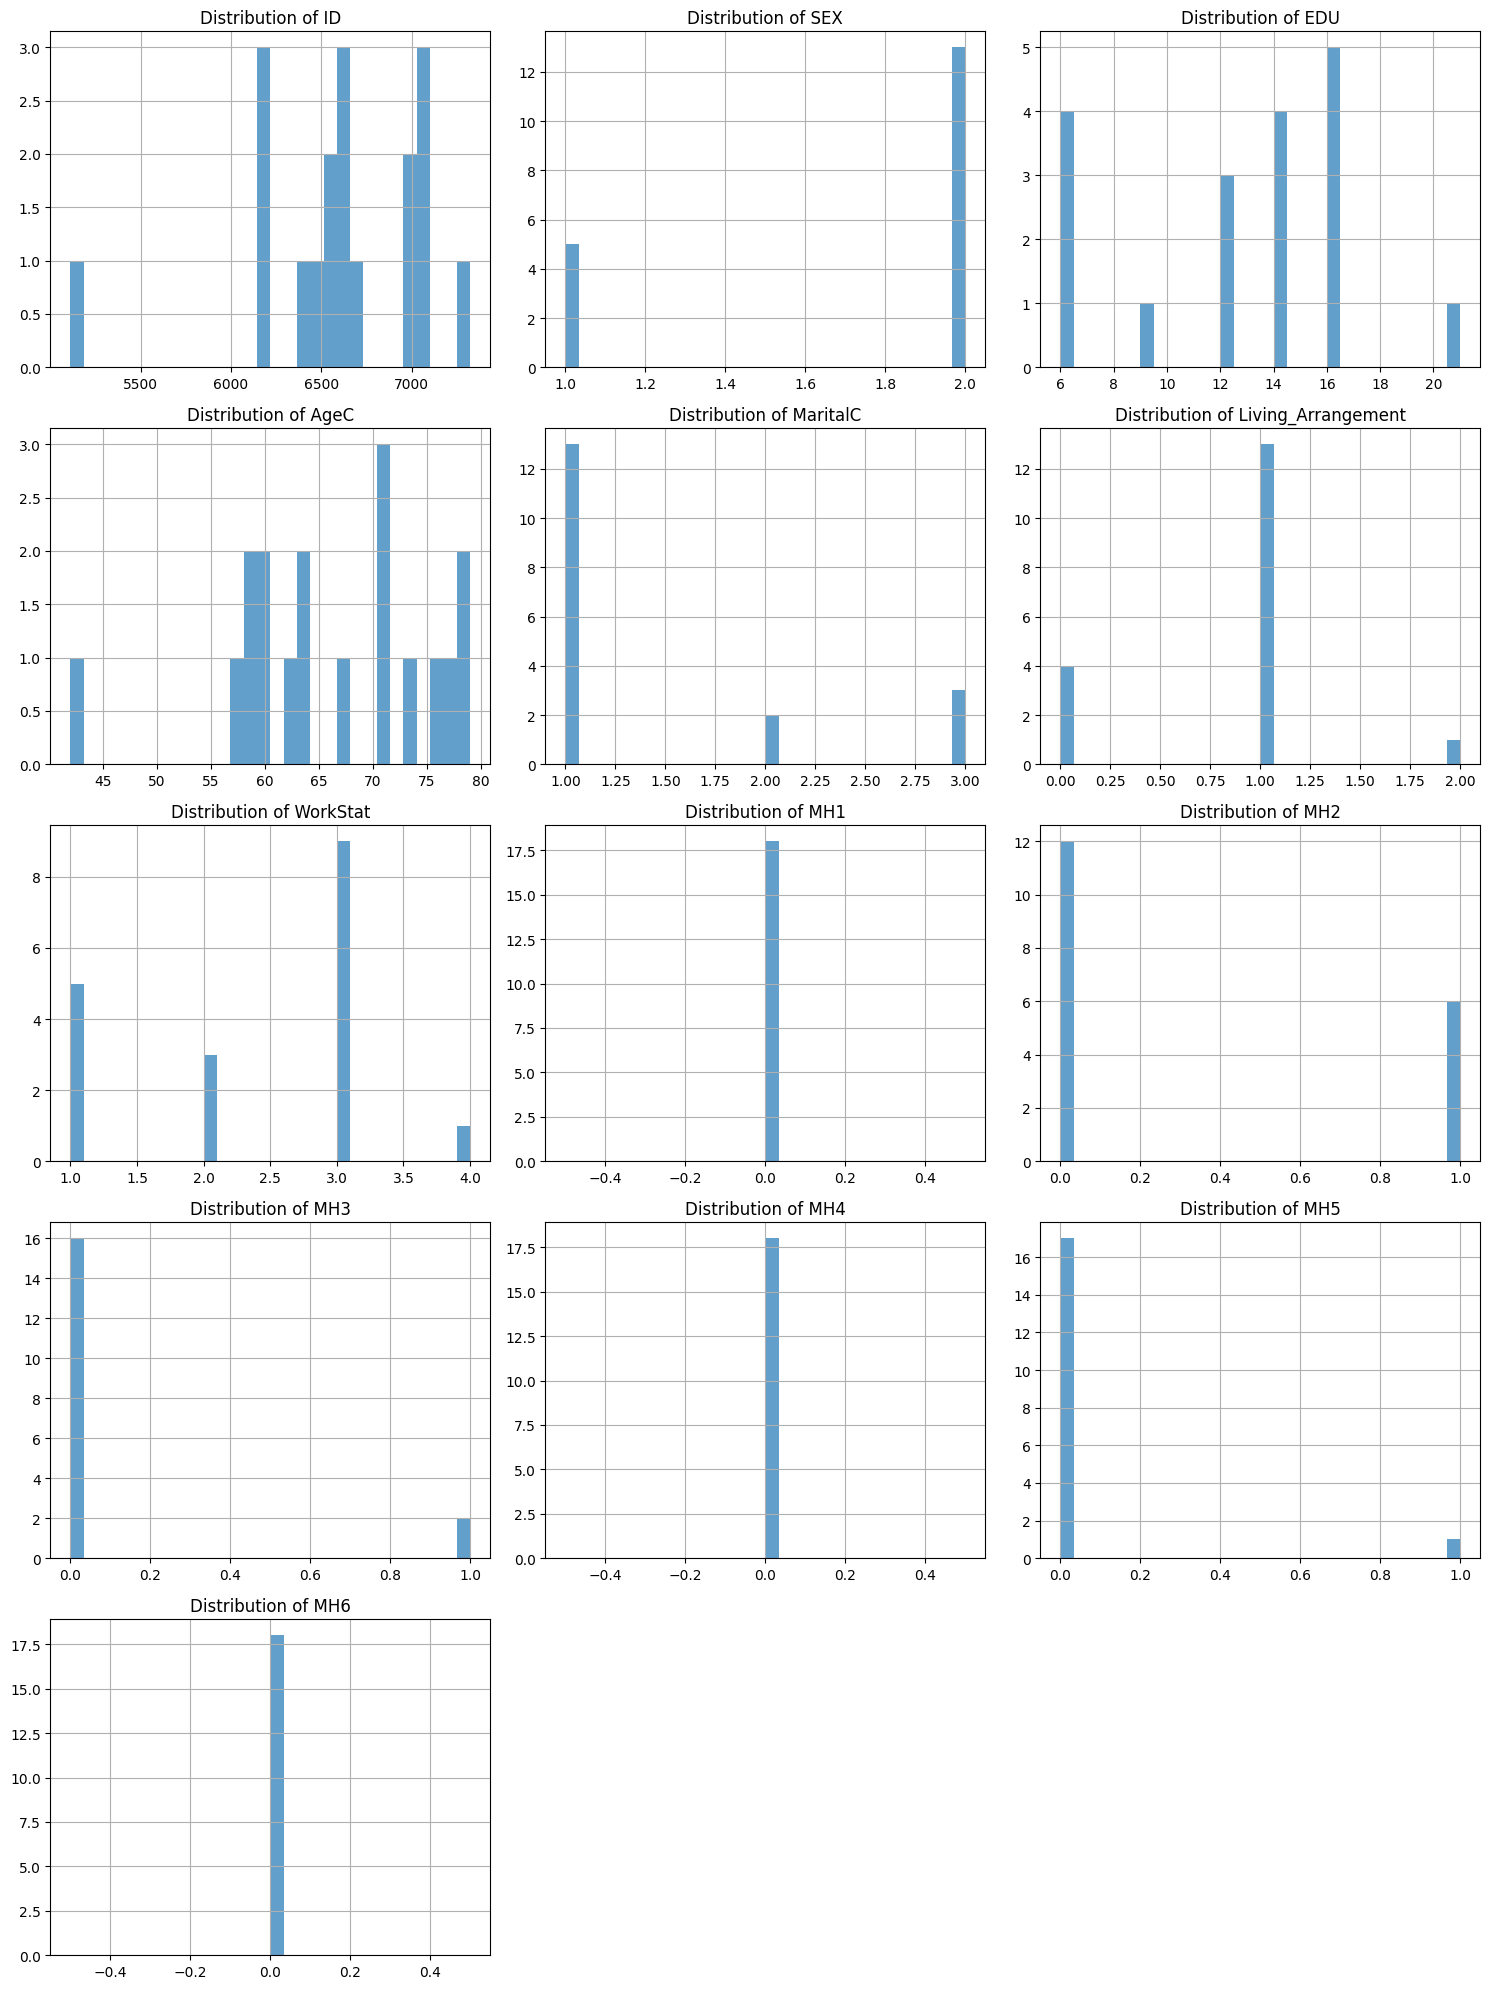

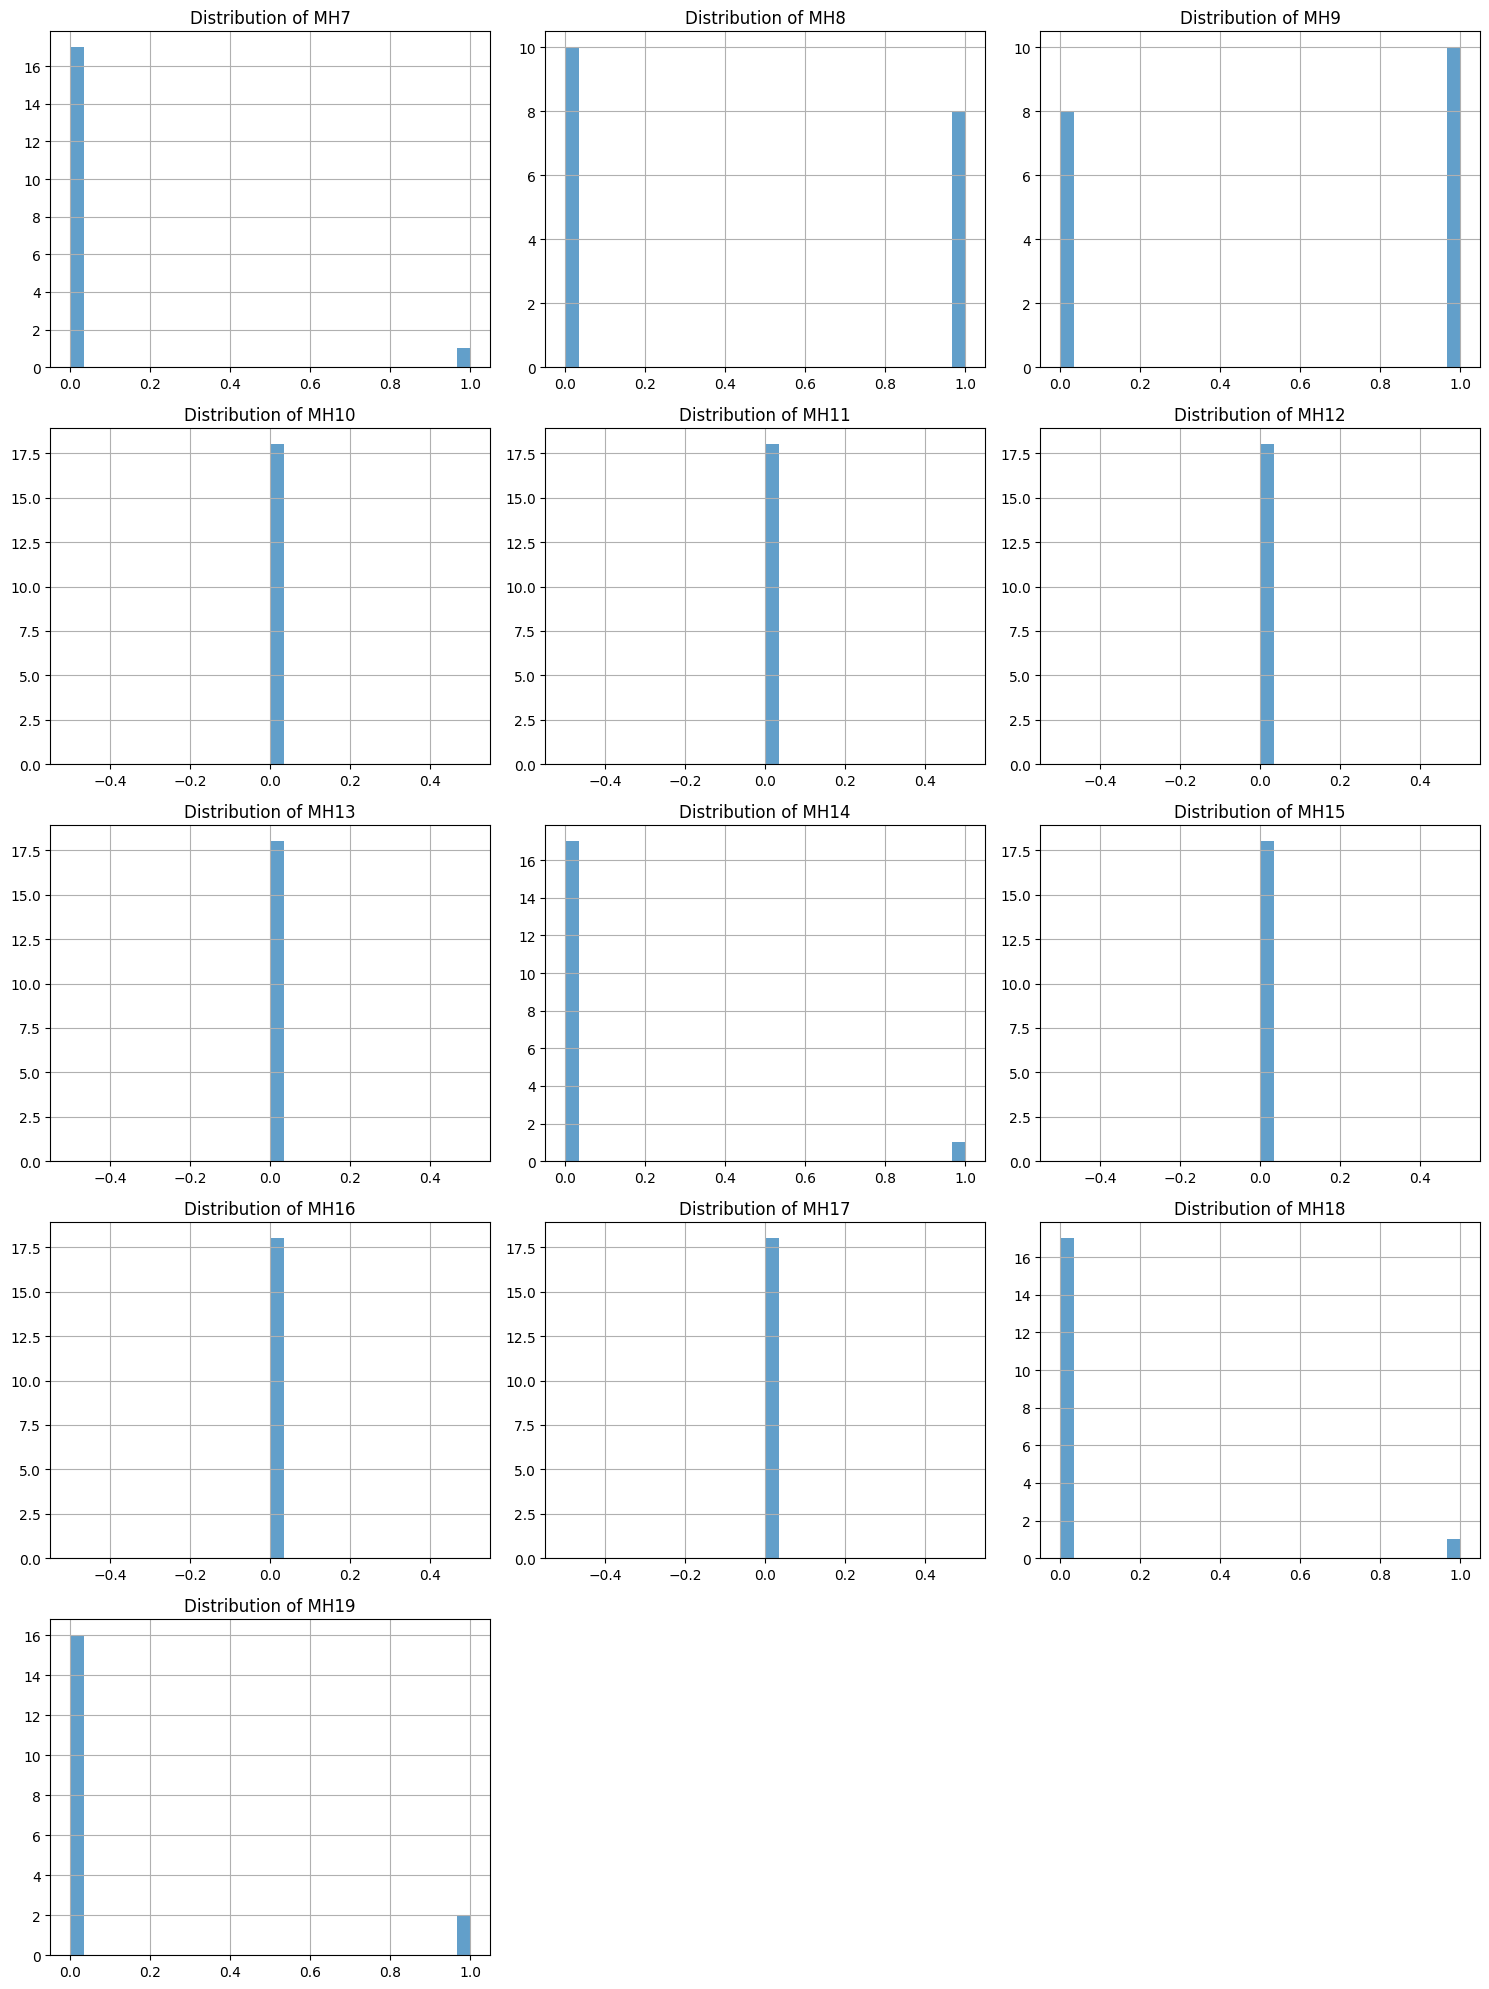

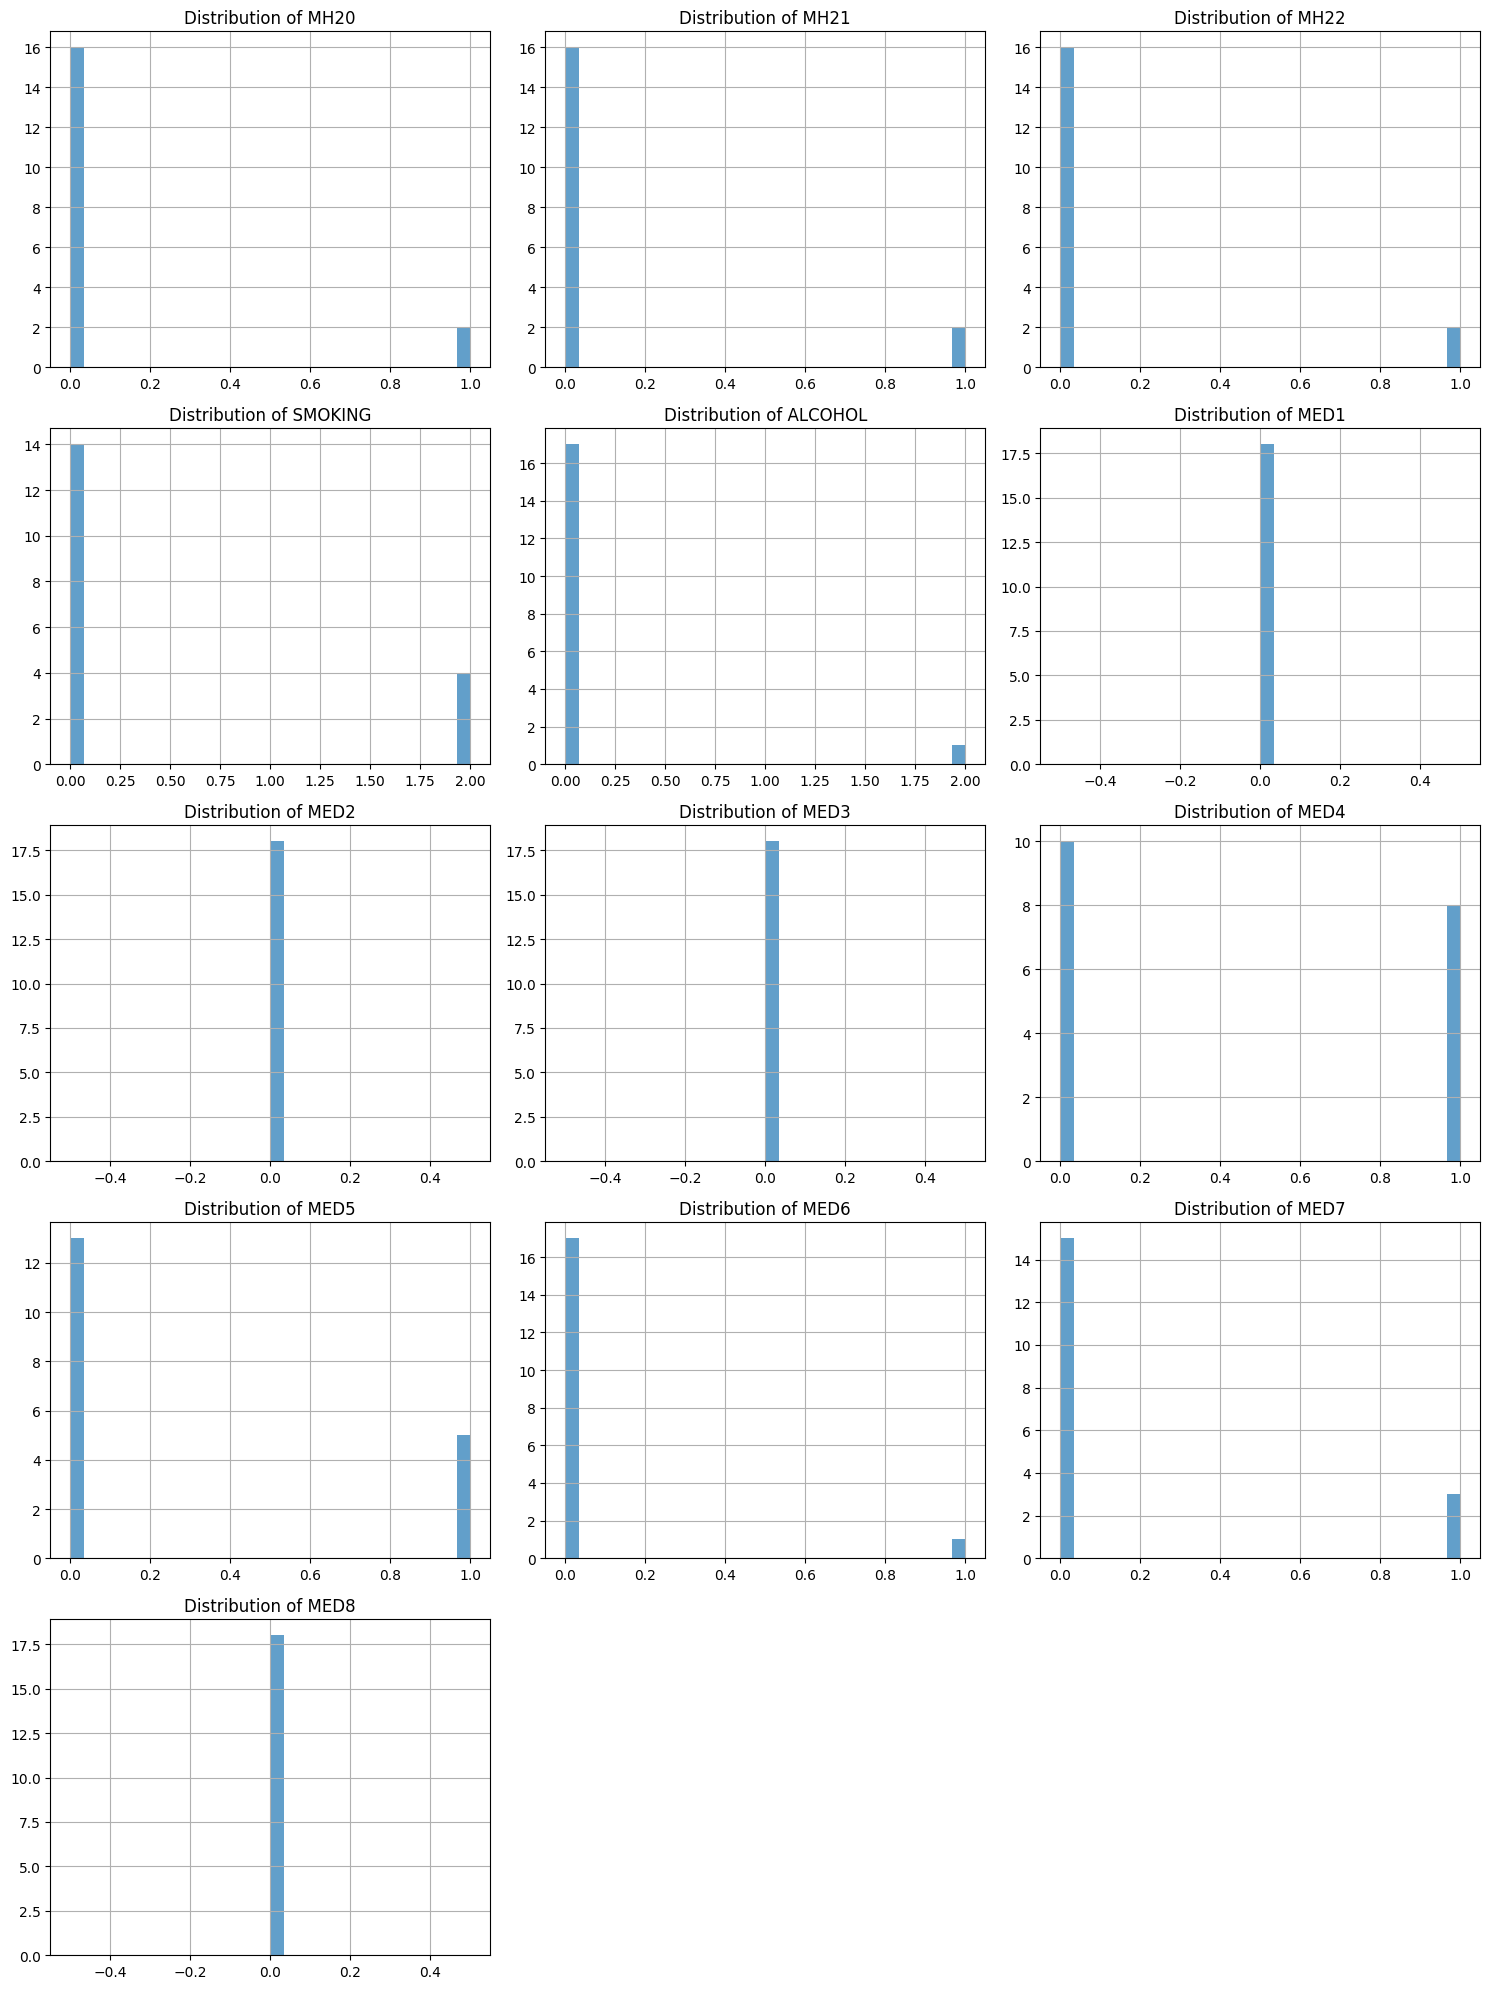

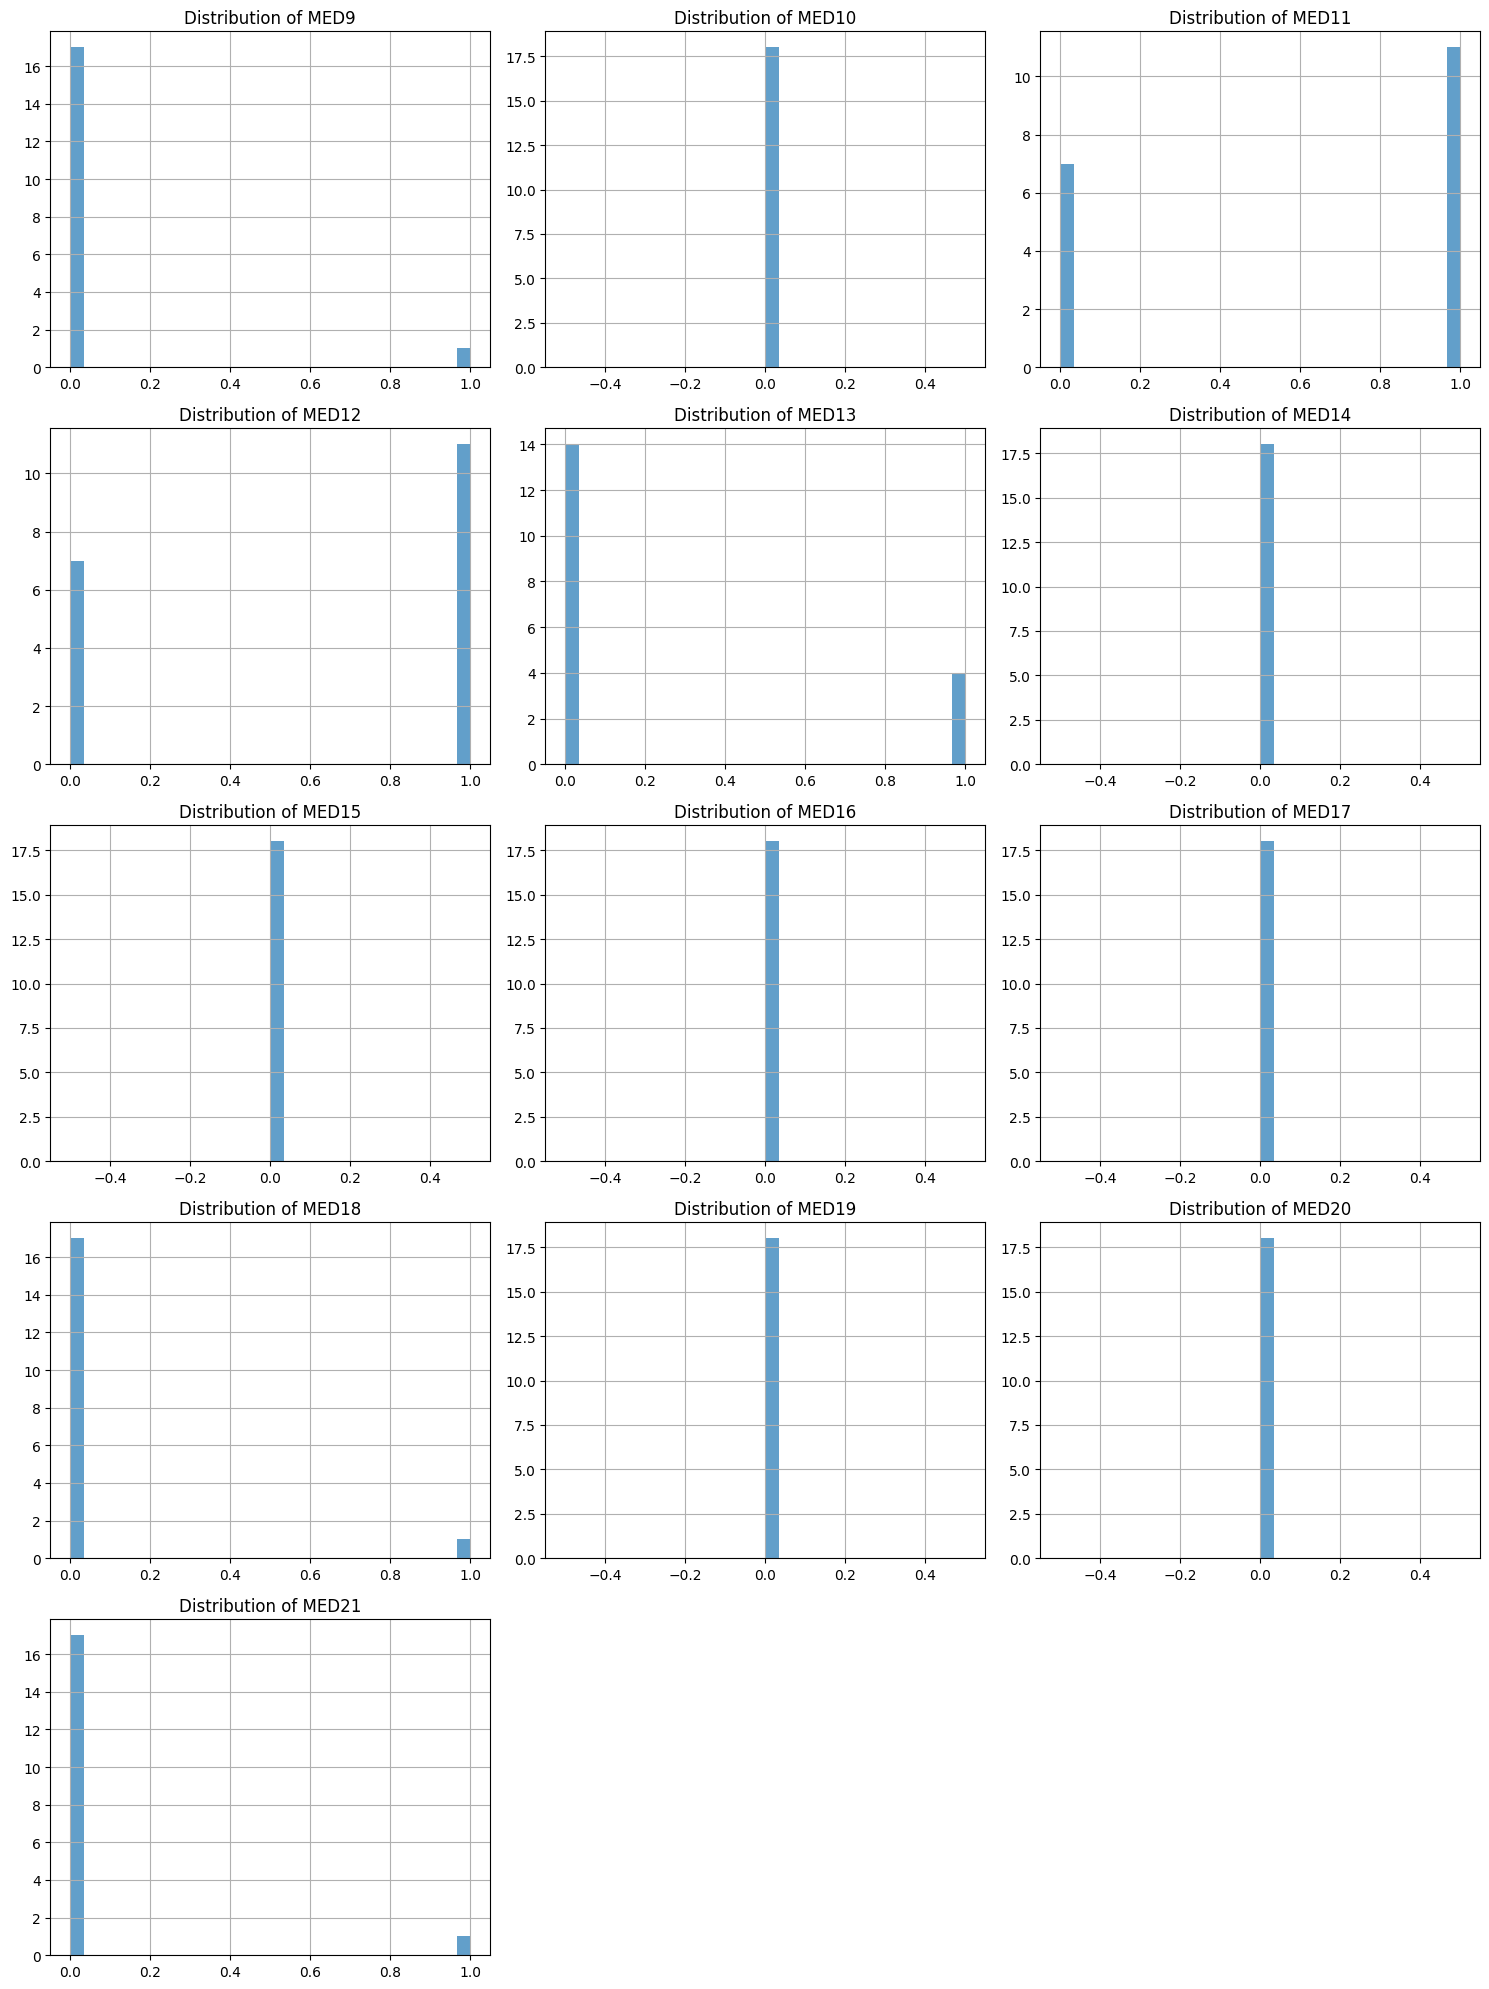

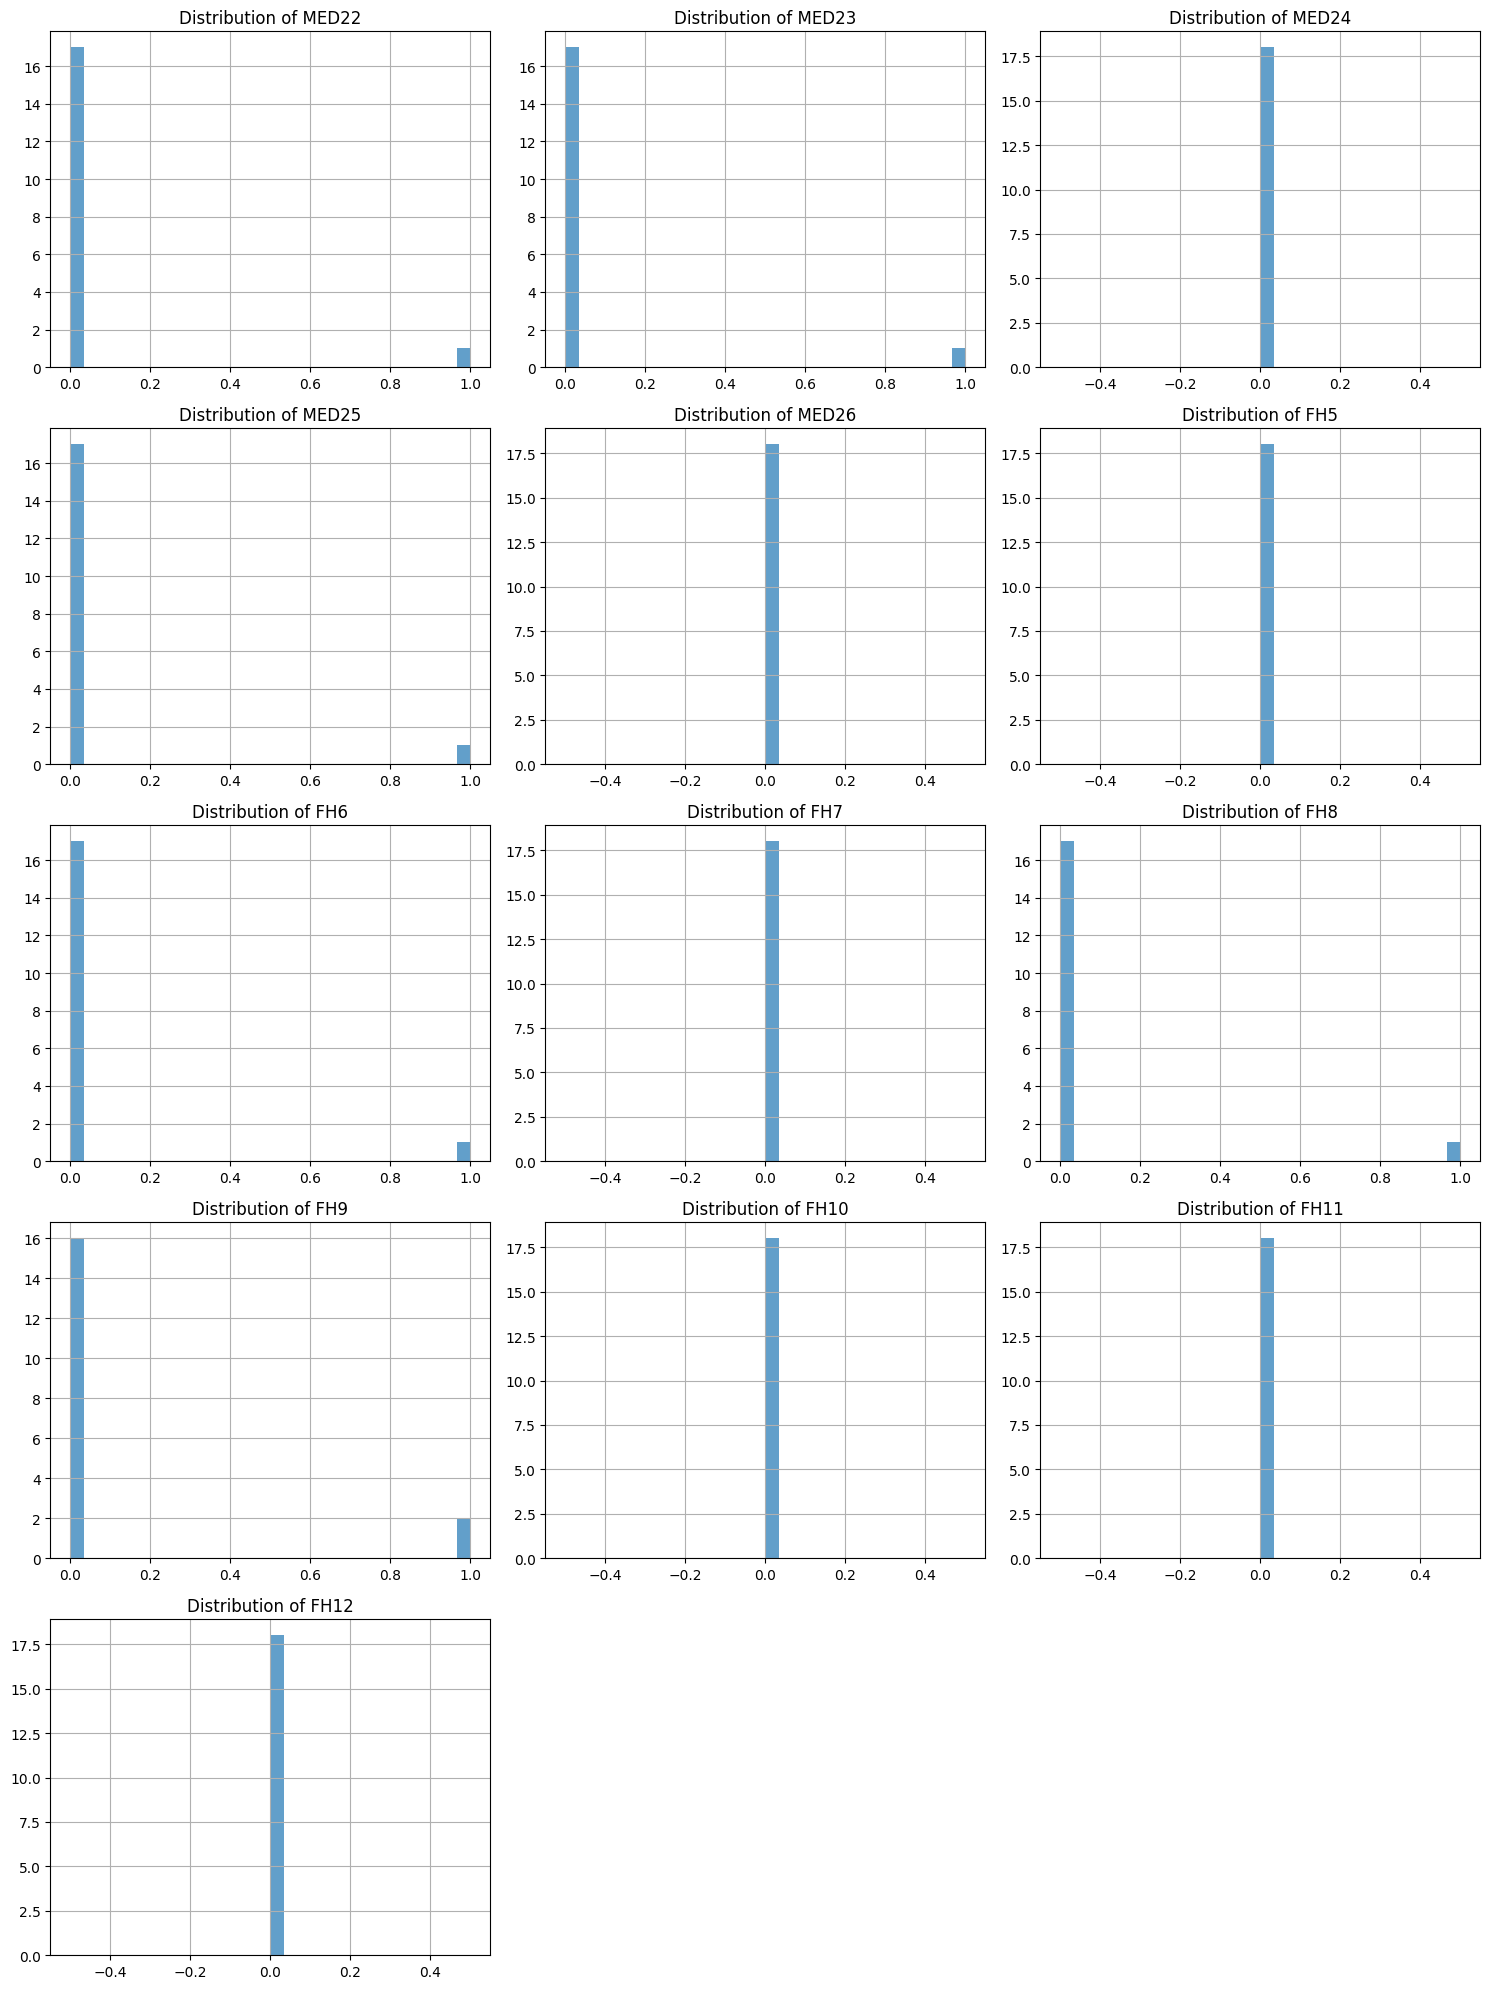

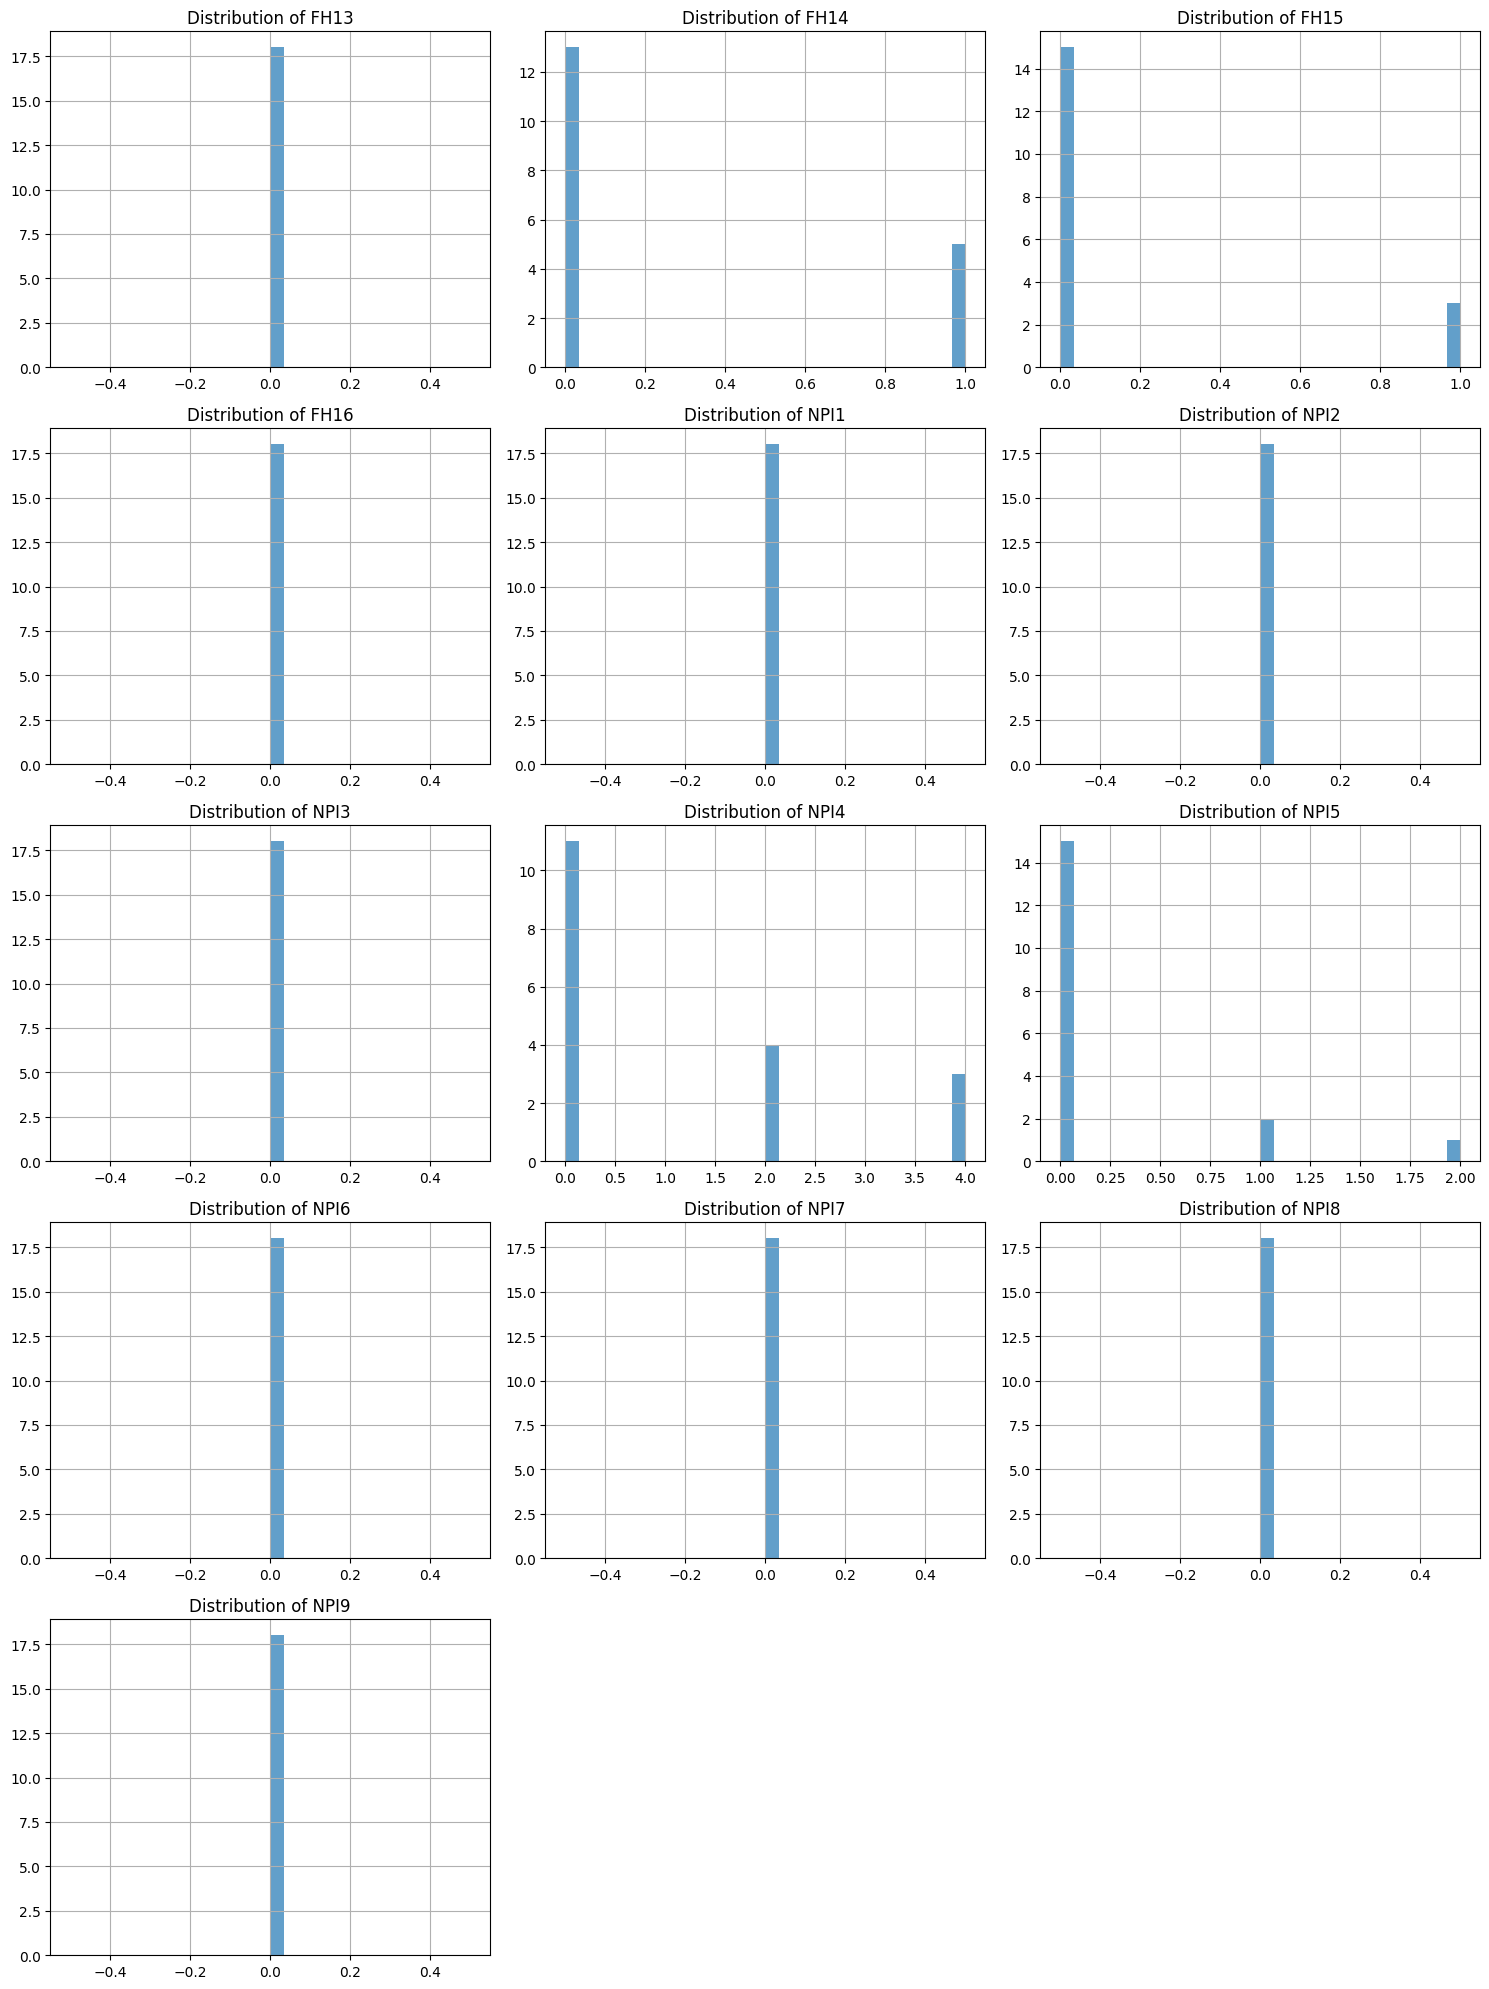

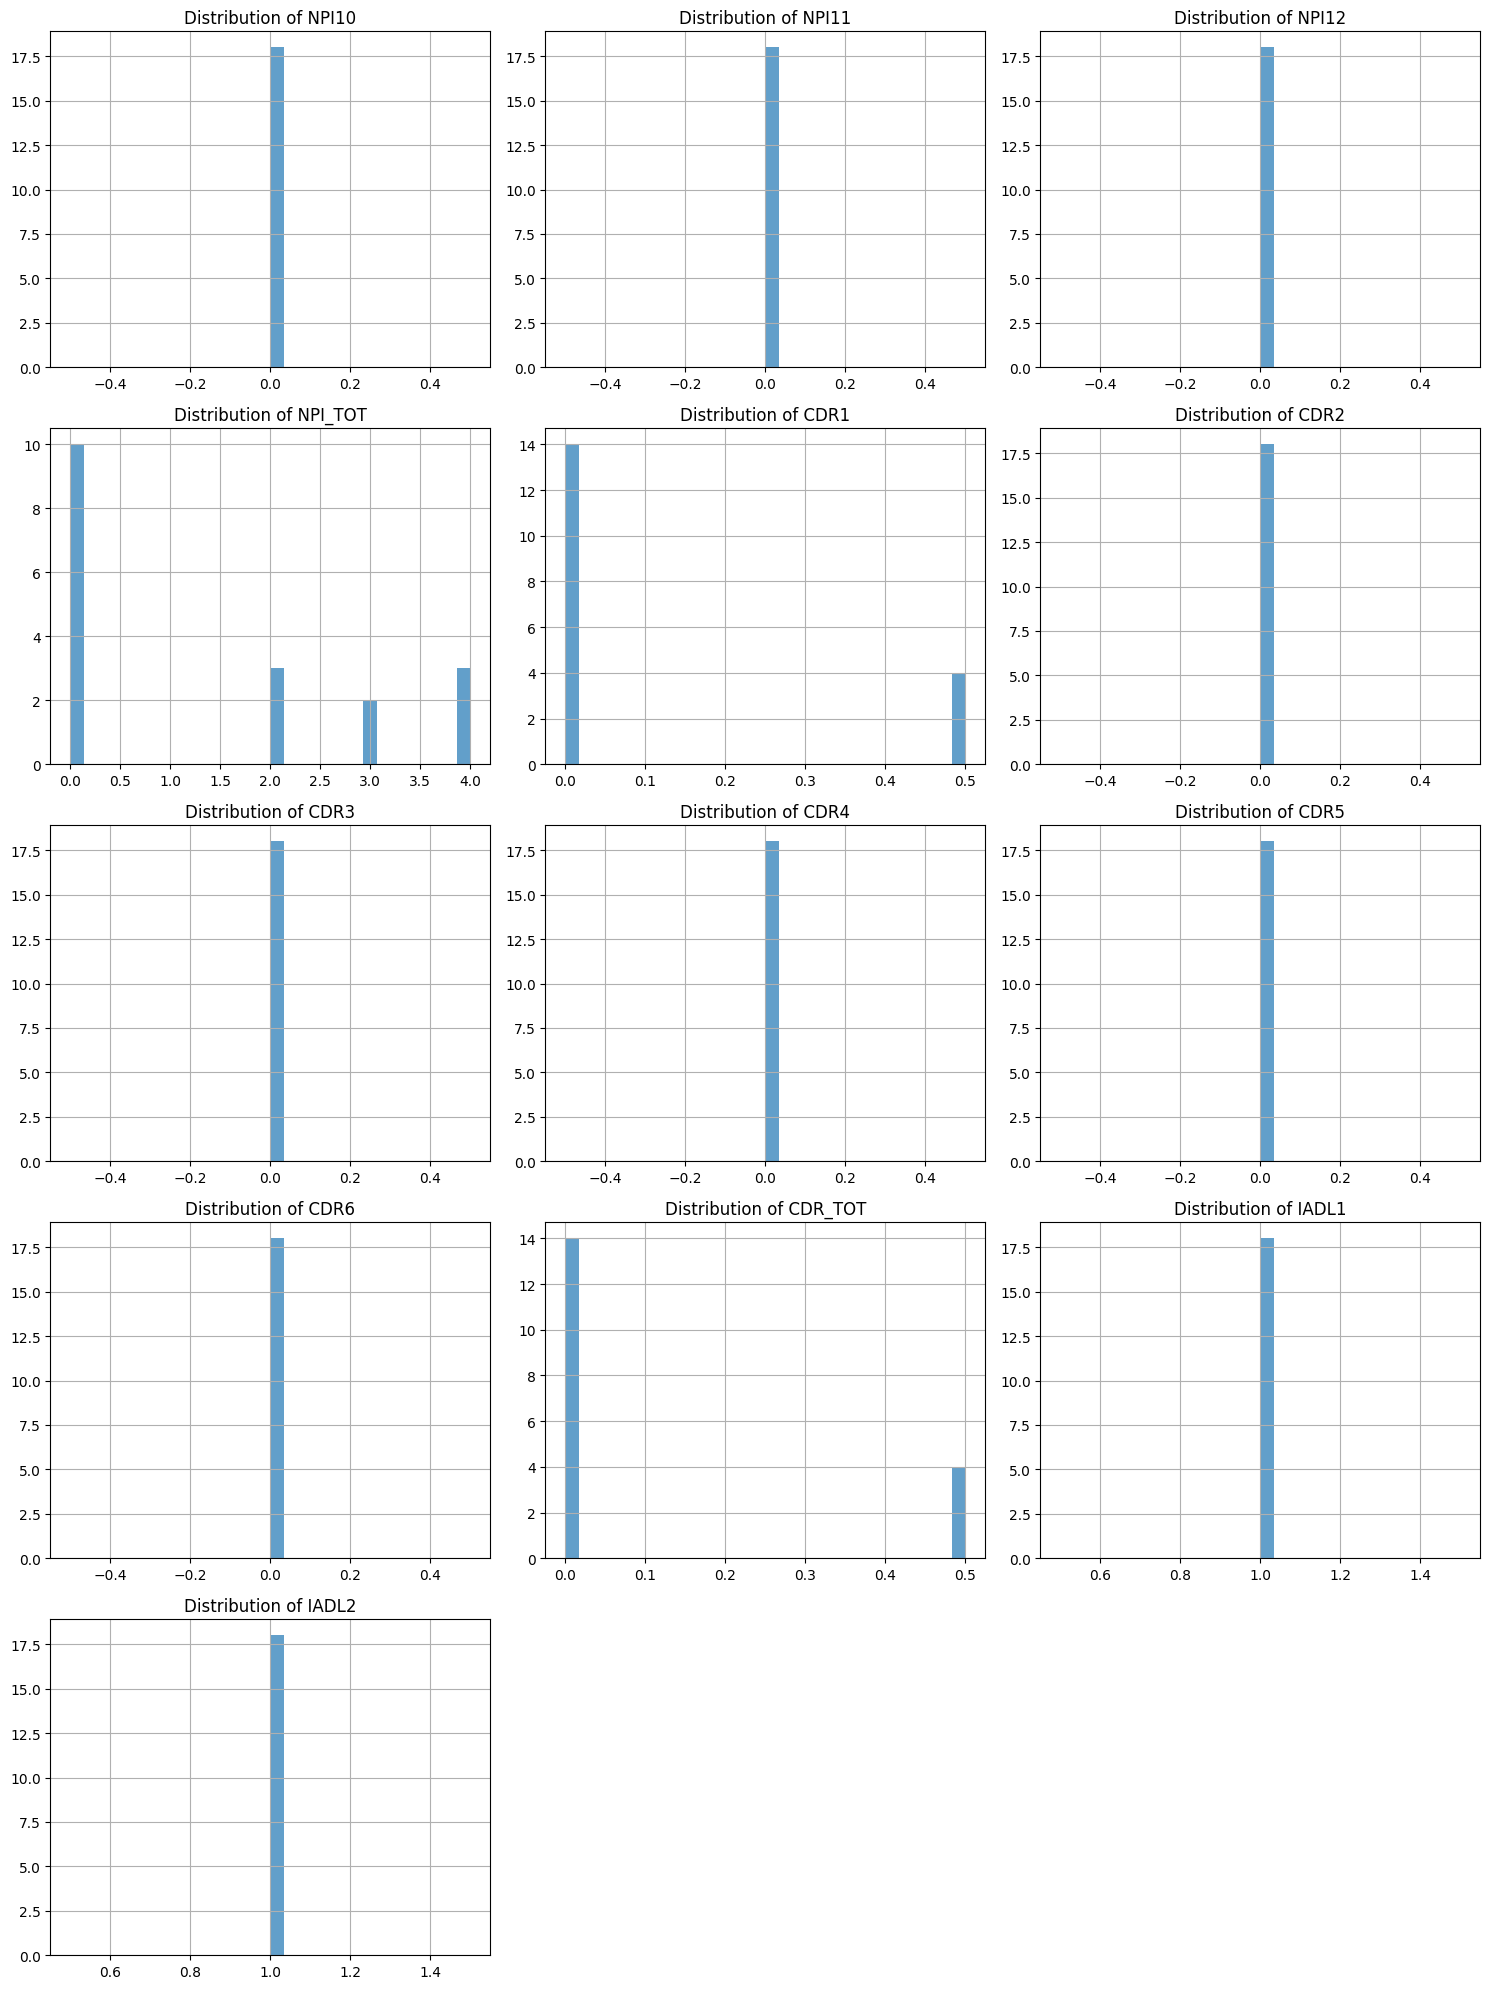

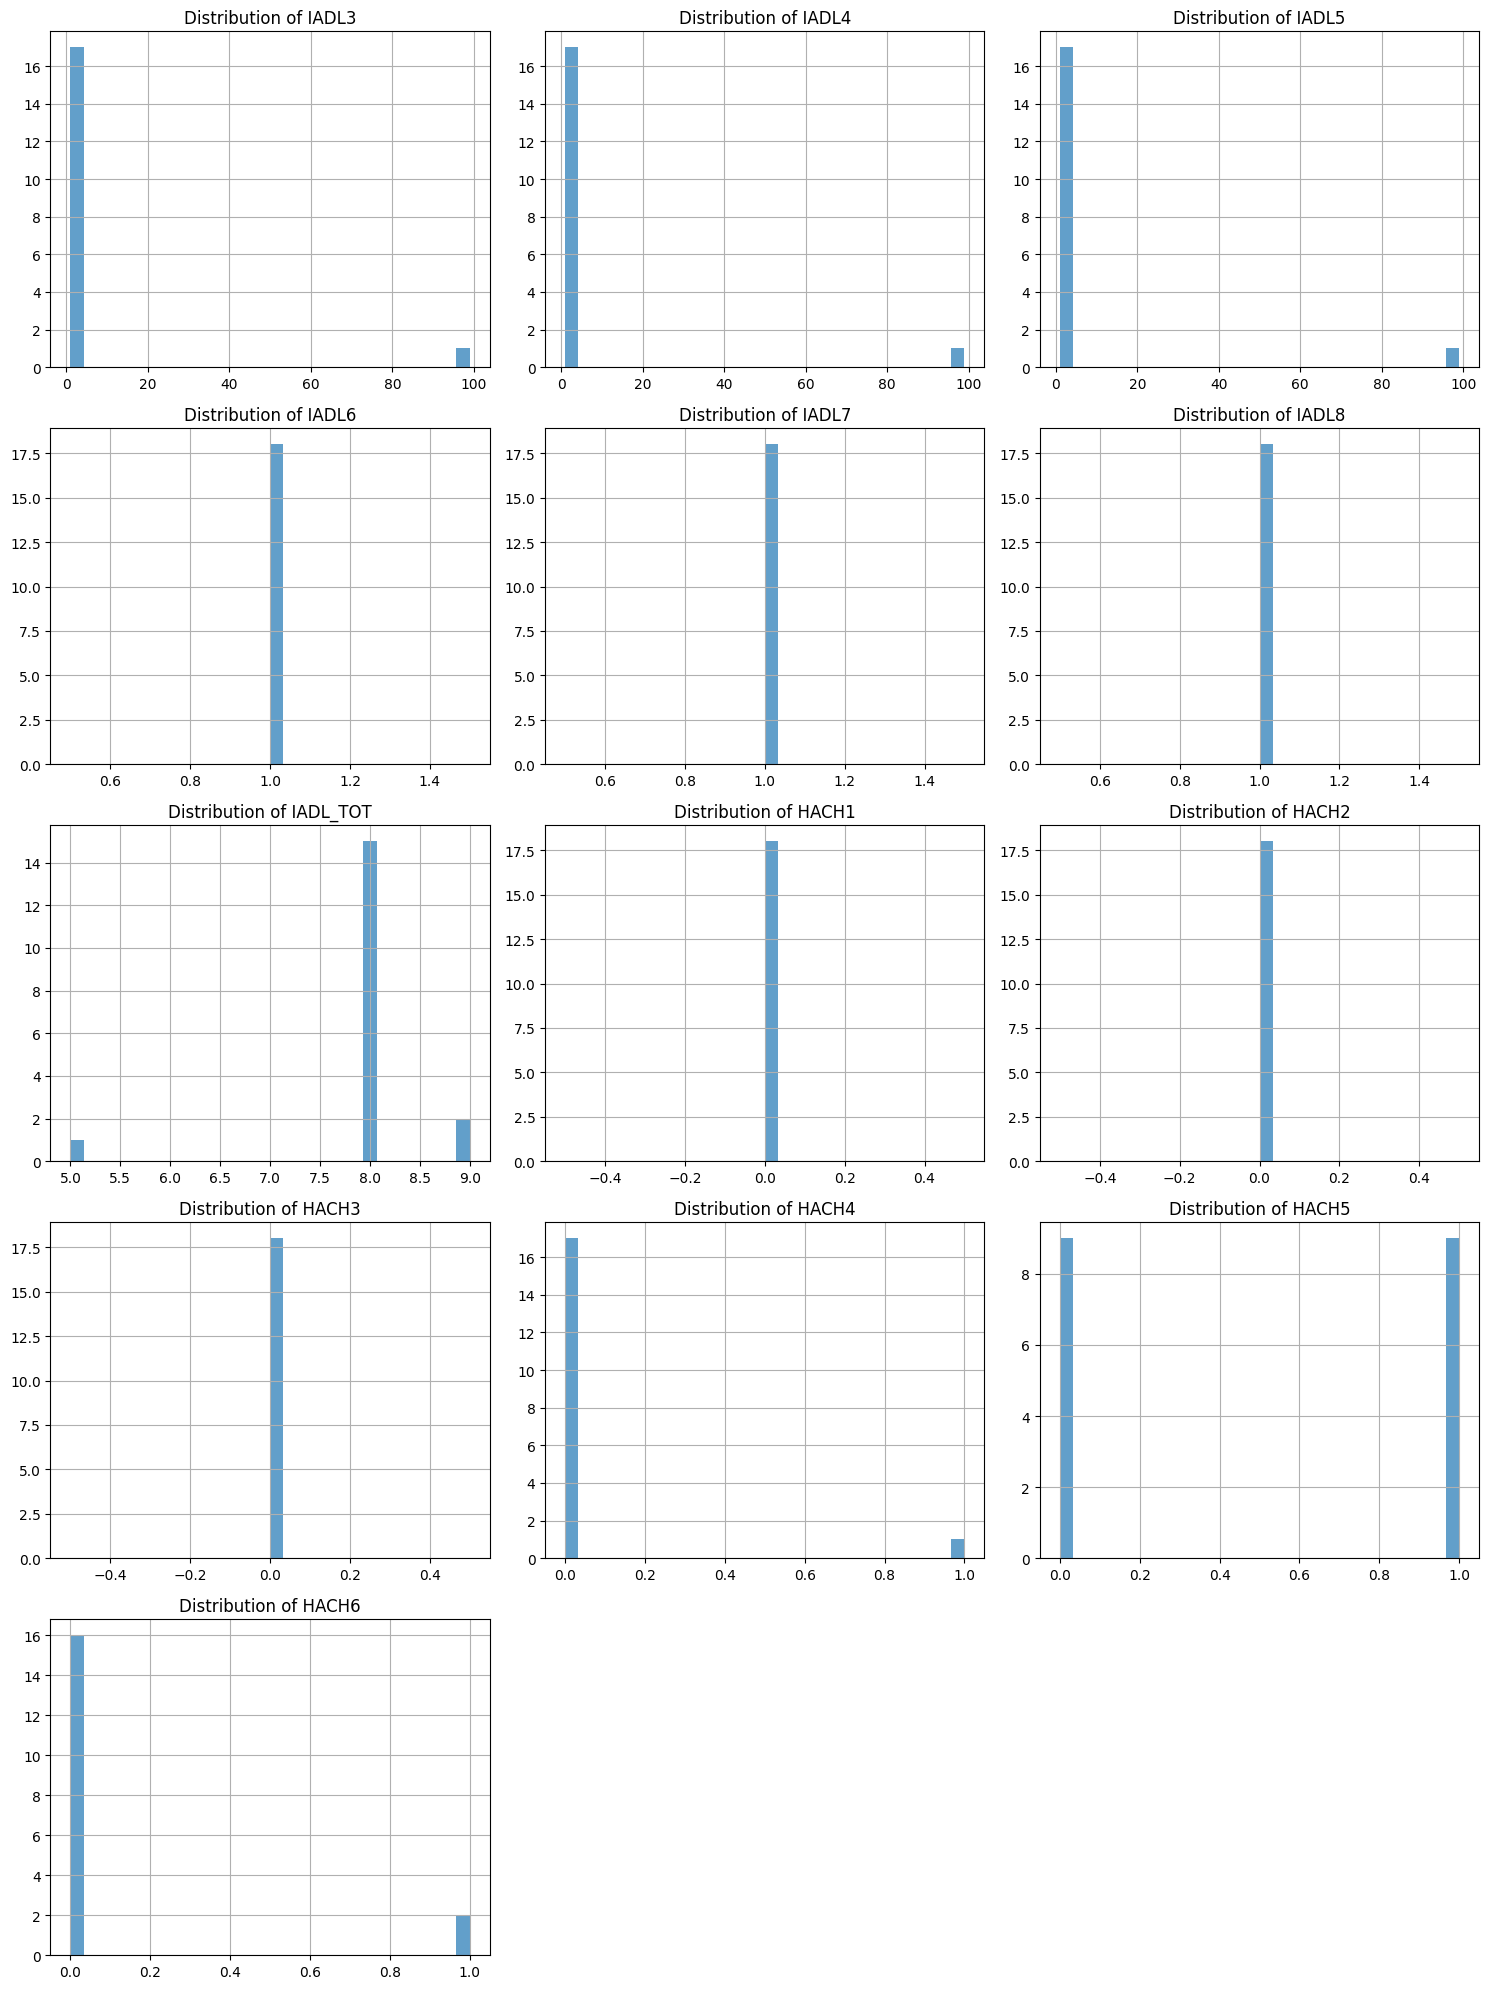

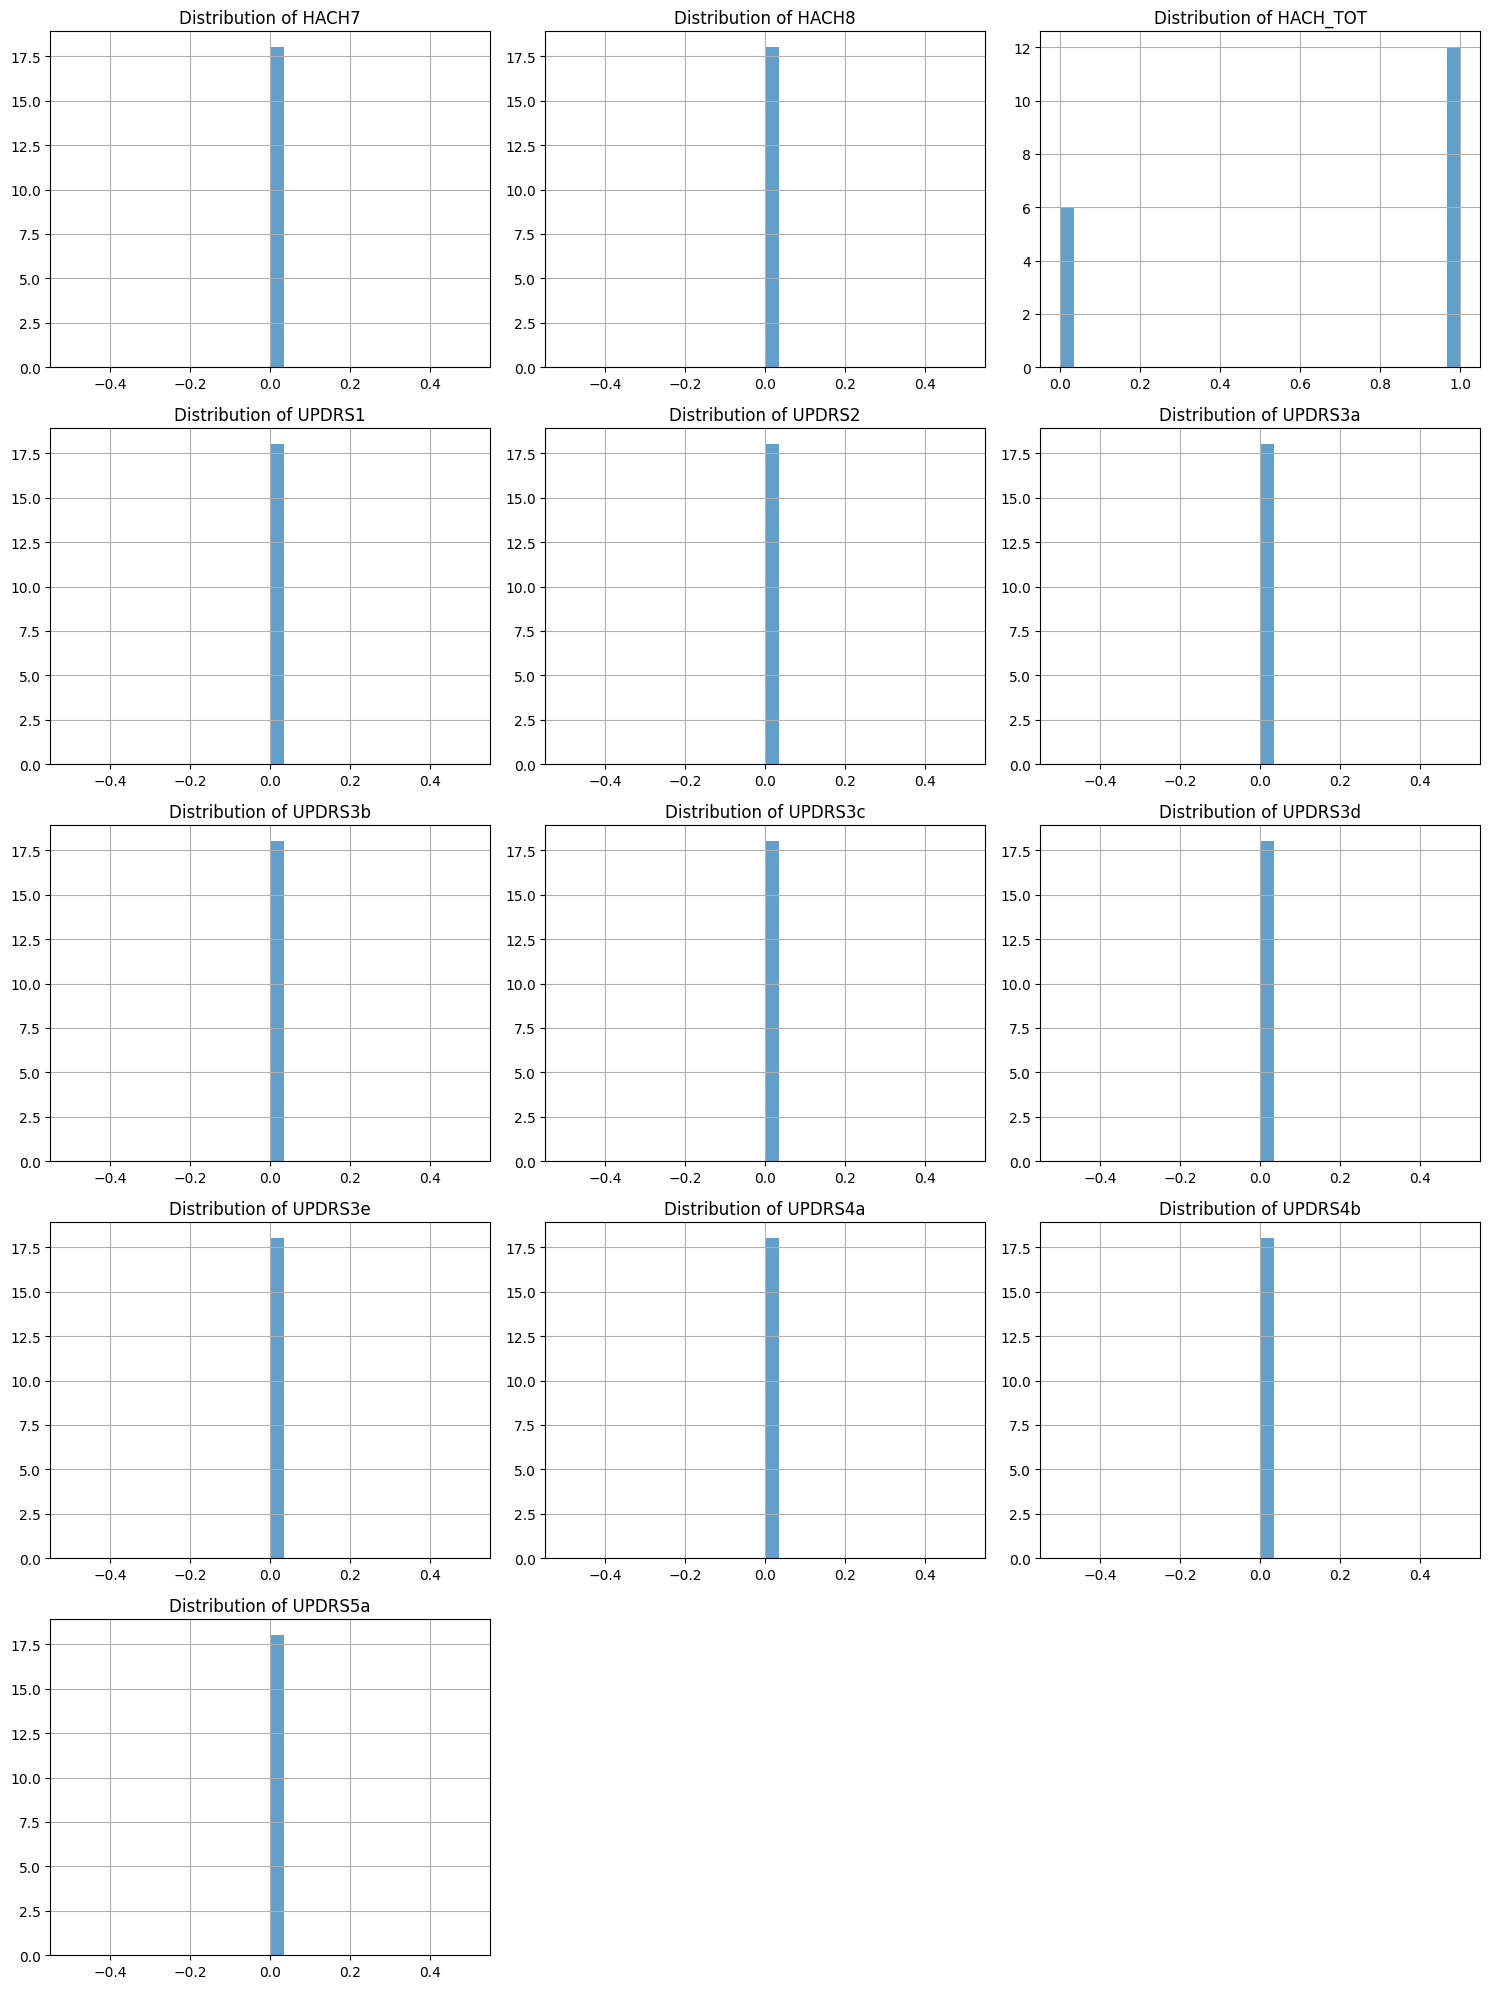

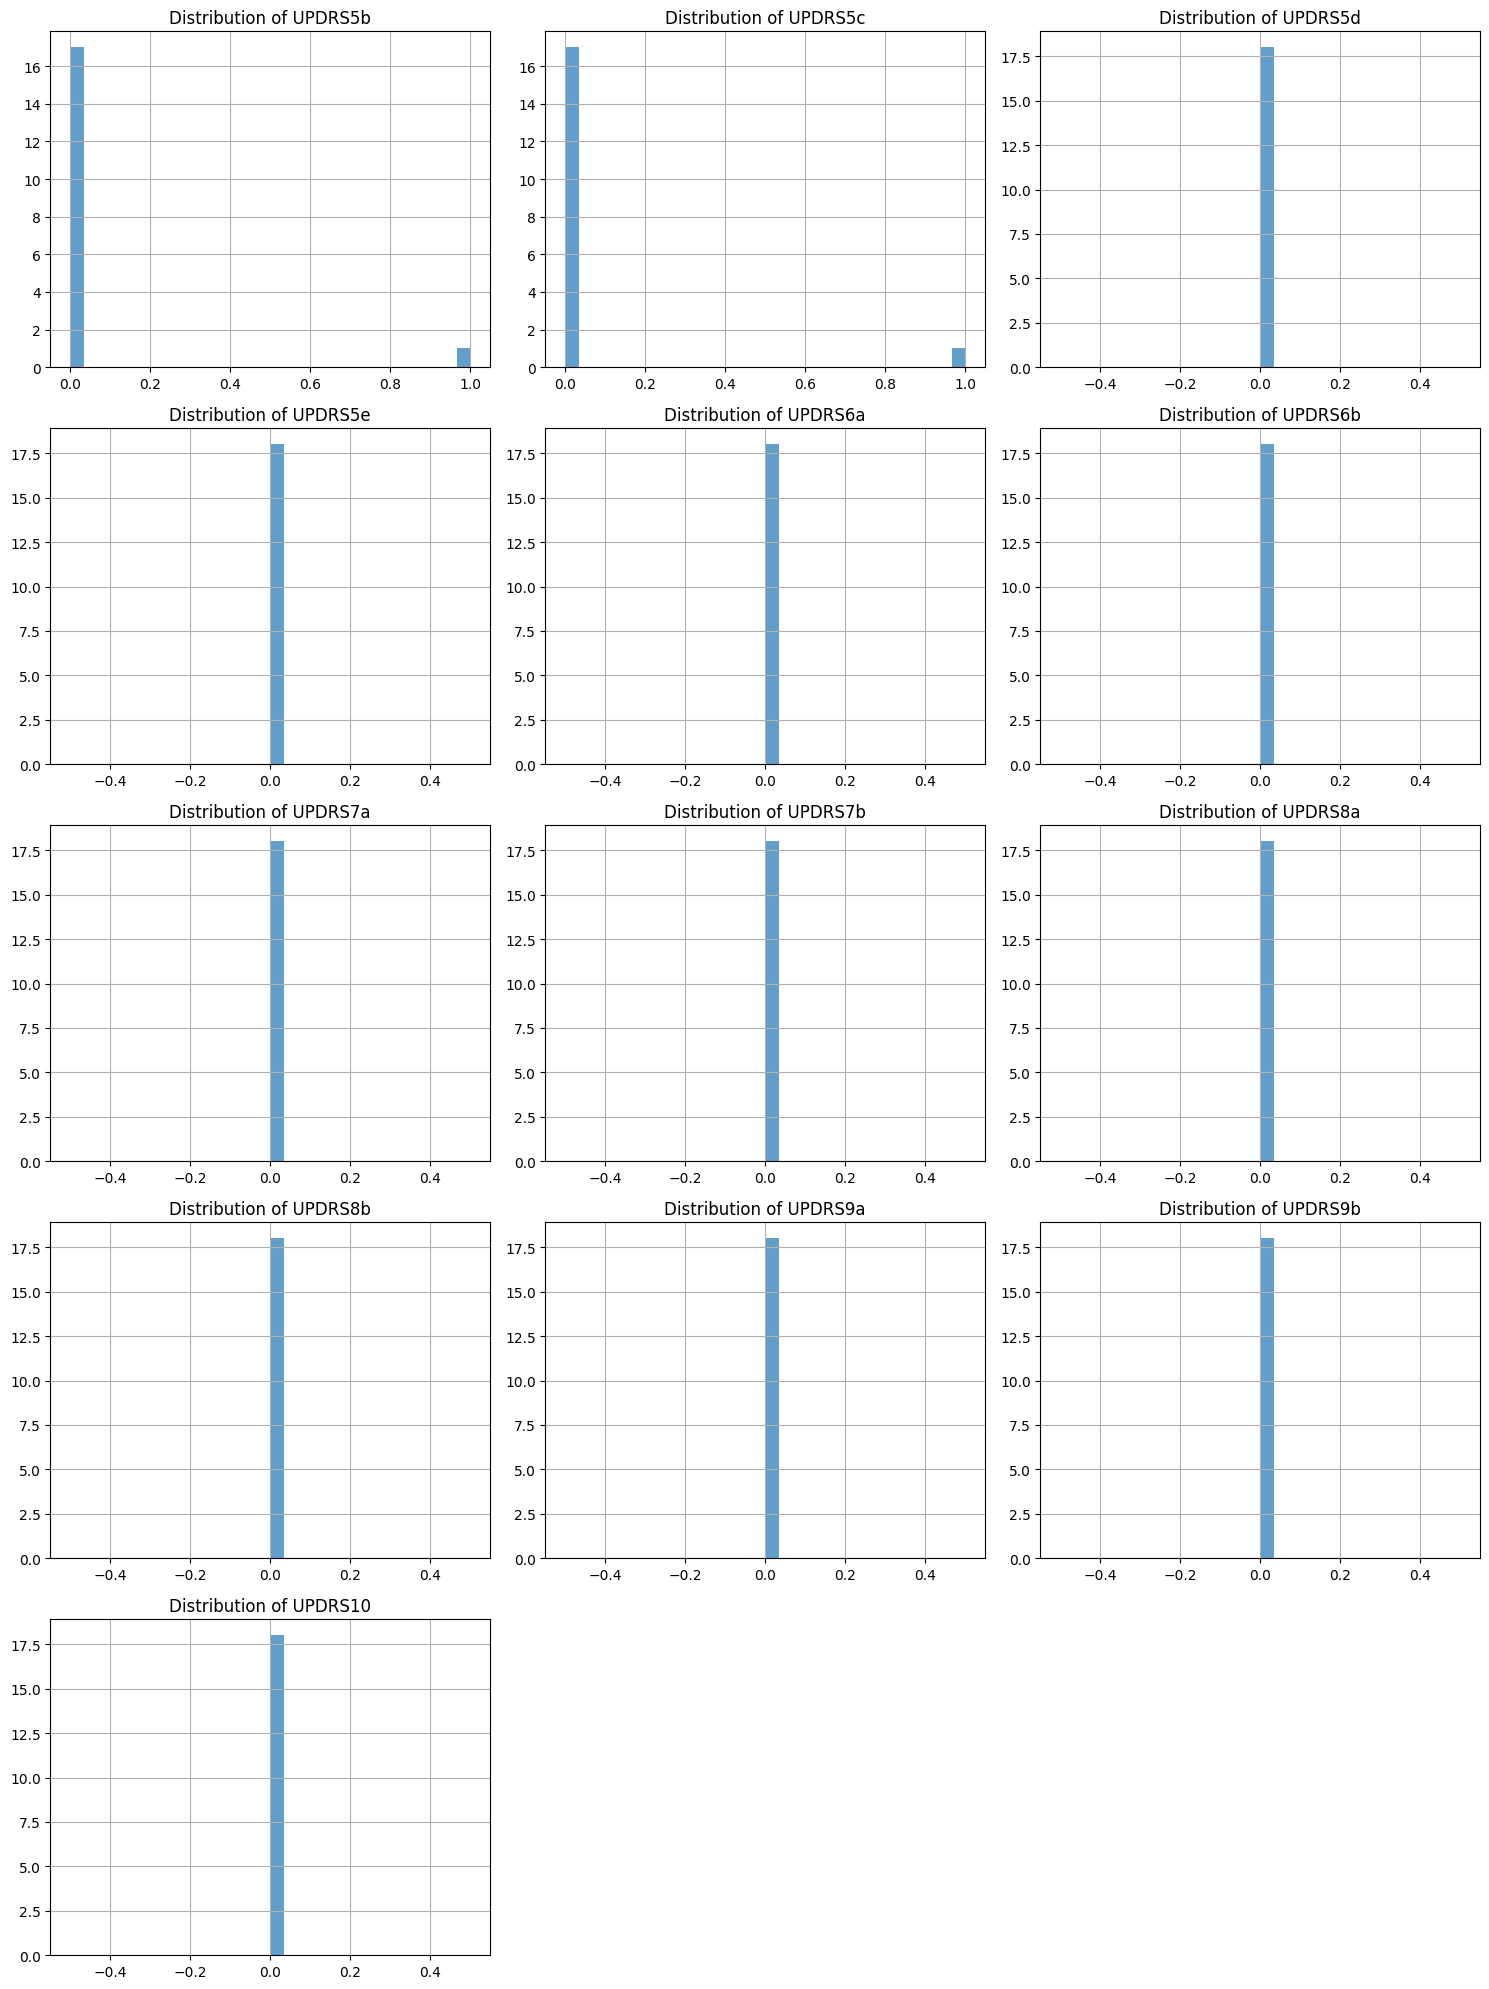

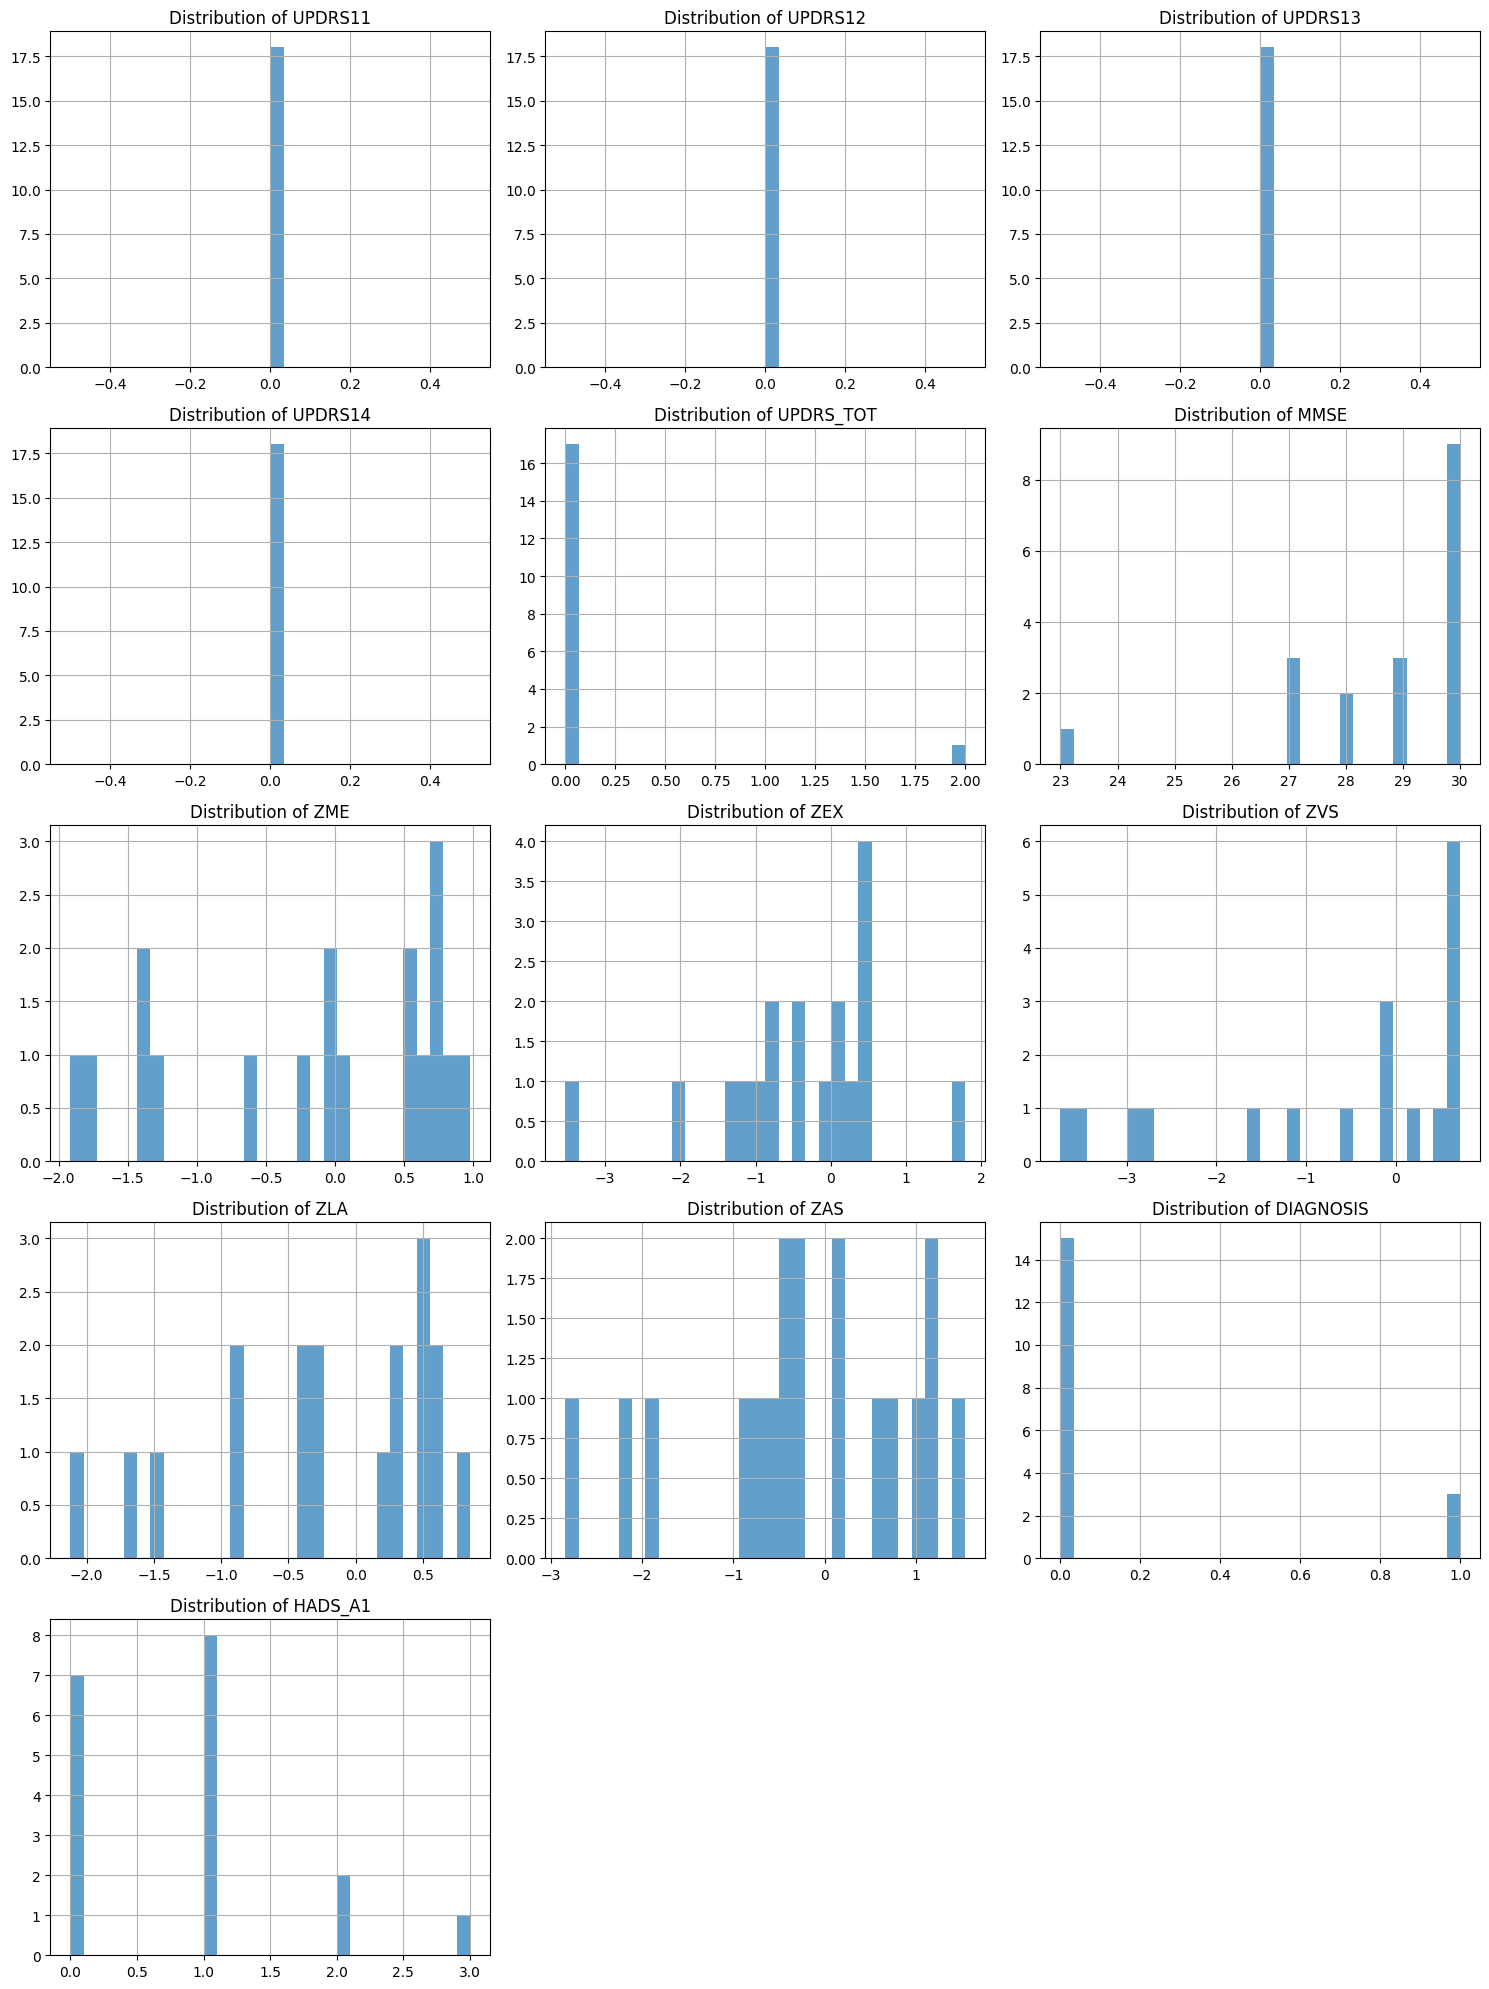

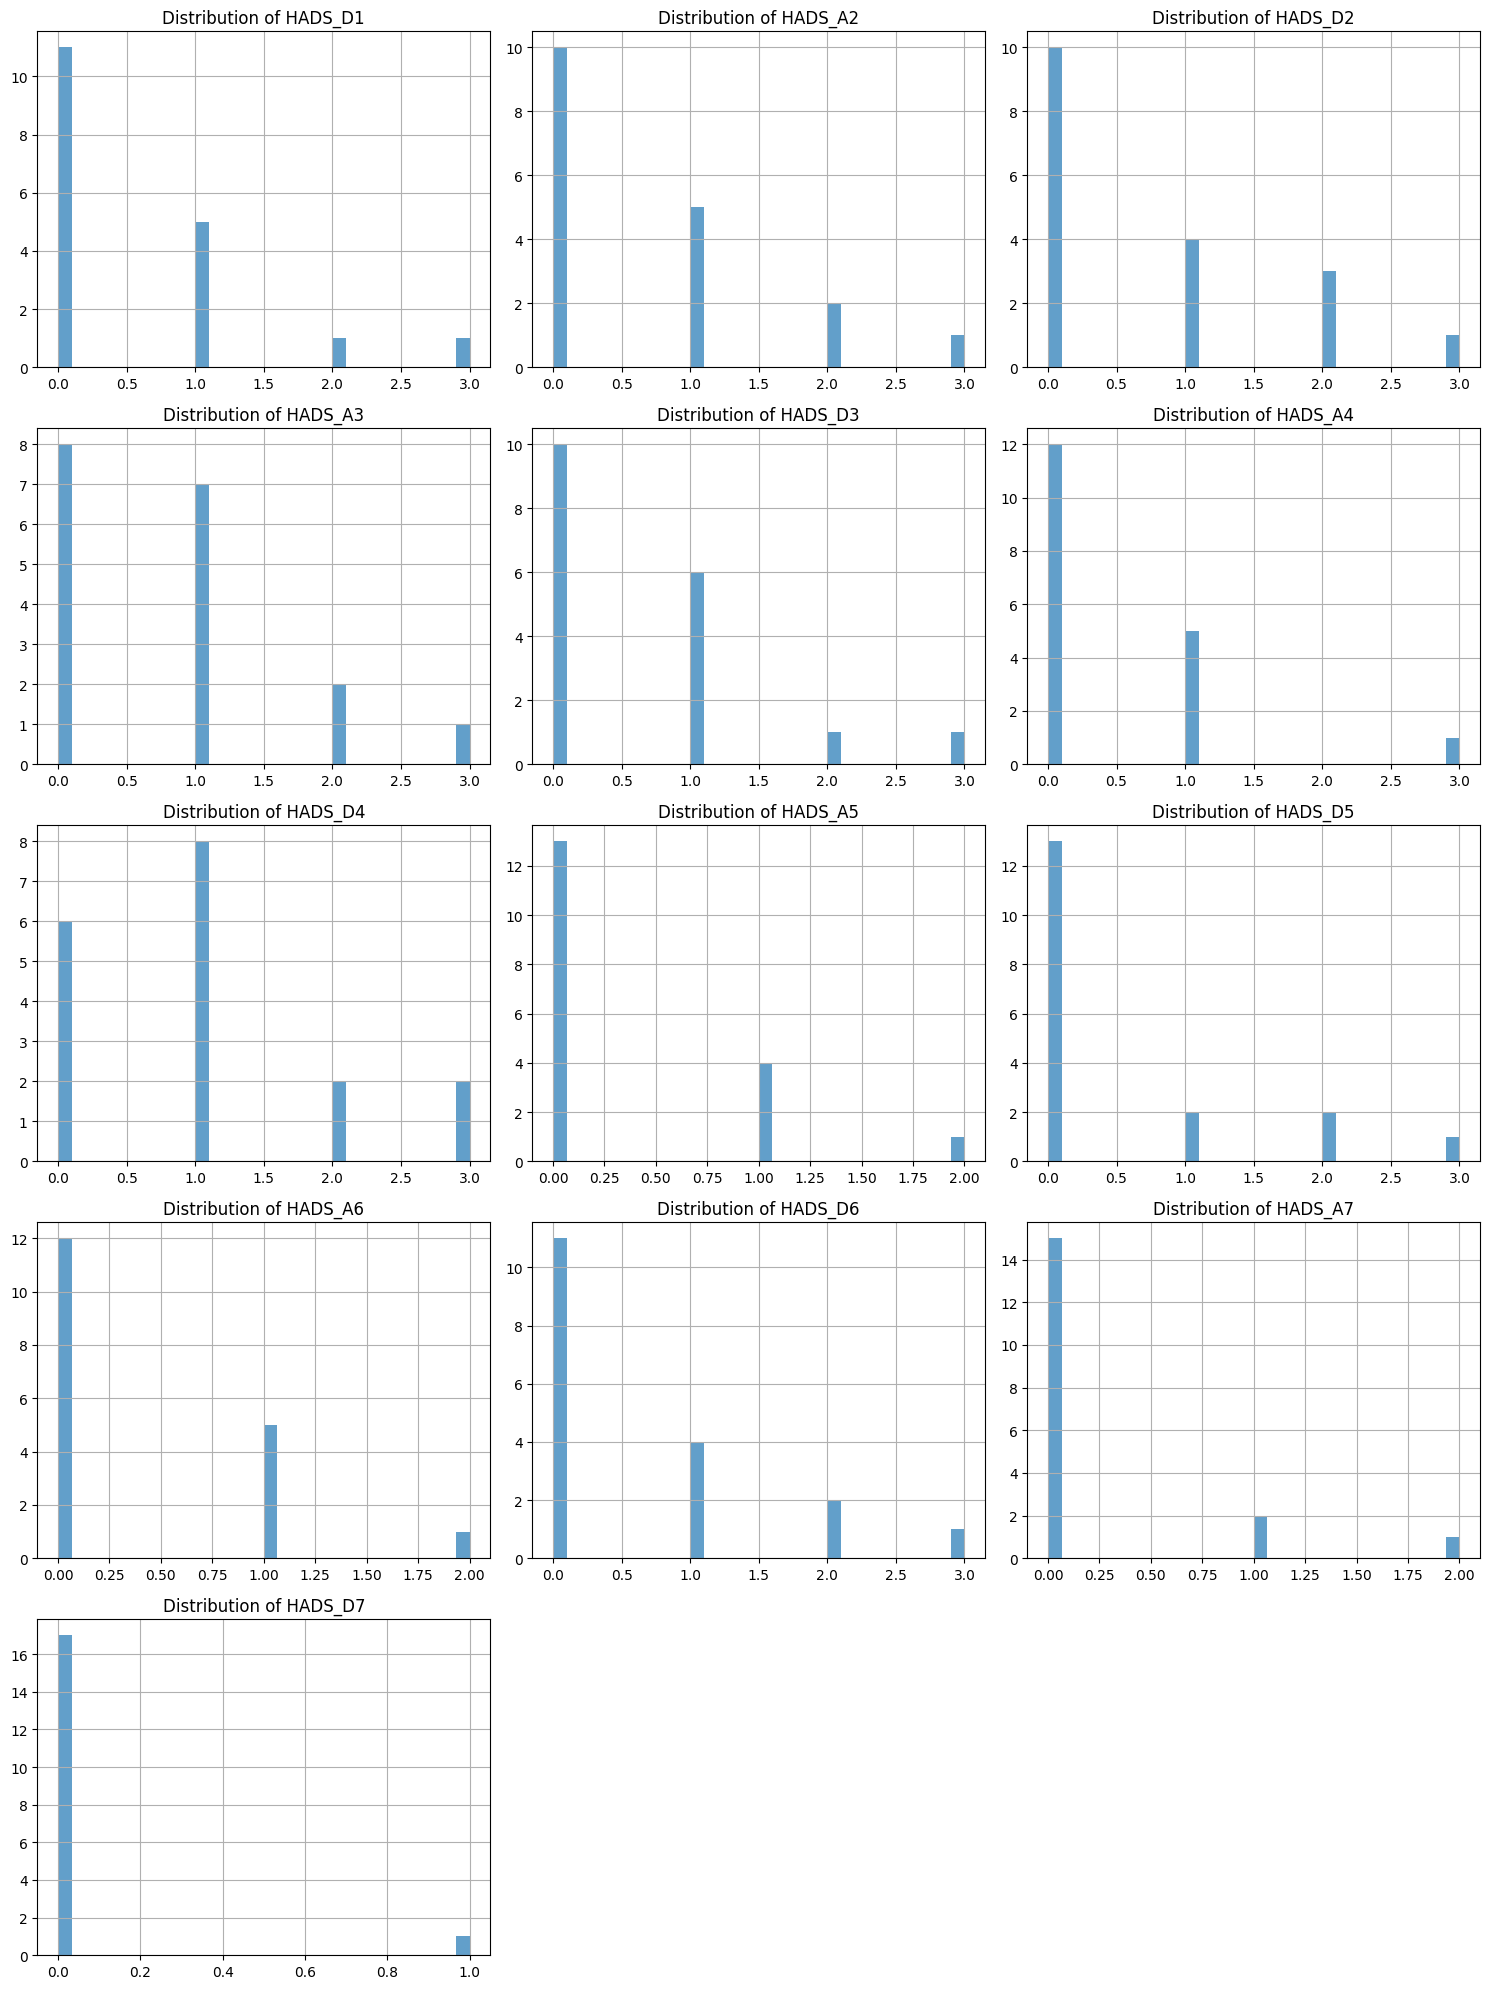

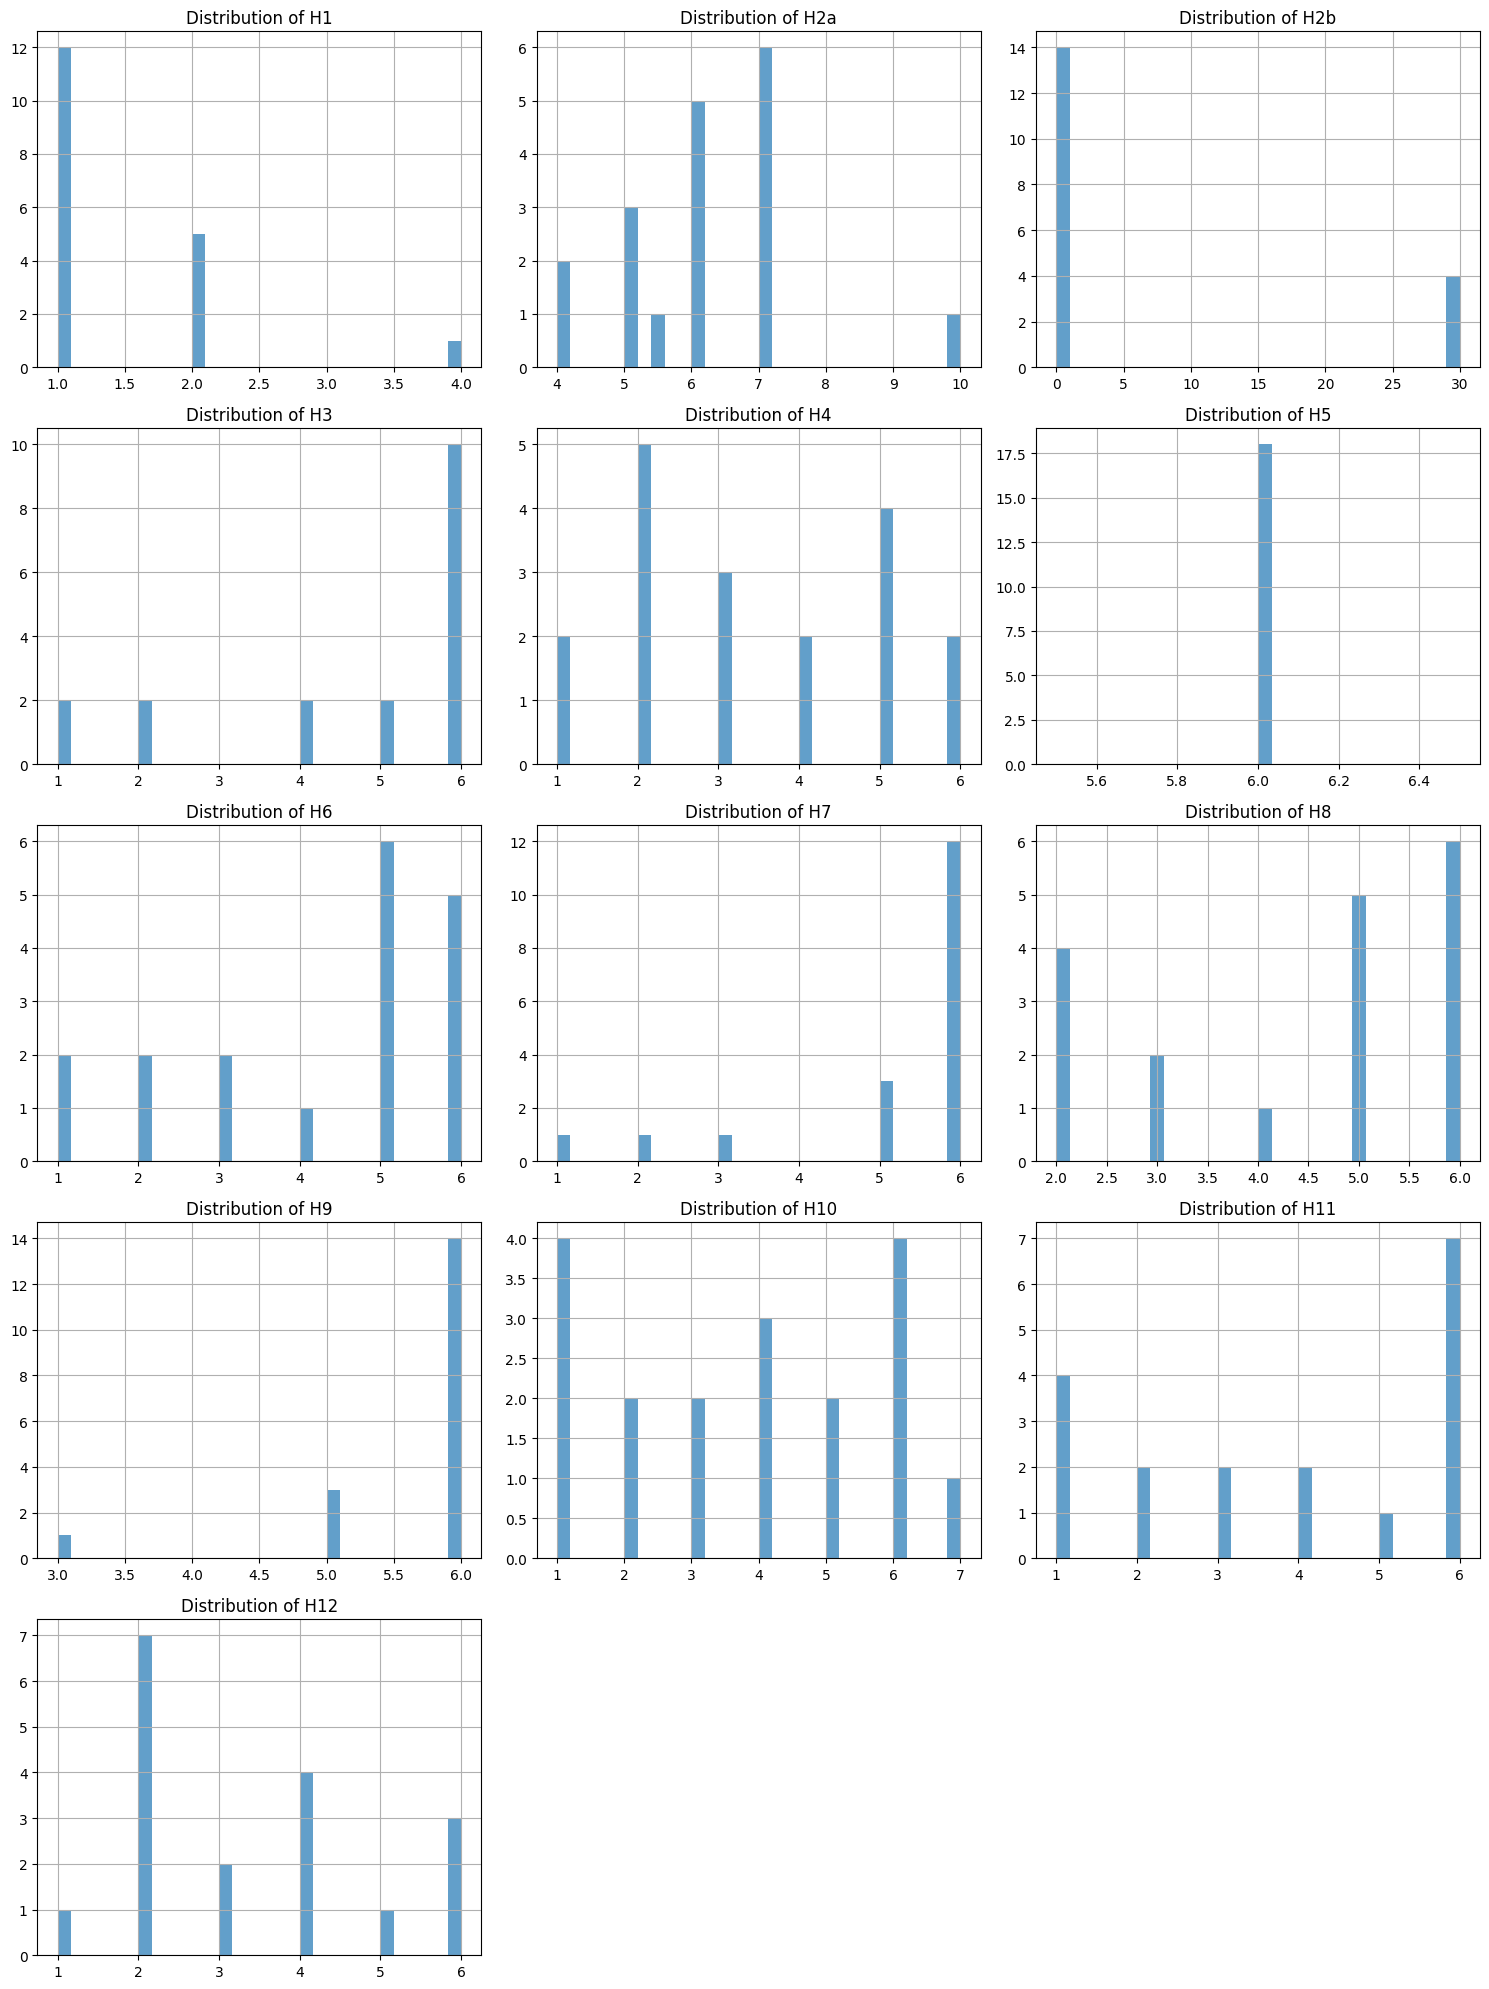

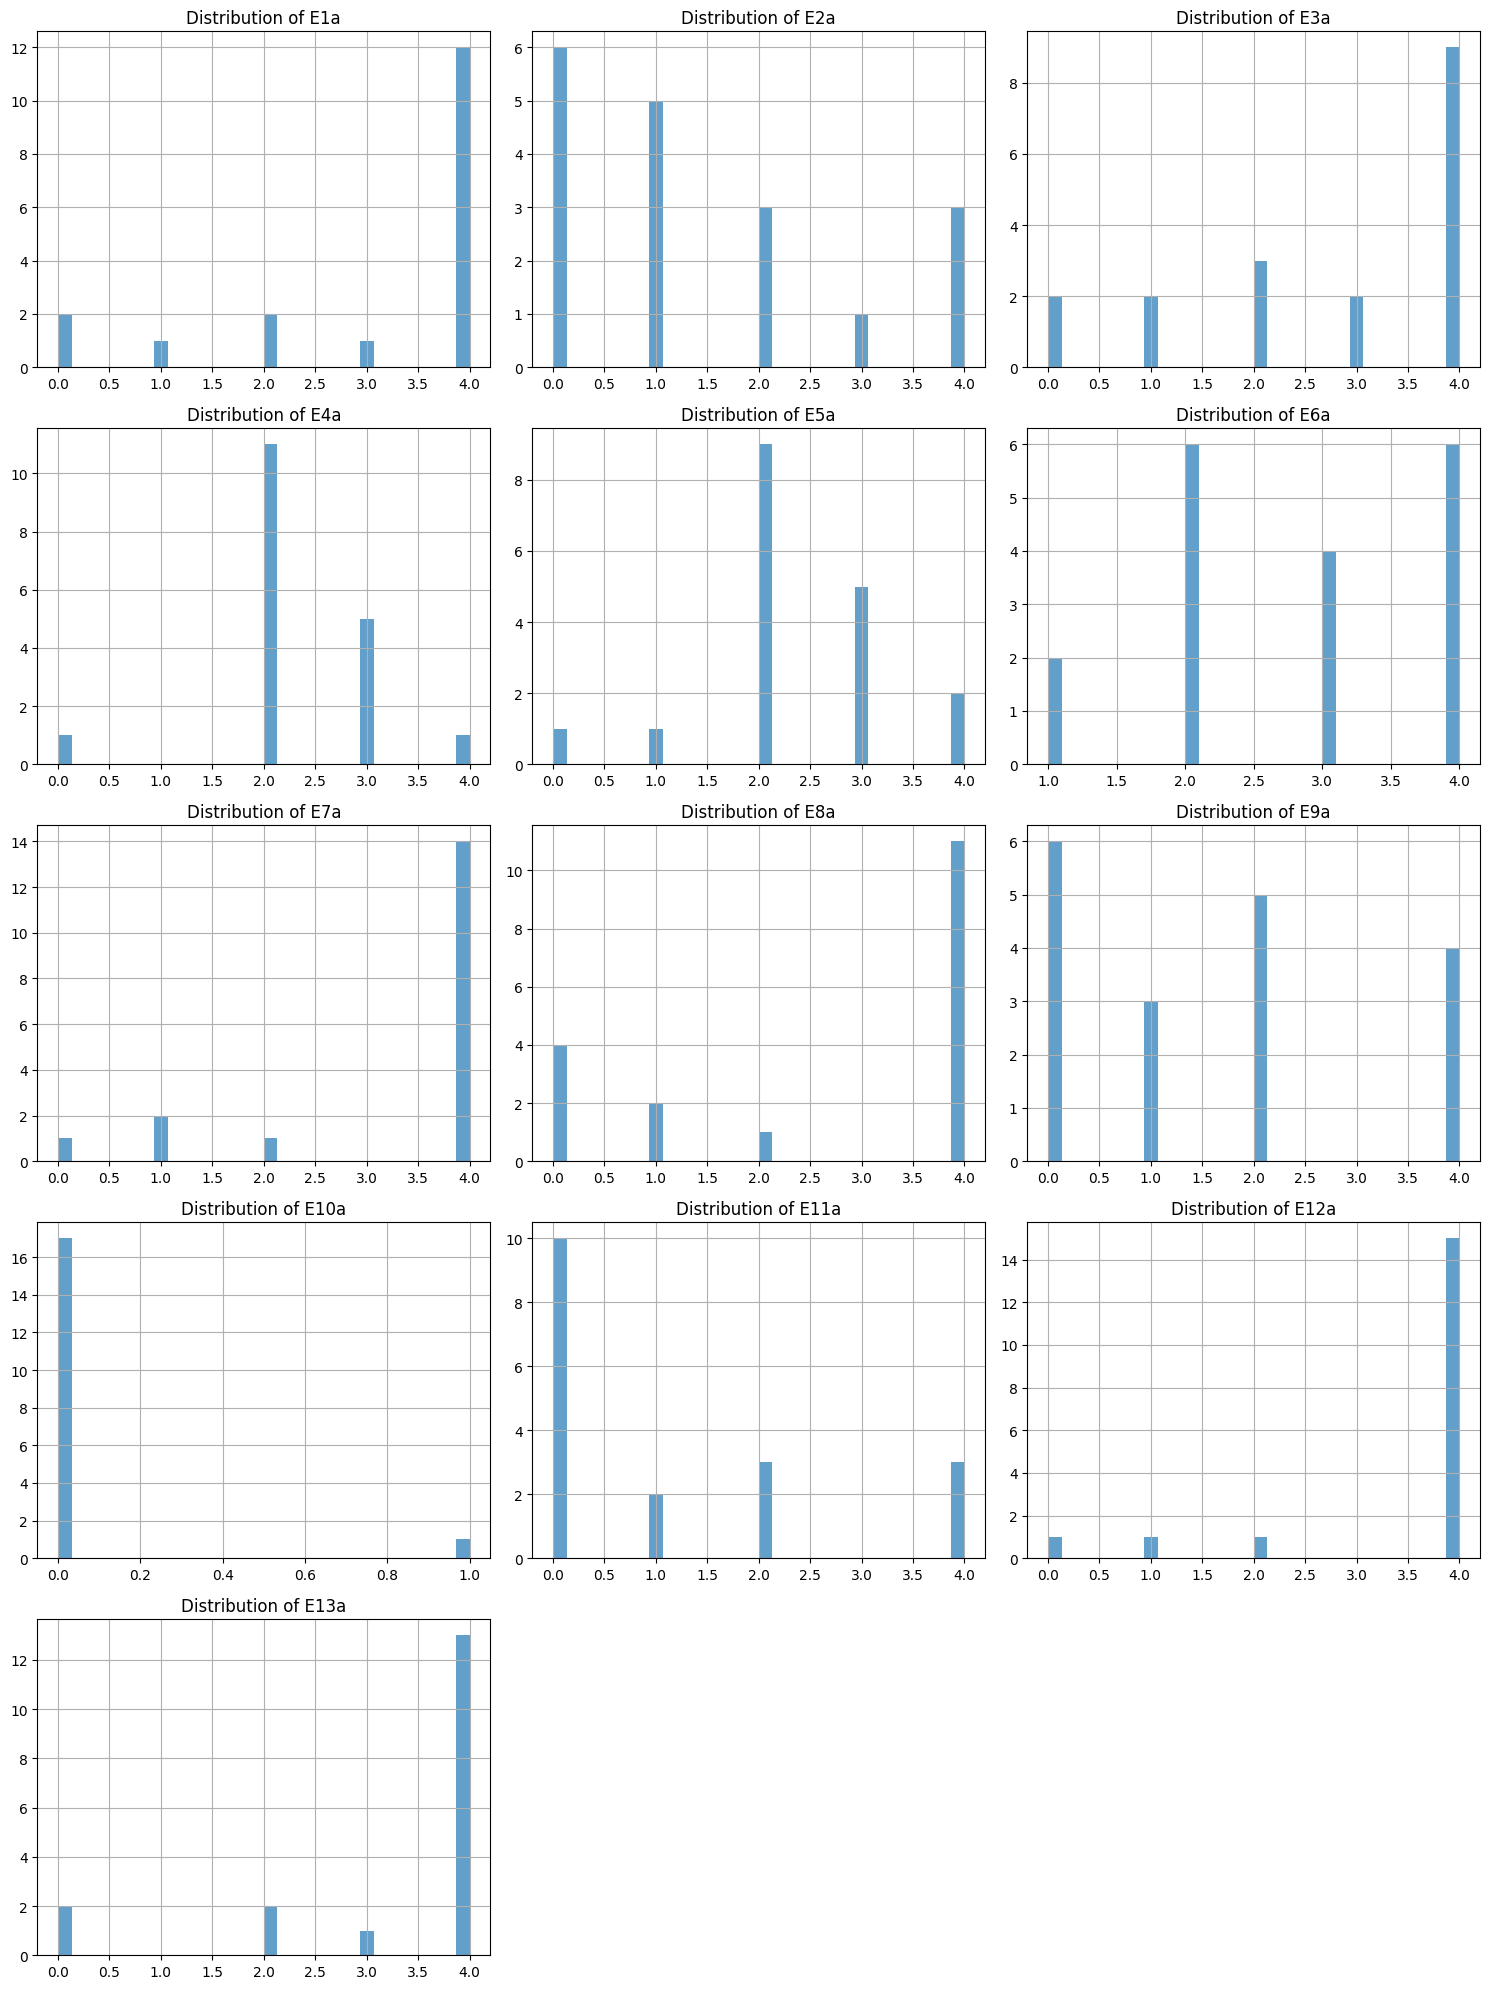

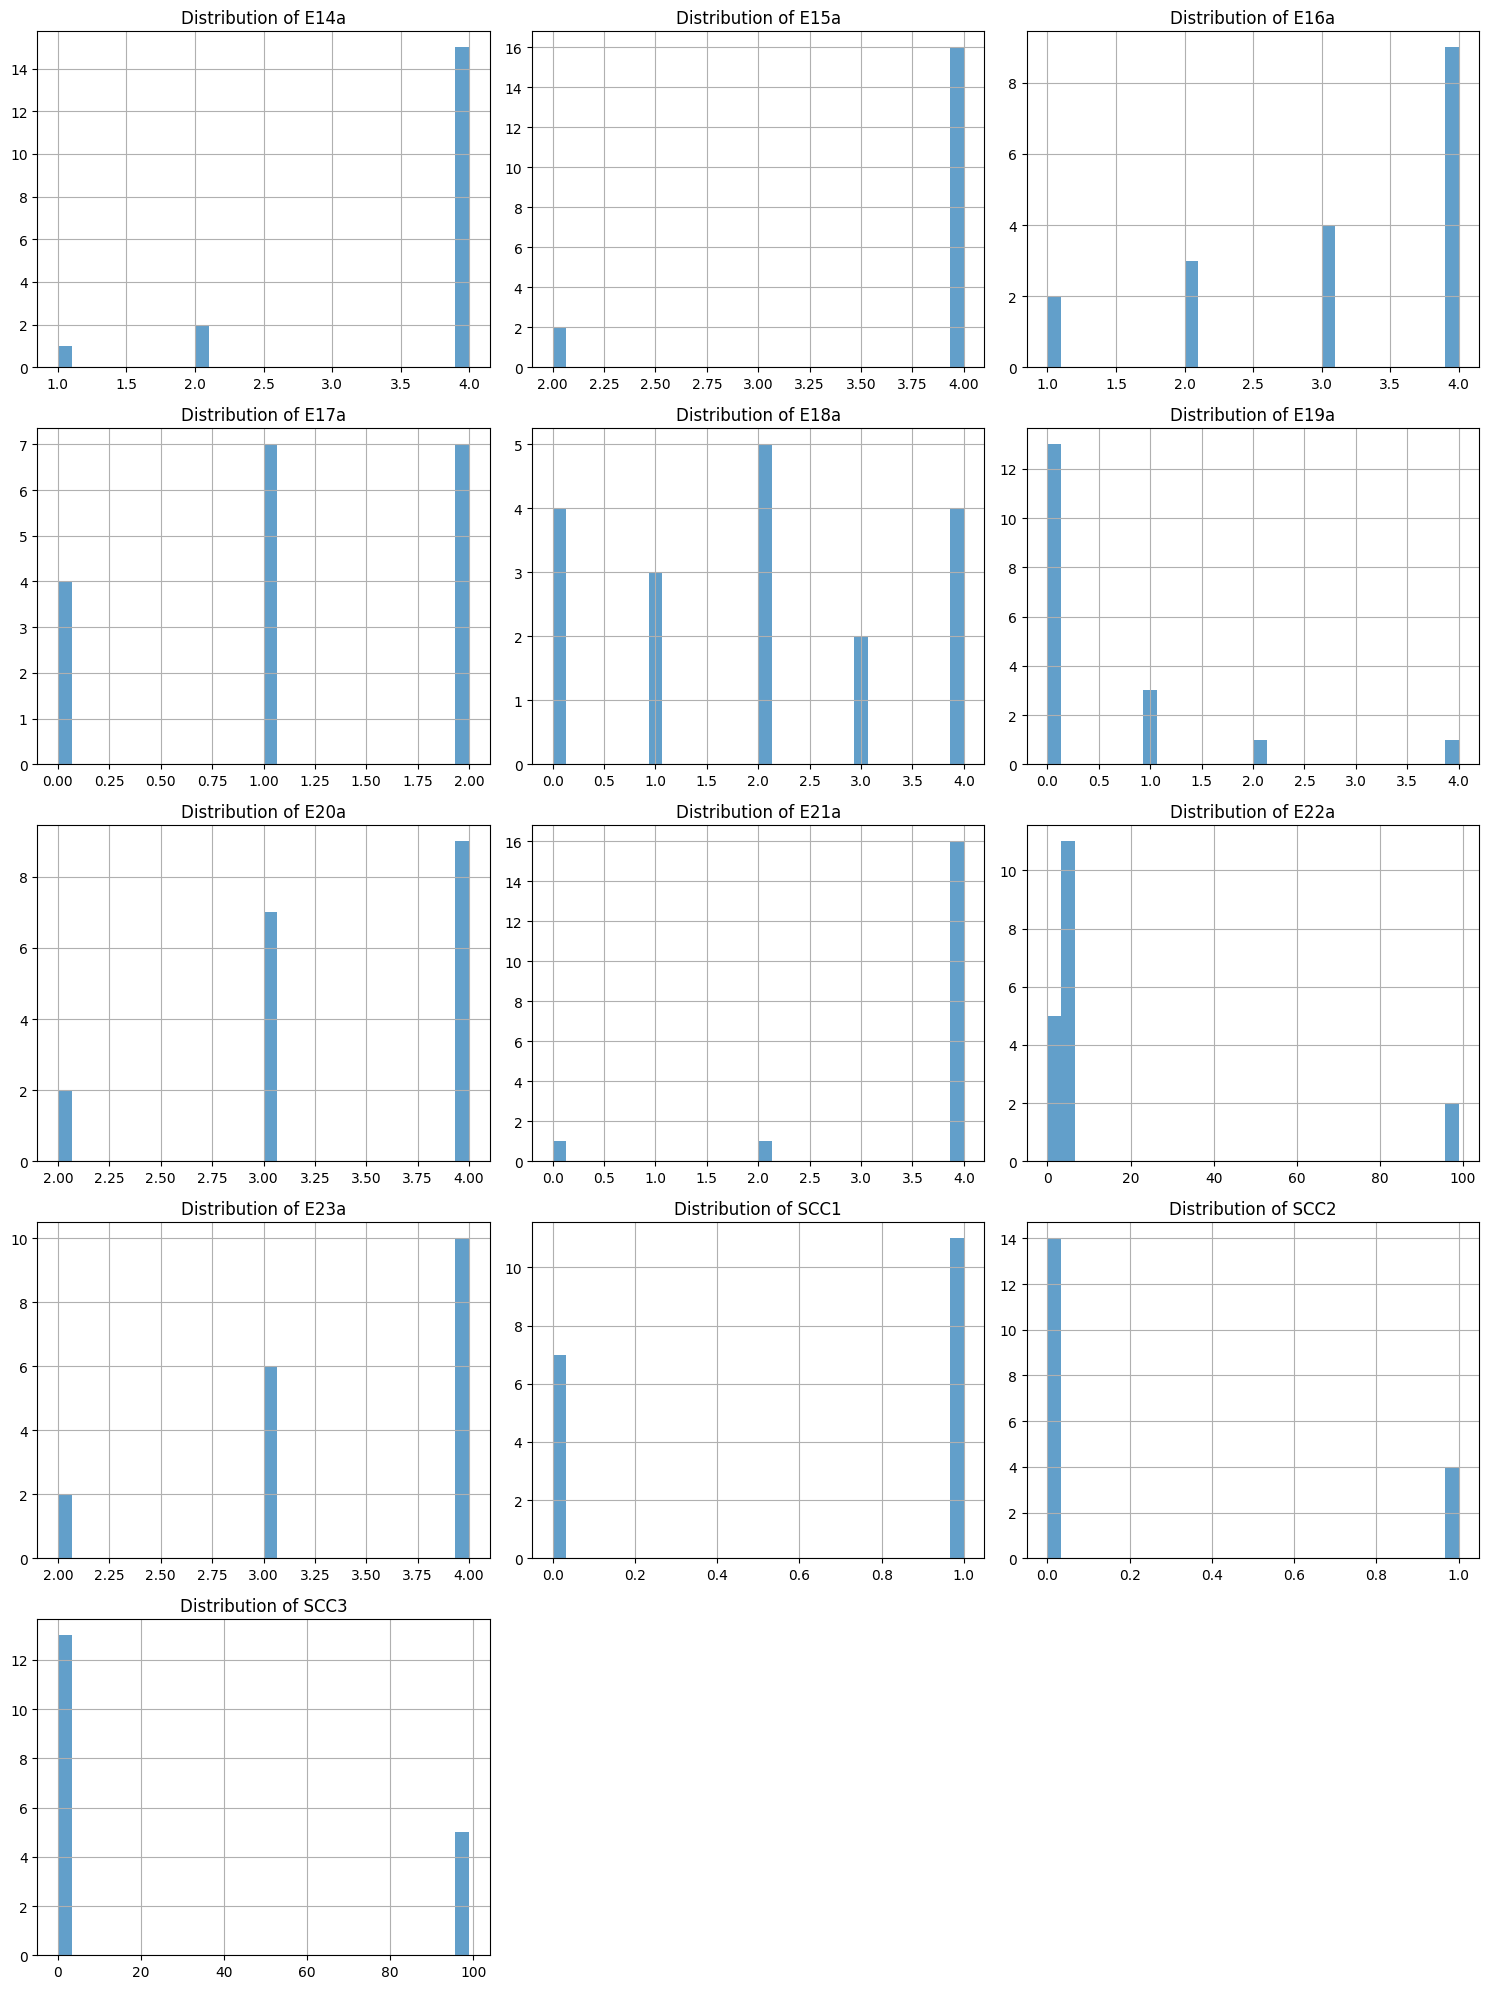

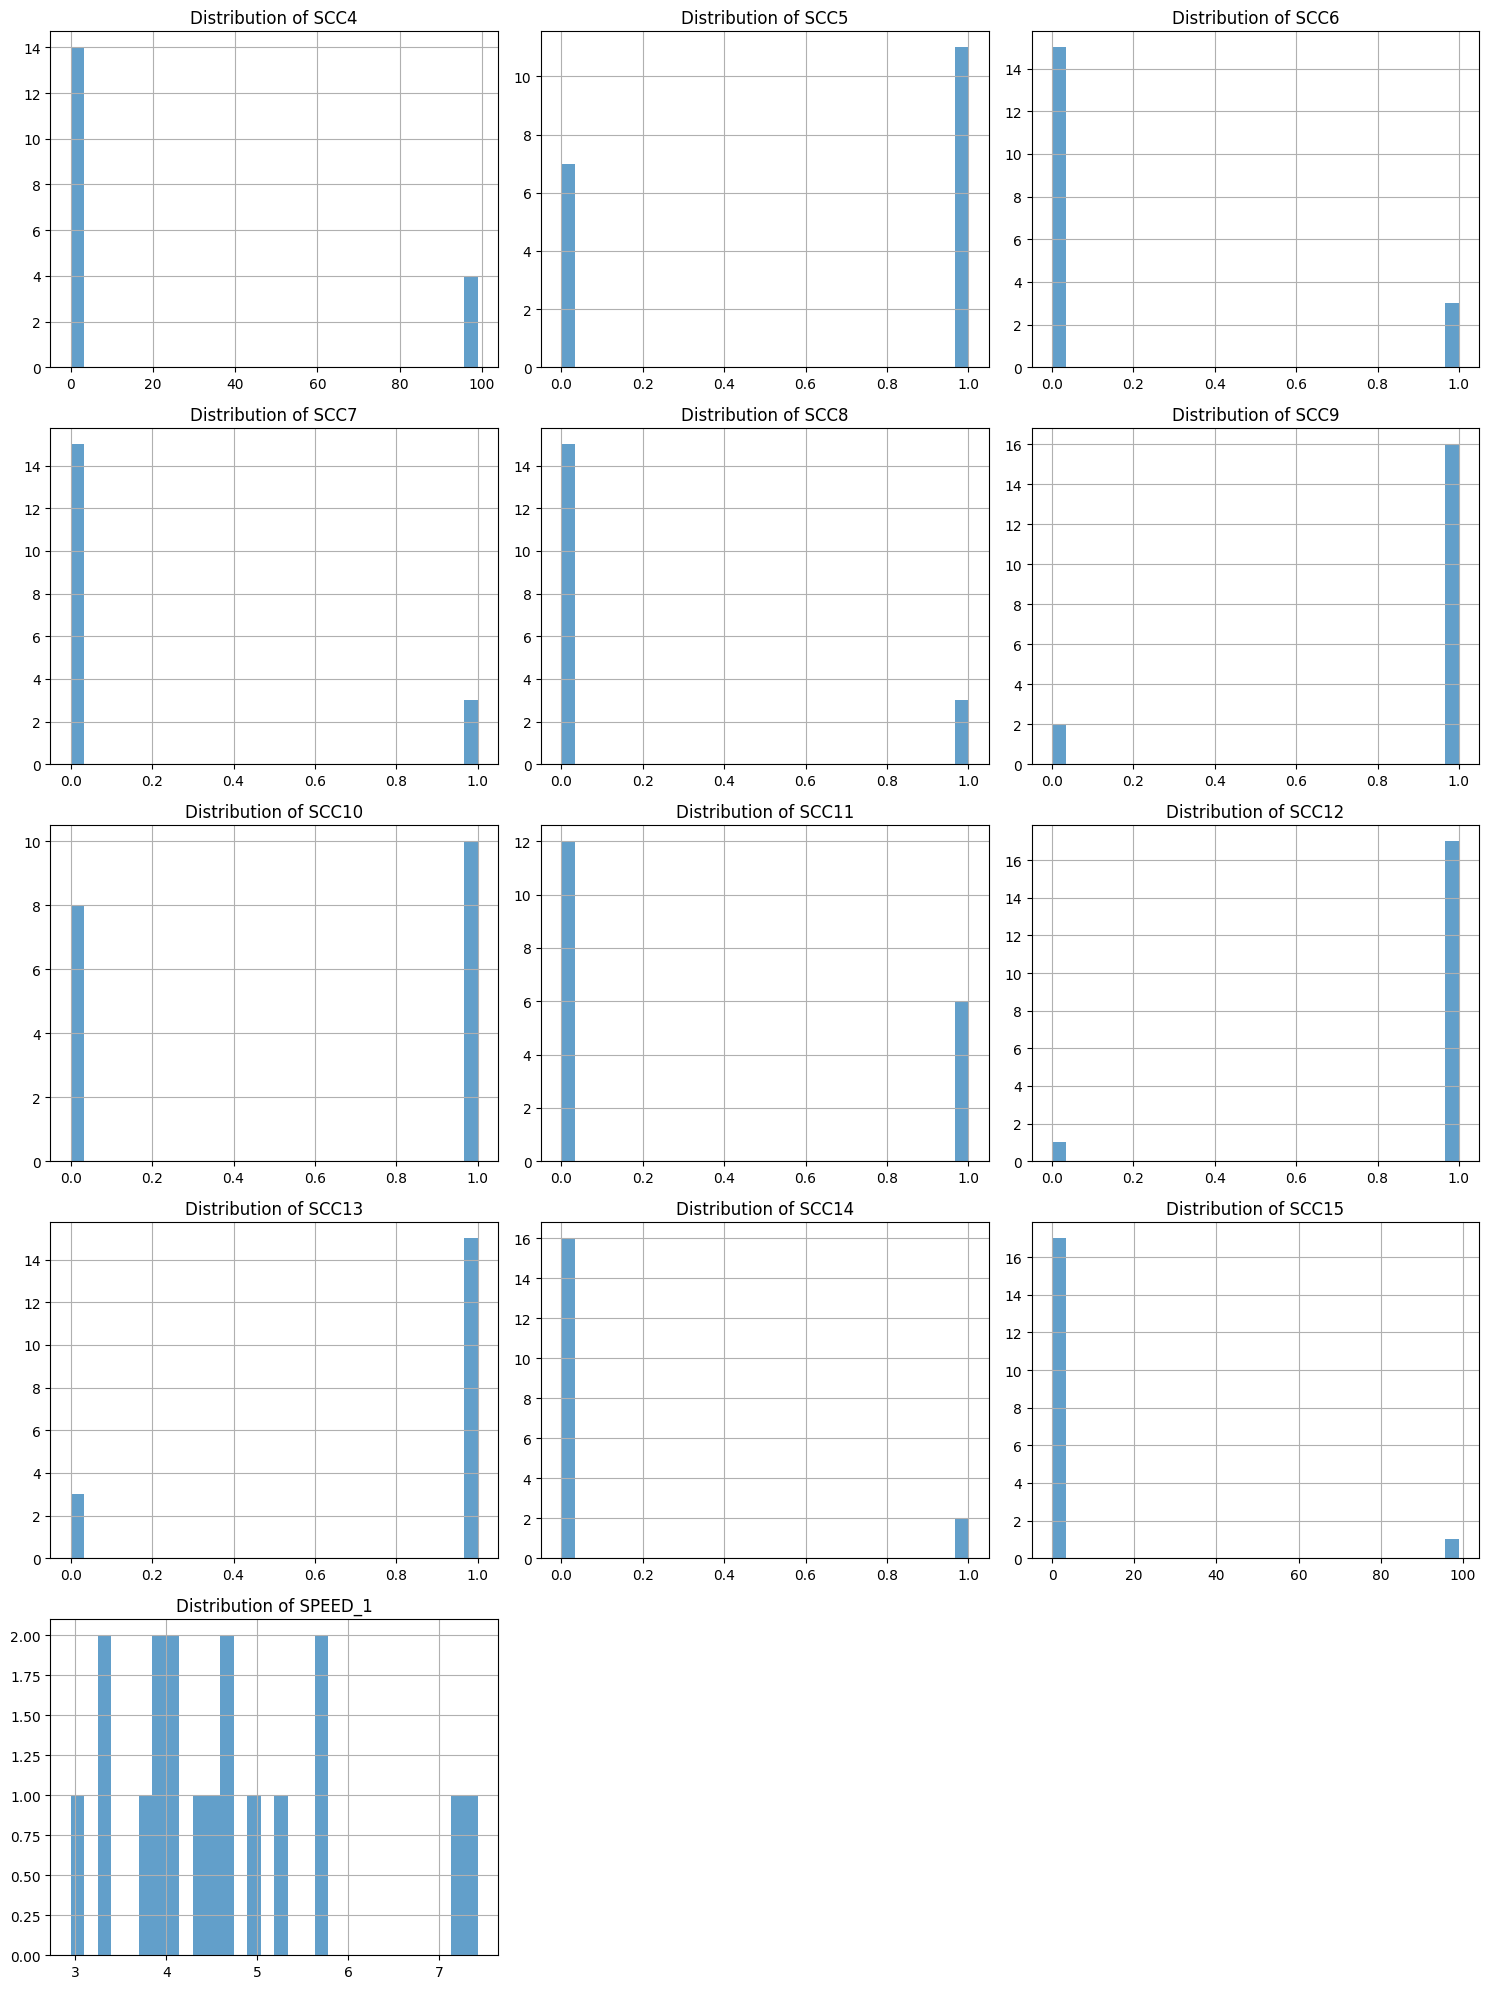

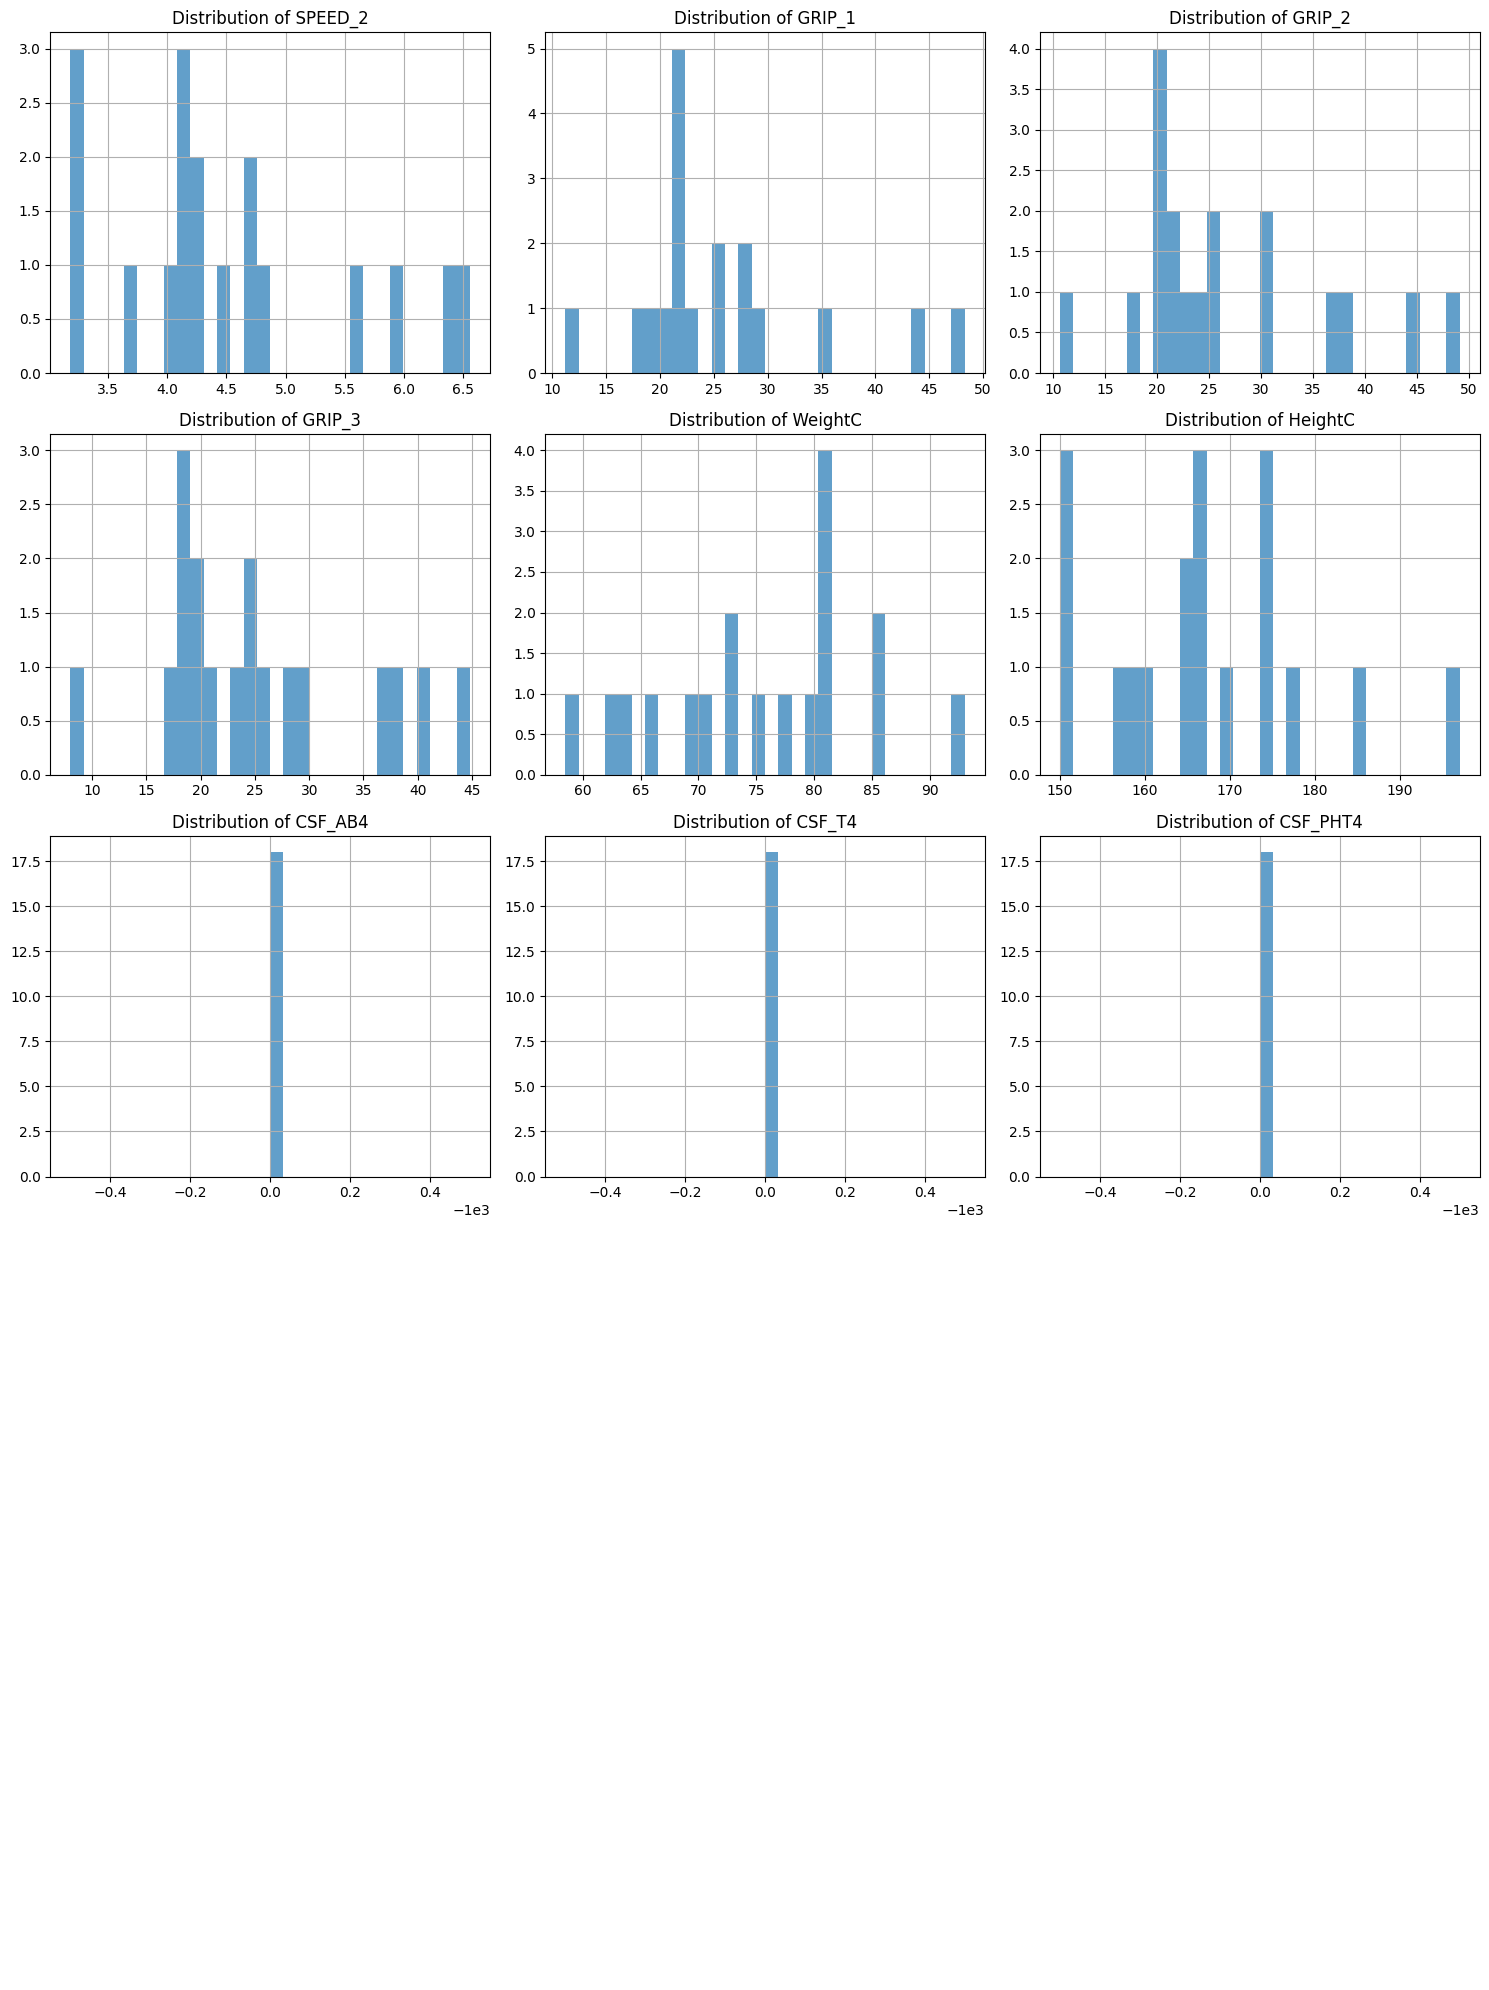

In [175]:
# Set the number of features per figure to 13
features_per_plot = 13
num_features = test_df.shape[1]
num_chunks = (num_features // features_per_plot) + 1

# Loop through features in chunks
for chunk in range(num_chunks):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows and 3 columns for 13 plots (1 will be empty)
    axes = axes.ravel()

    start_idx = chunk * features_per_plot
    end_idx = min((chunk + 1) * features_per_plot, num_features)

    for i, feature in enumerate(test_df.columns[start_idx:end_idx]):
        test_df[feature].hist(ax=axes[i], bins=30, alpha=0.7)
        axes[i].set_title(f'Distribution of {feature}')
    
    # Hide any extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

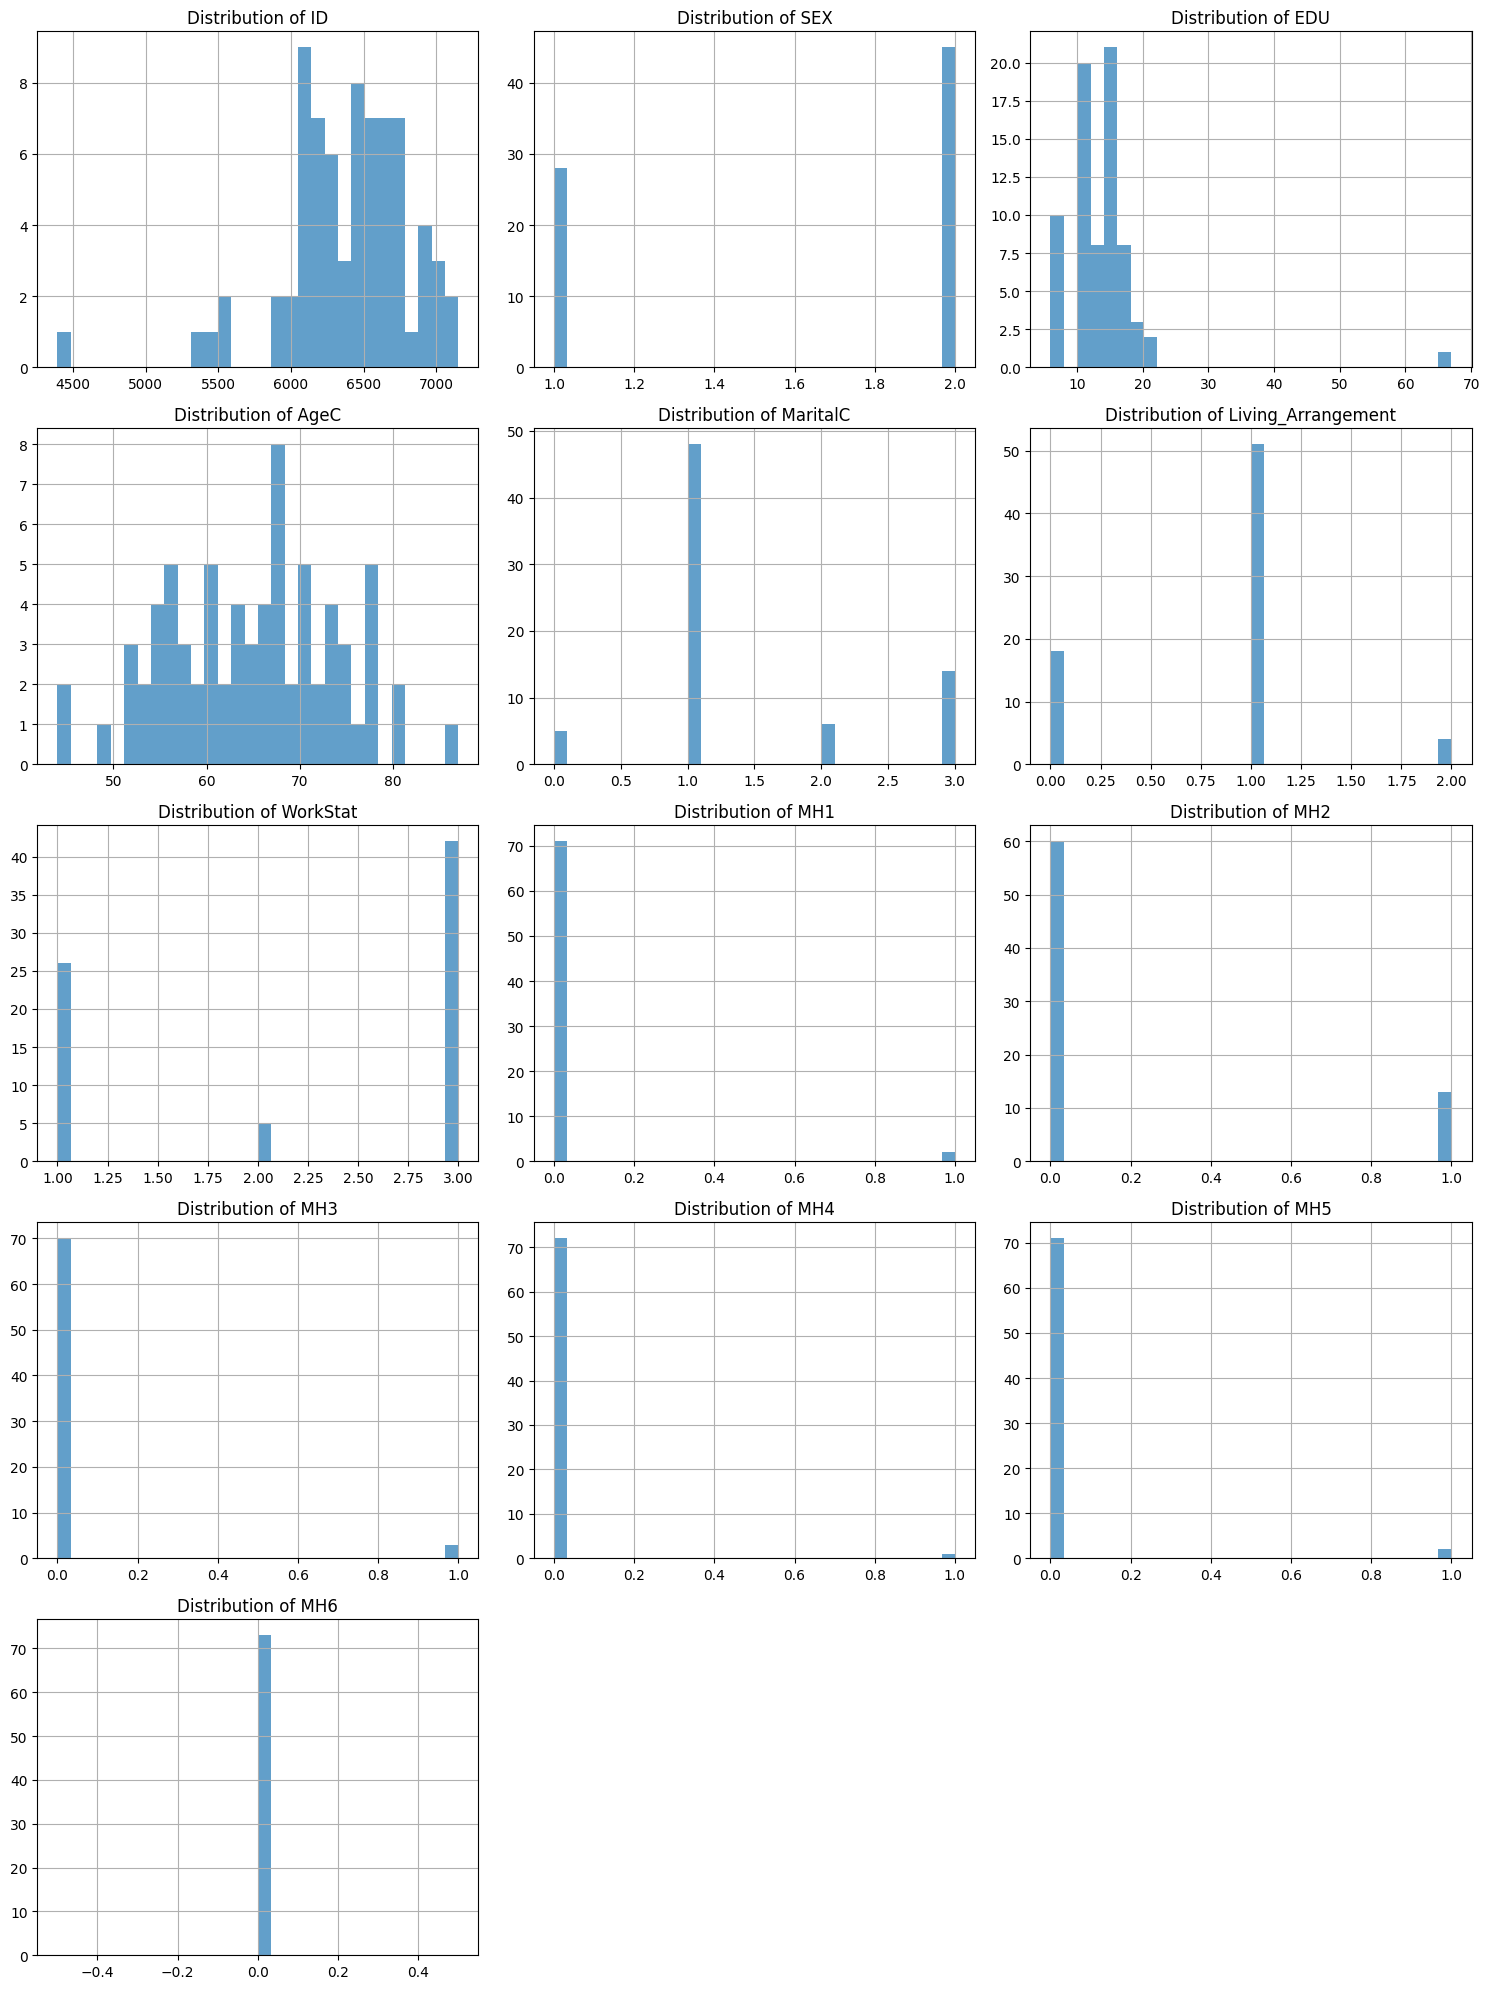

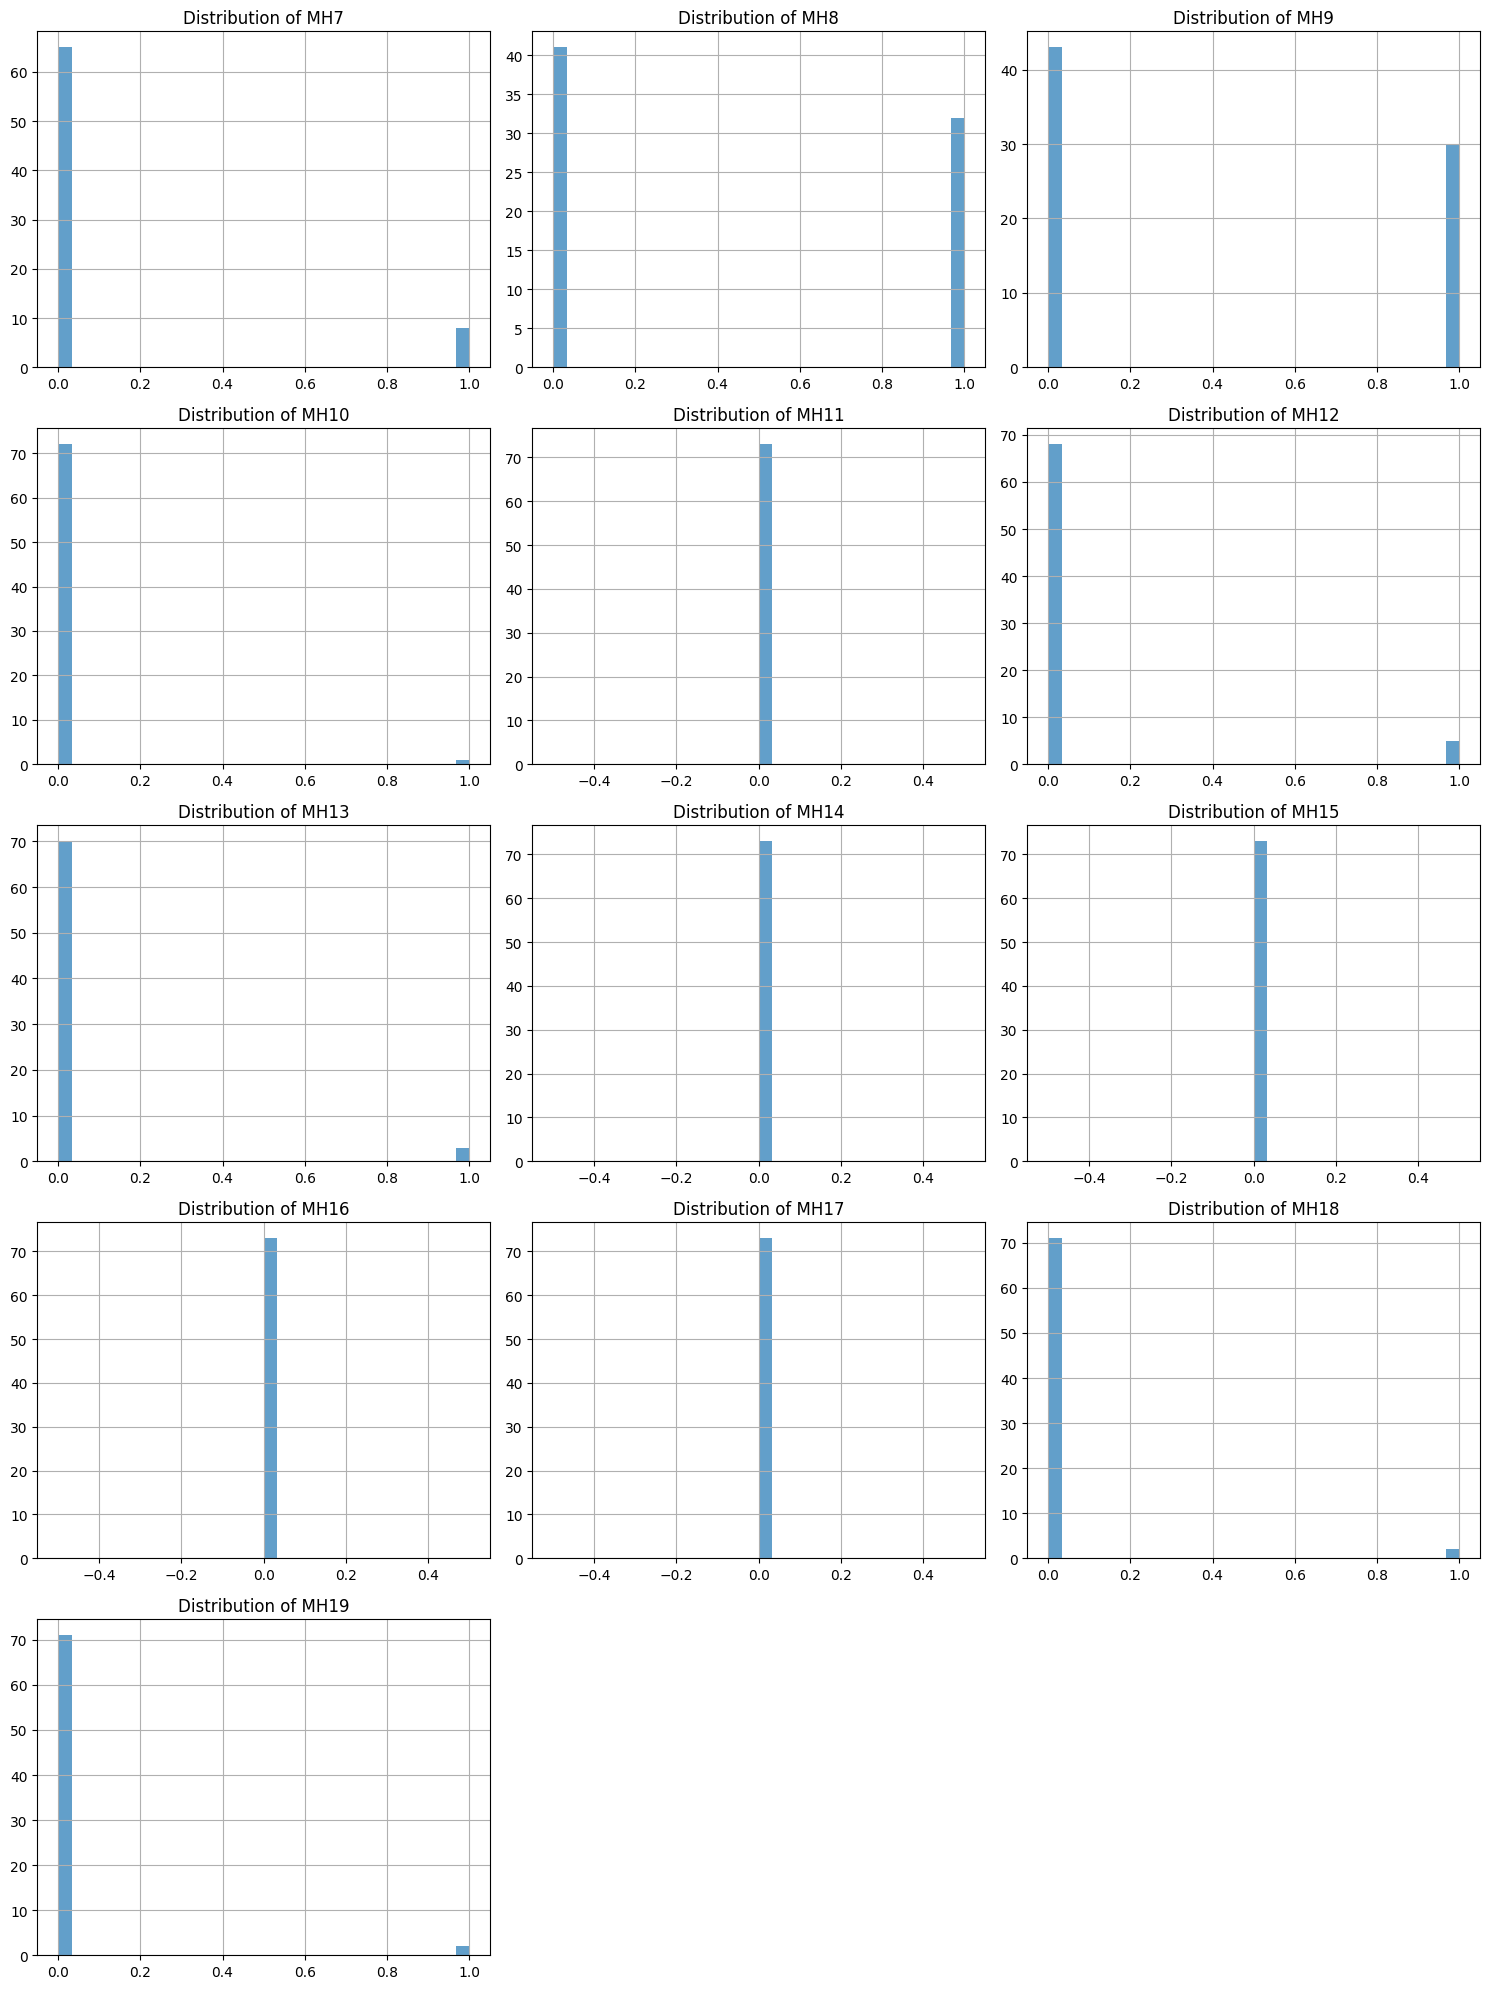

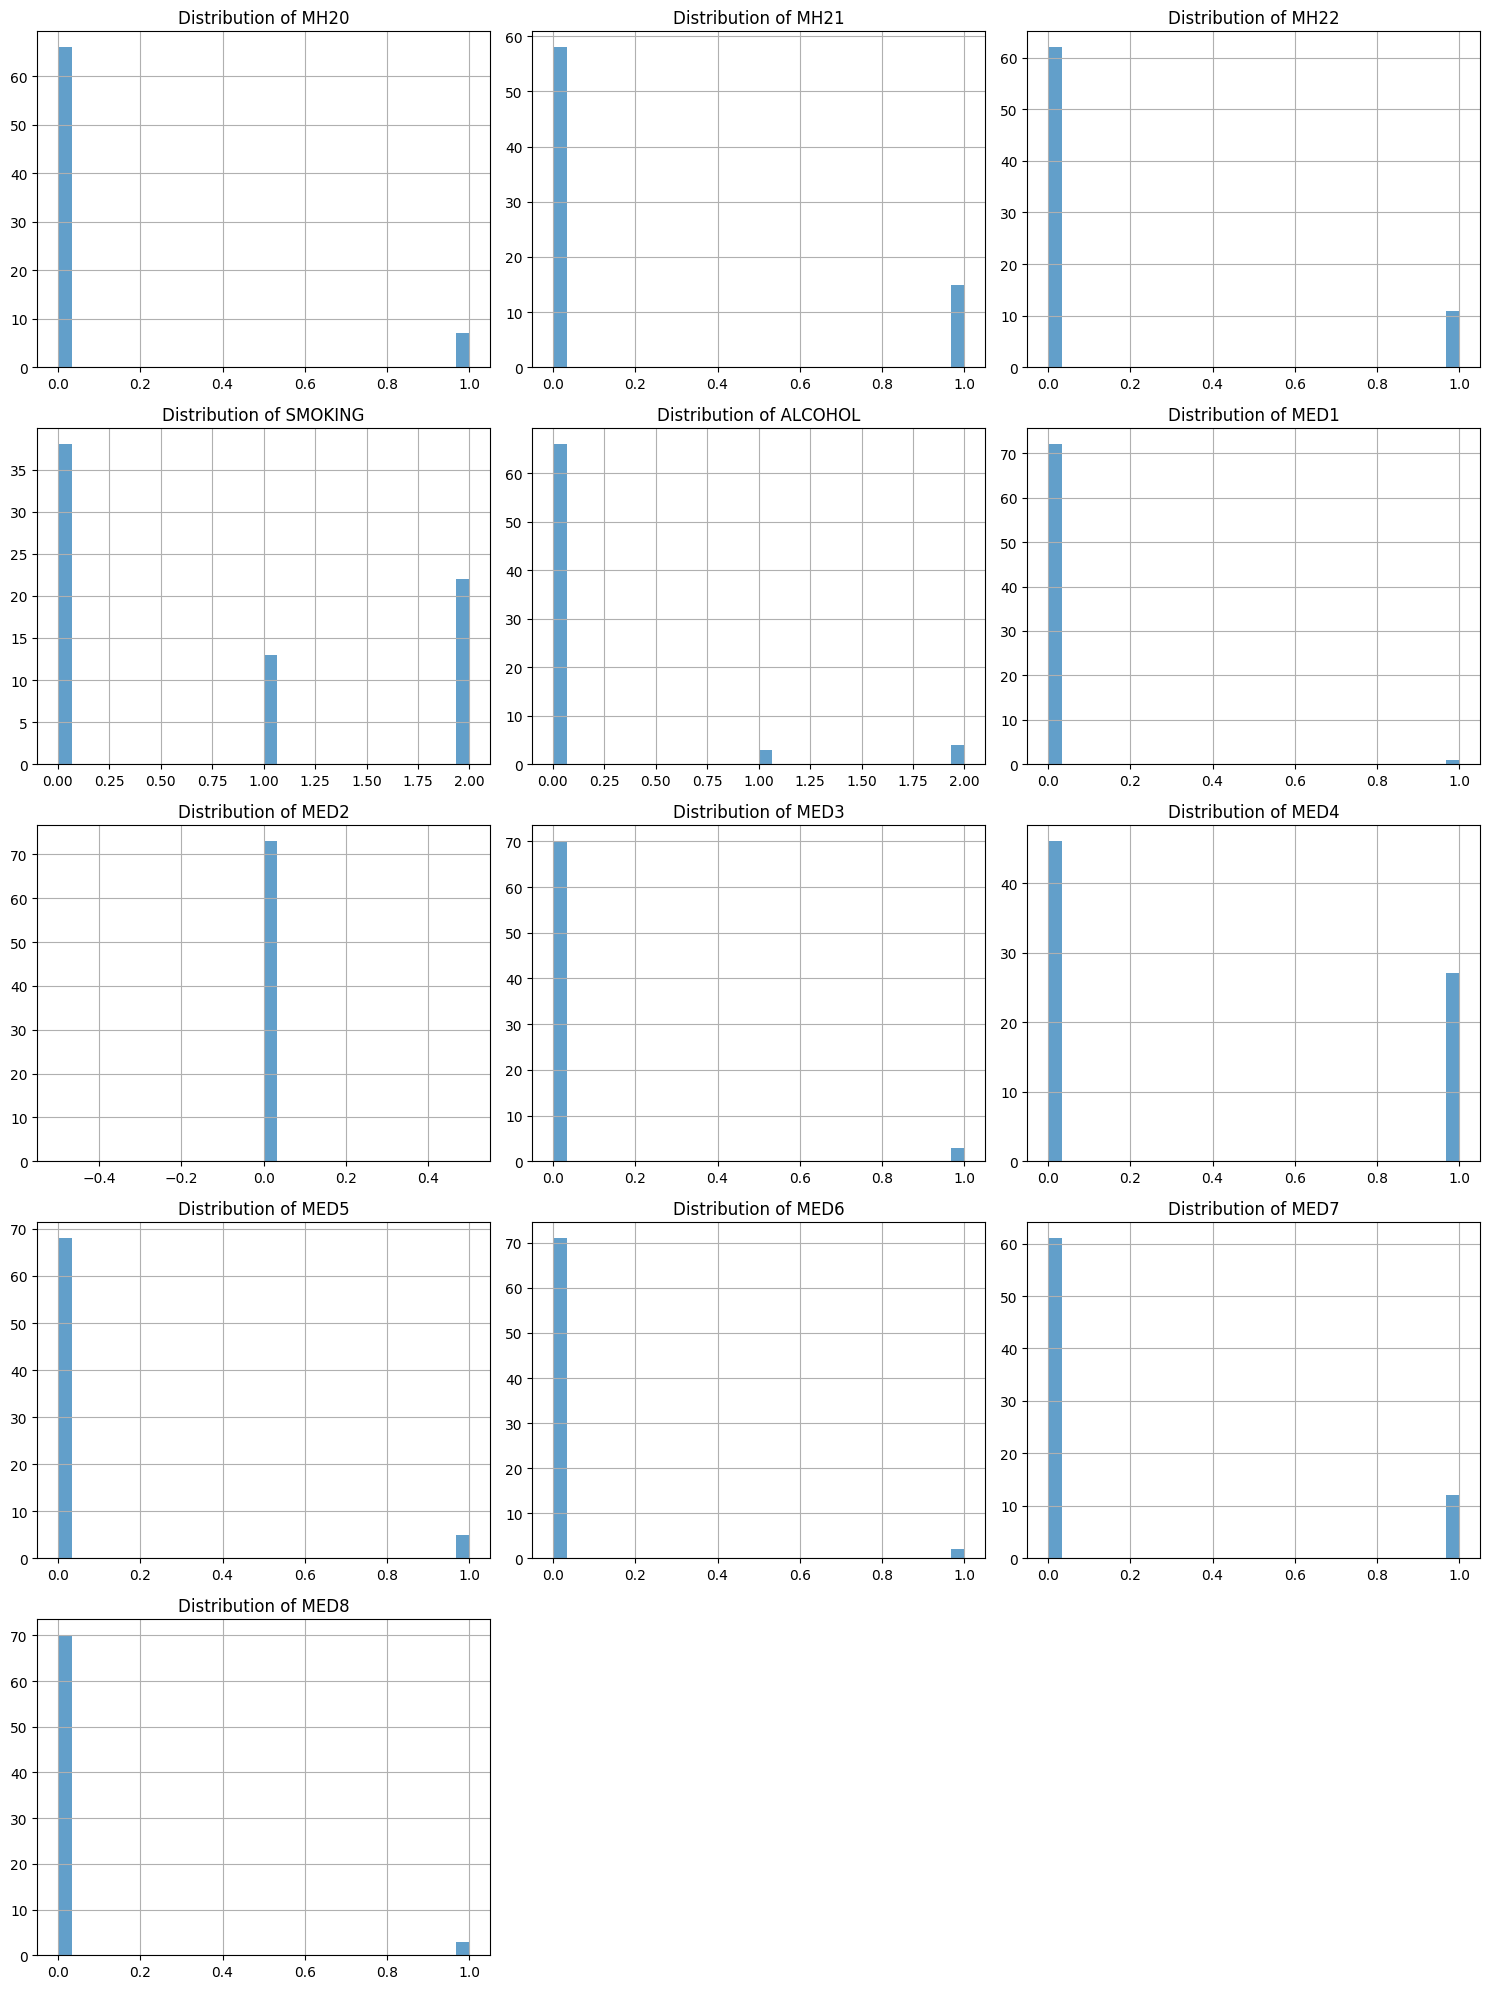

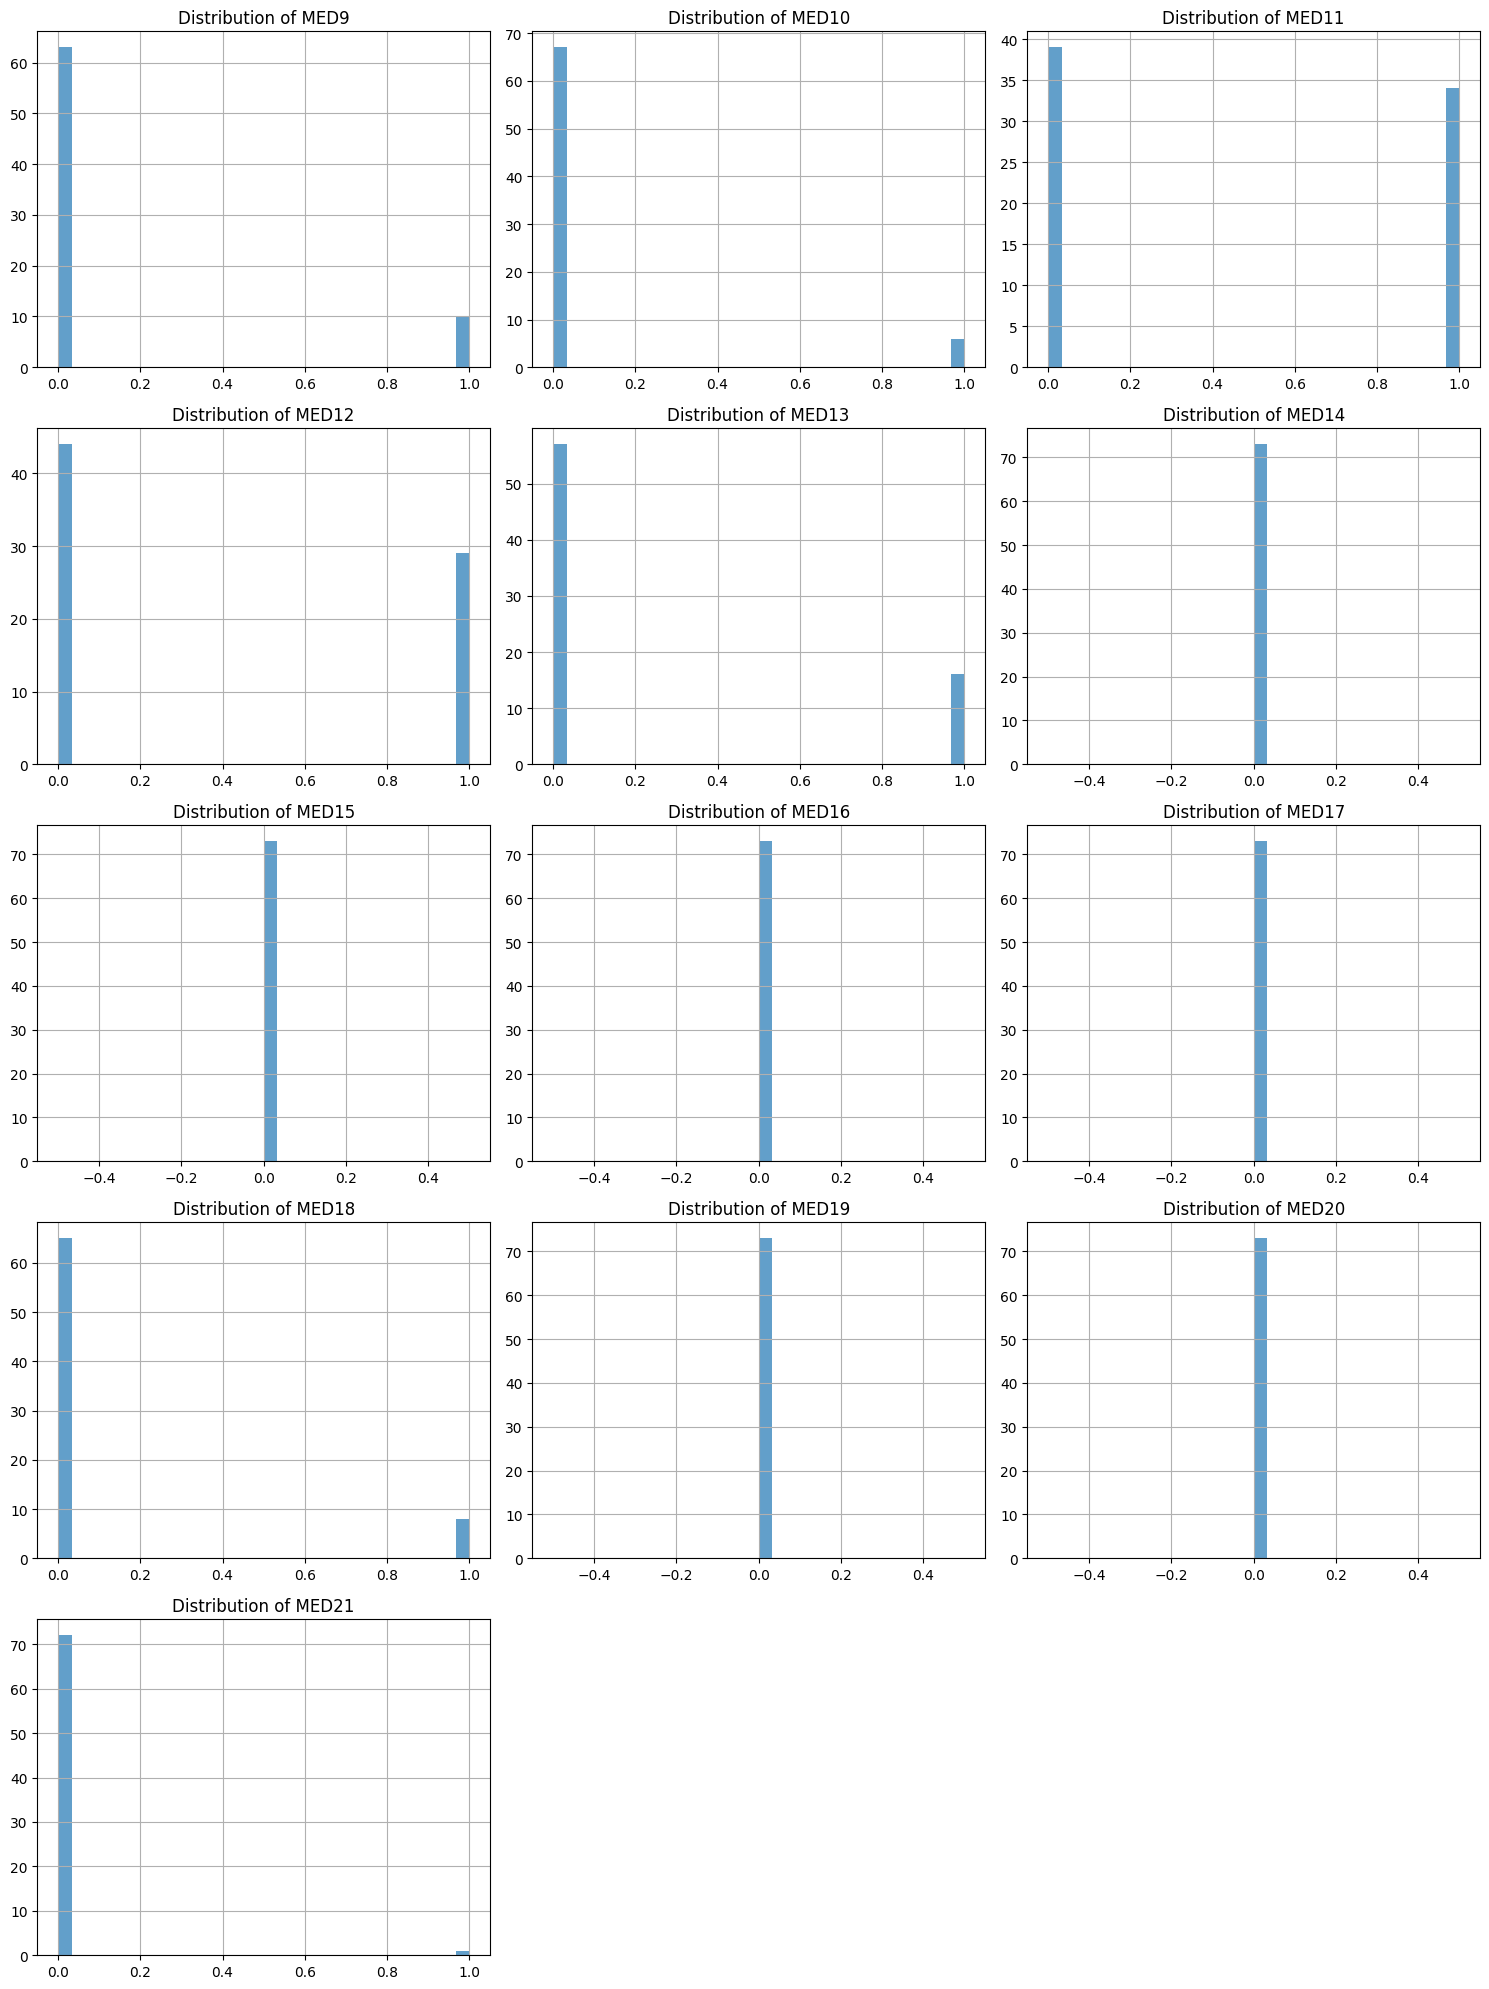

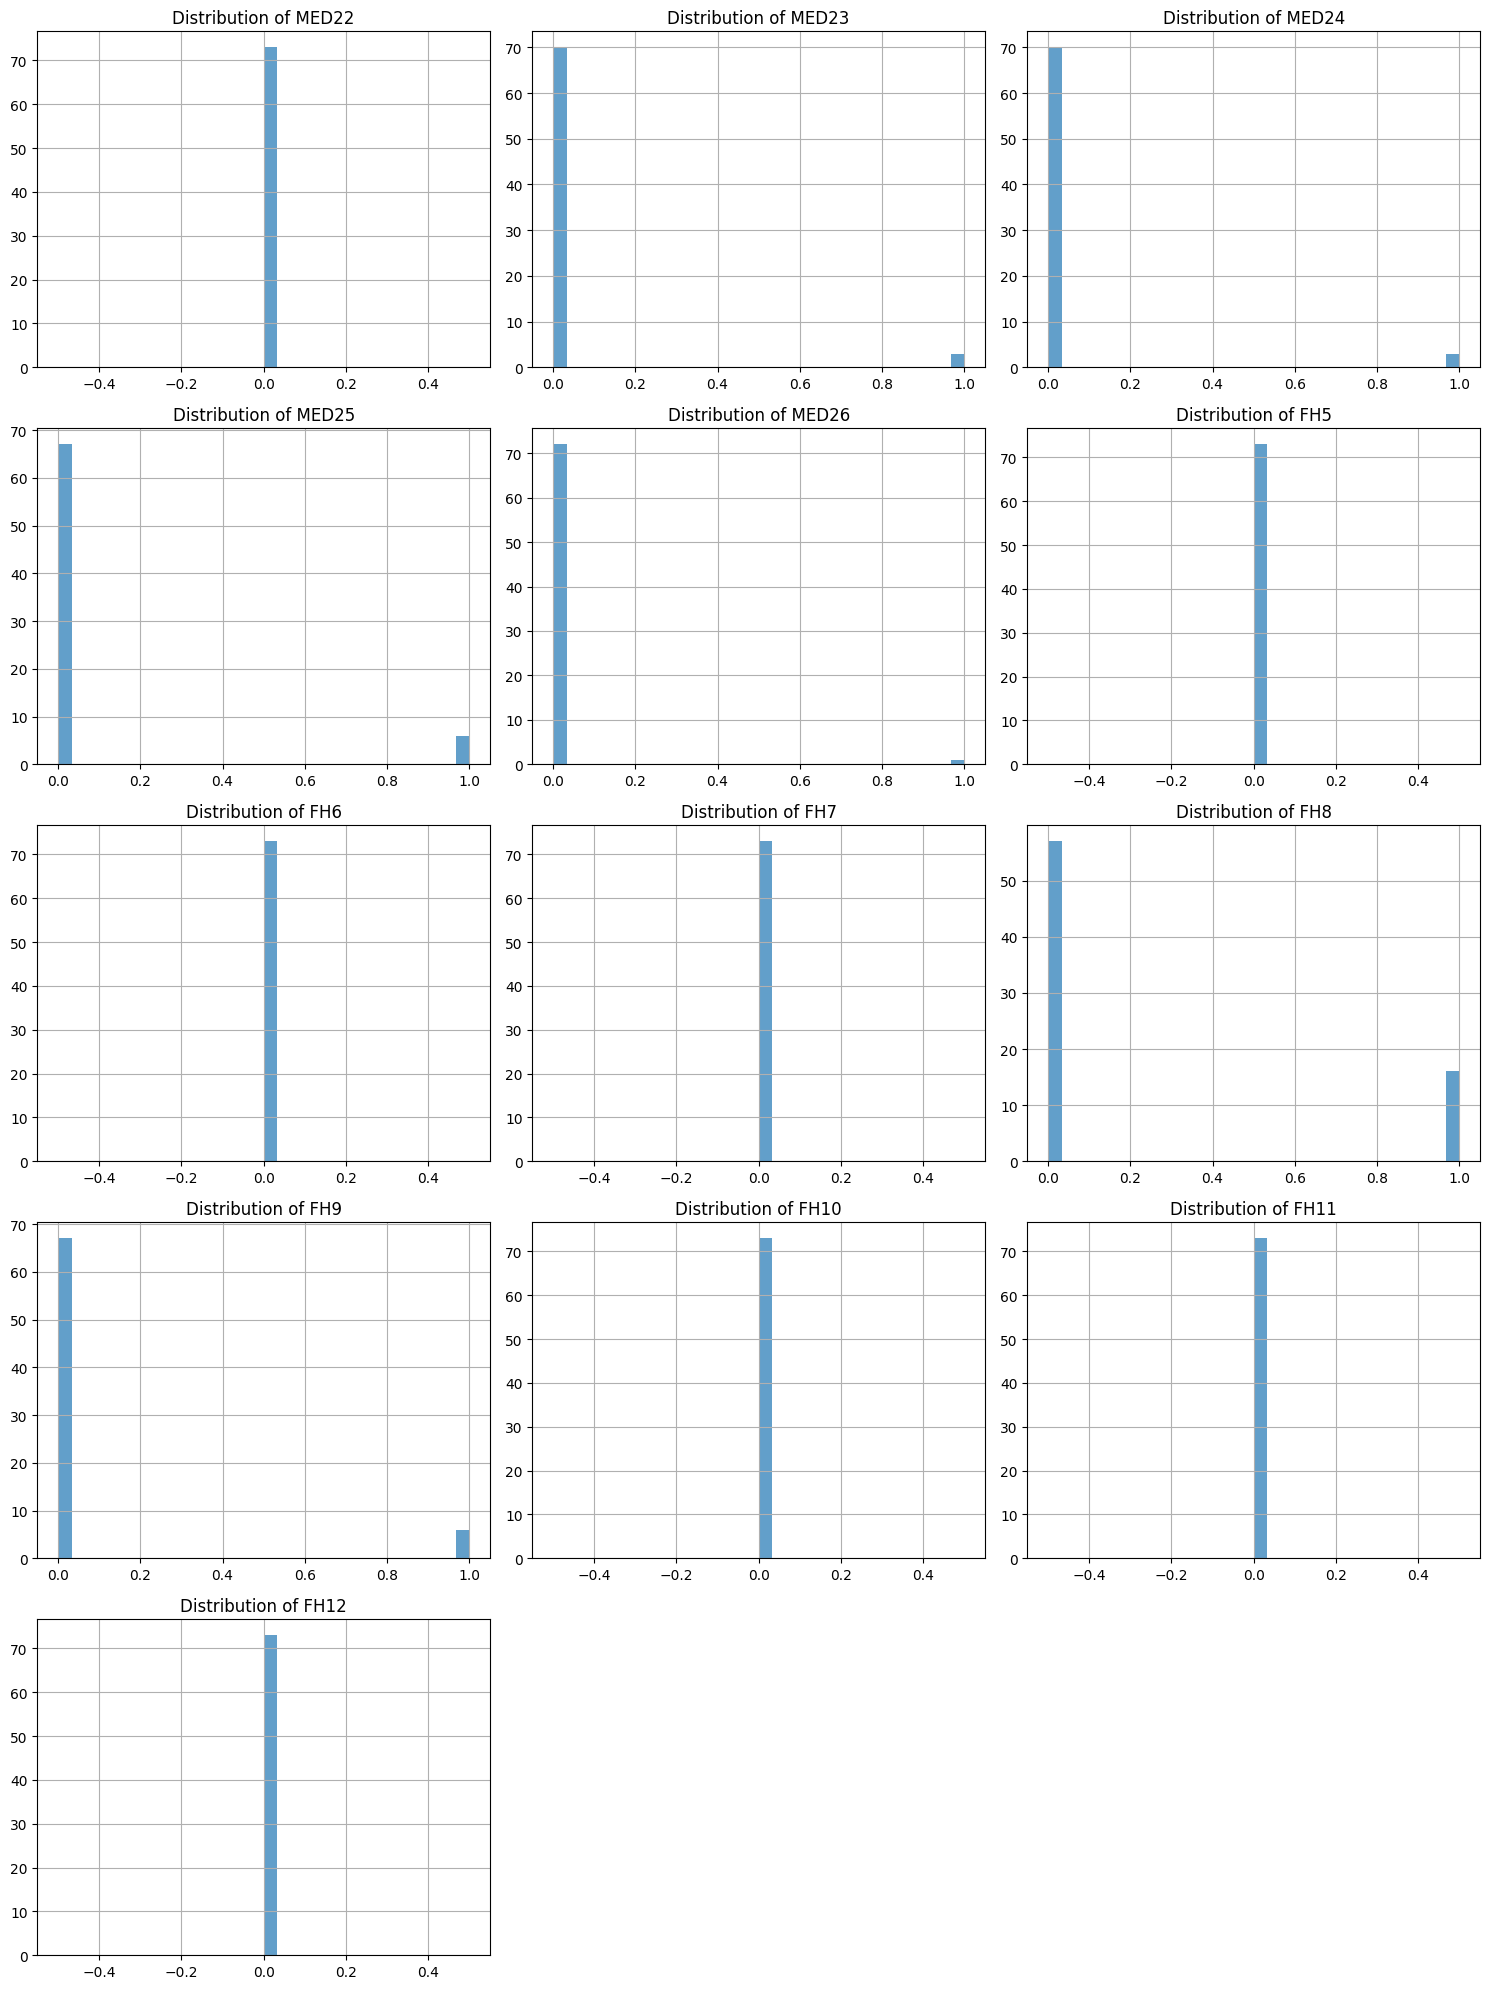

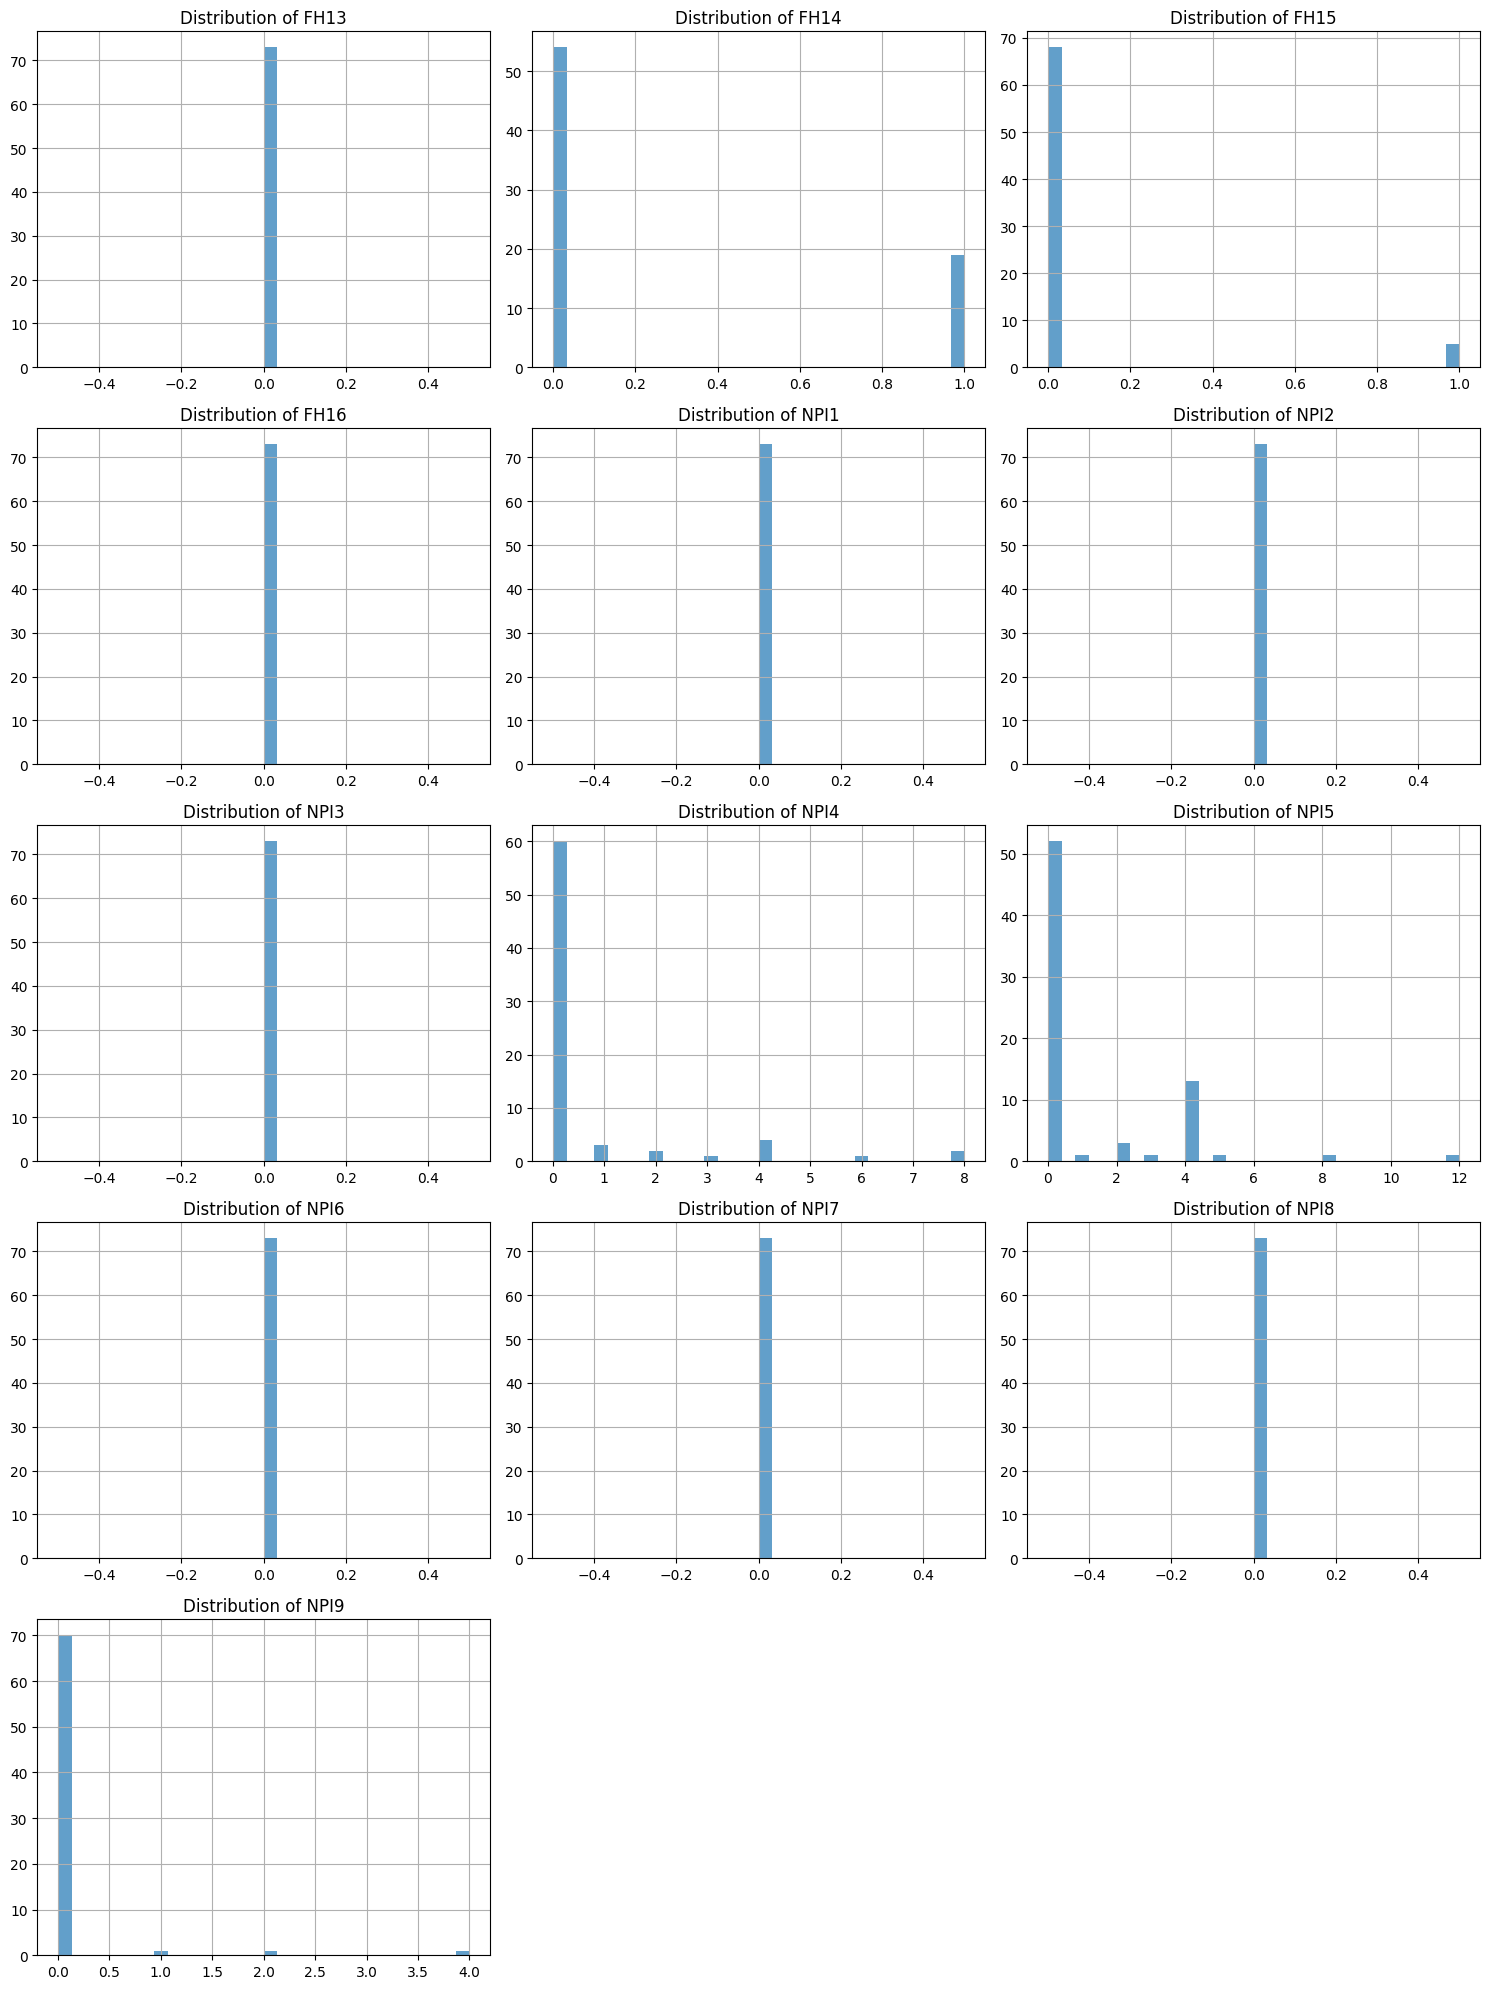

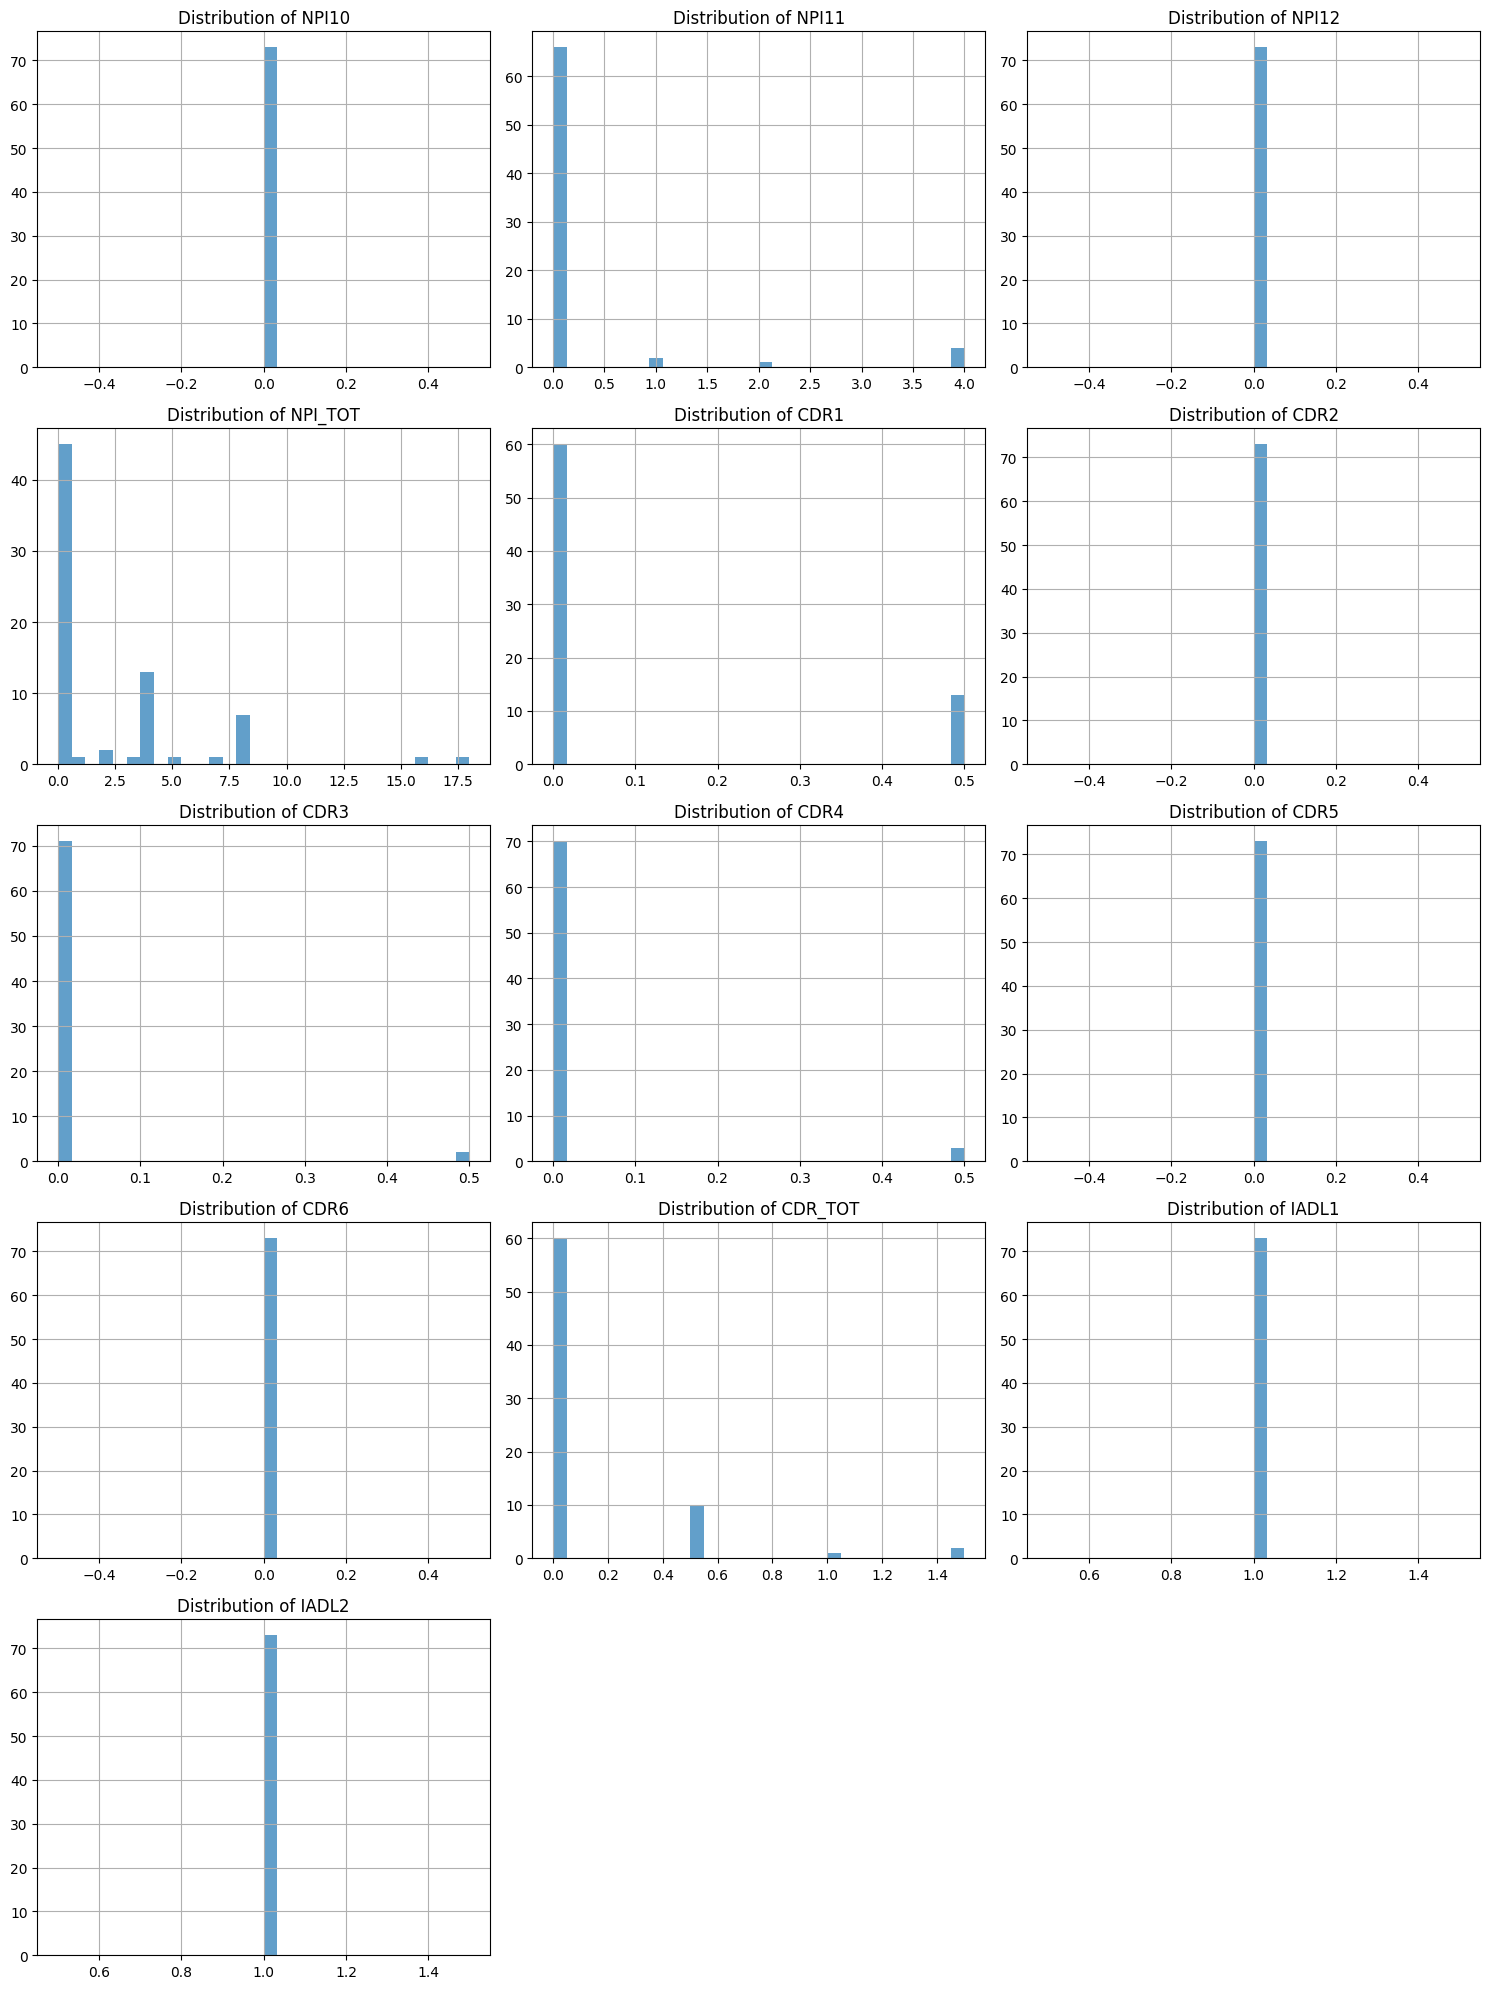

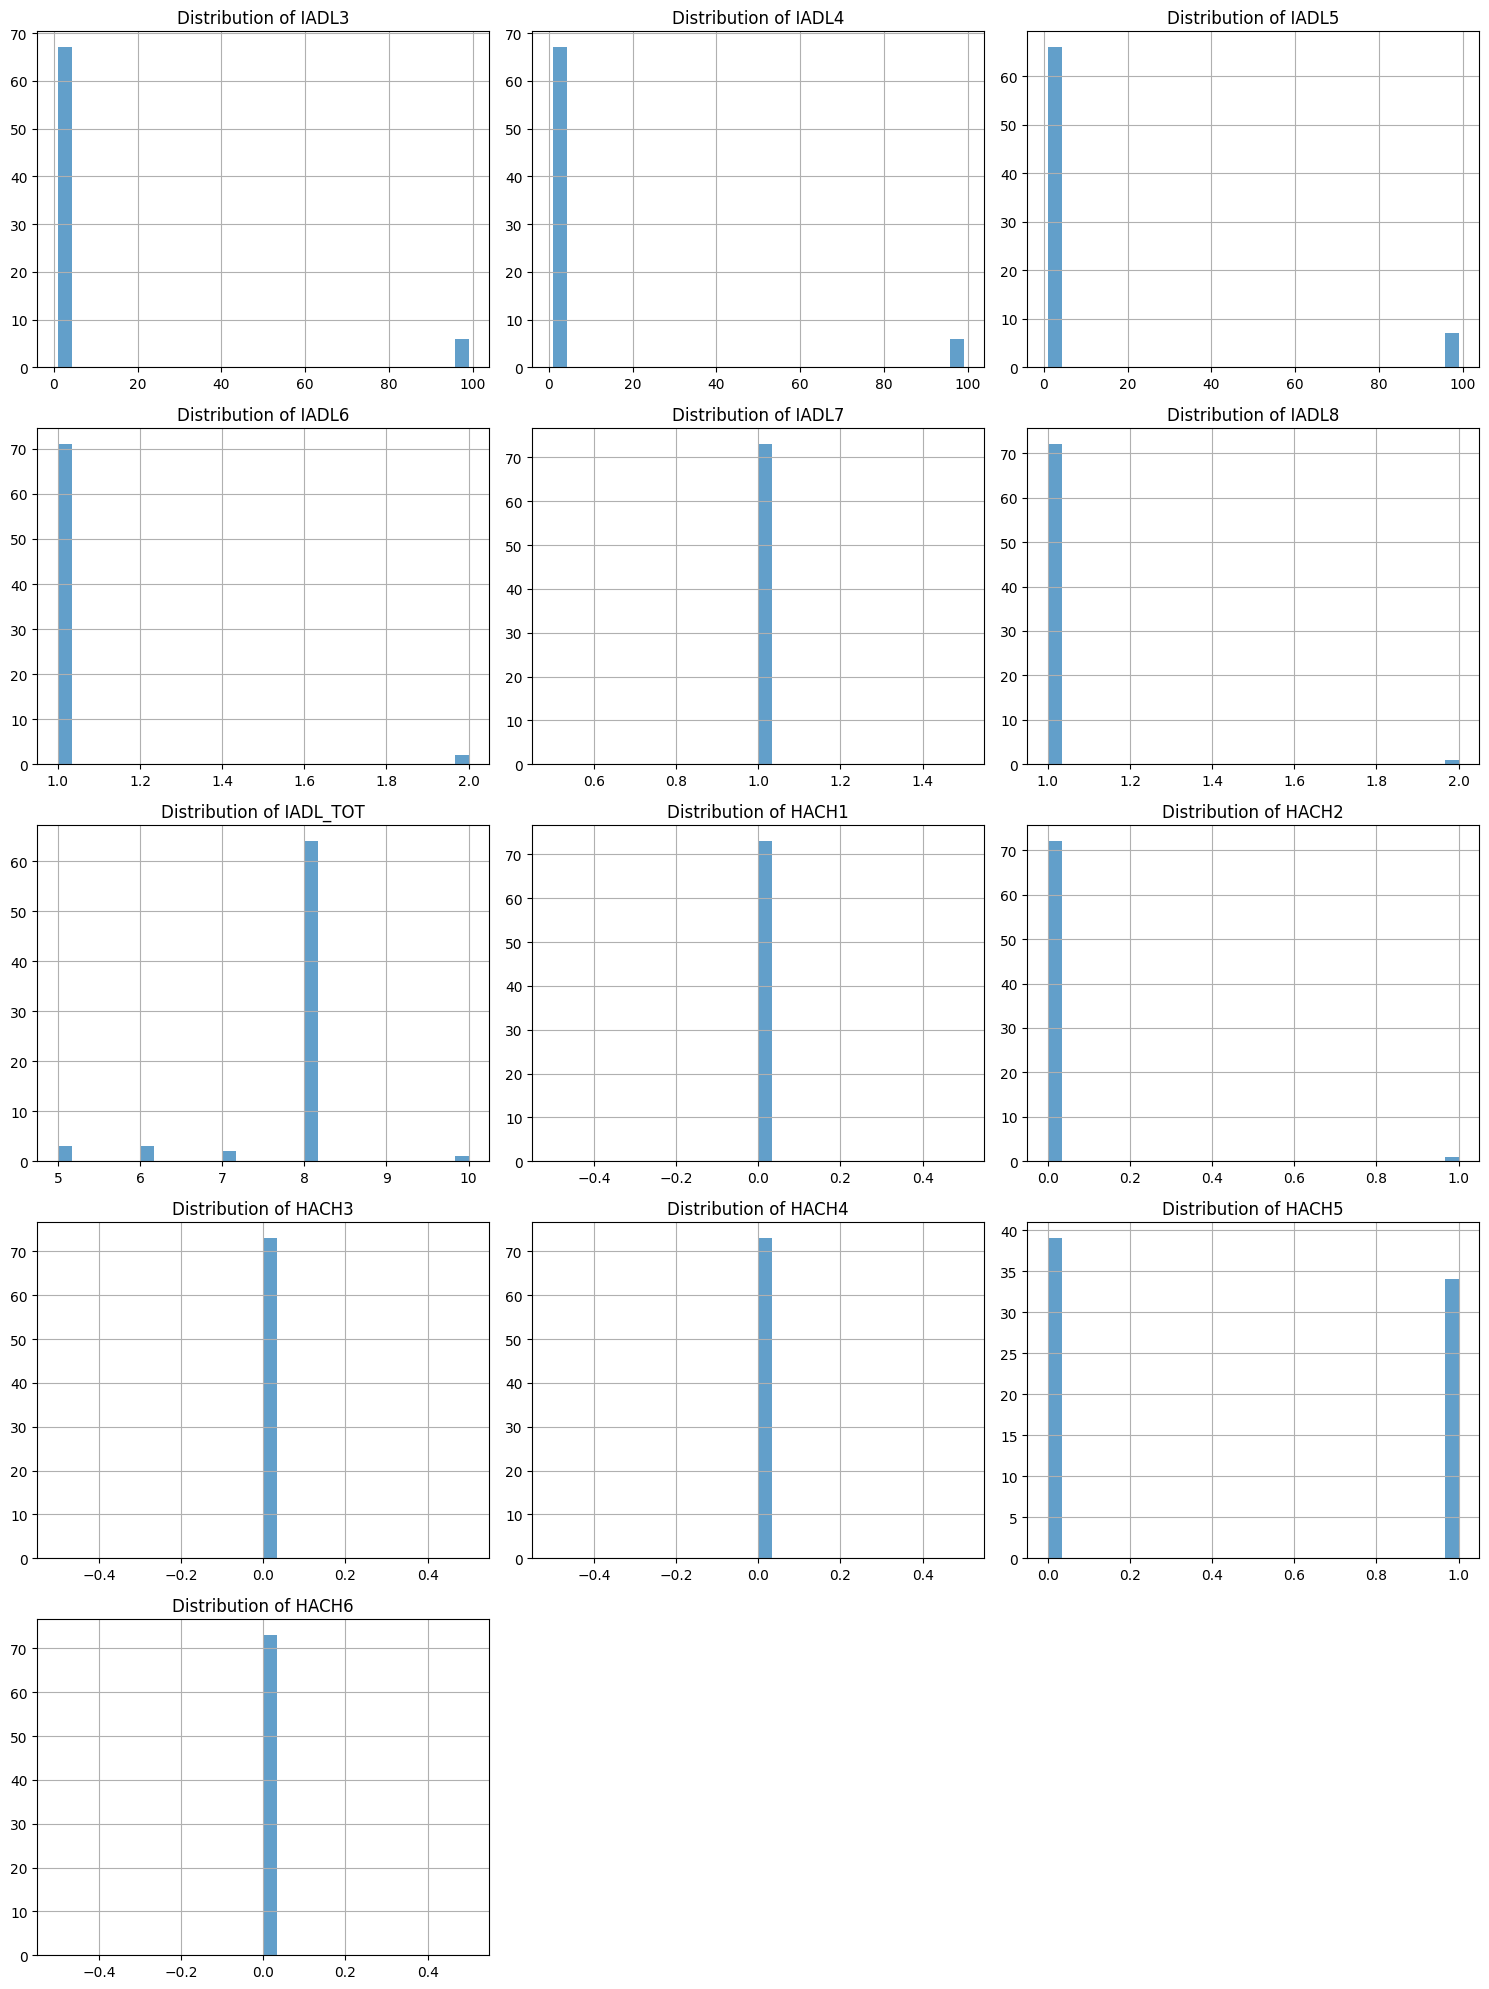

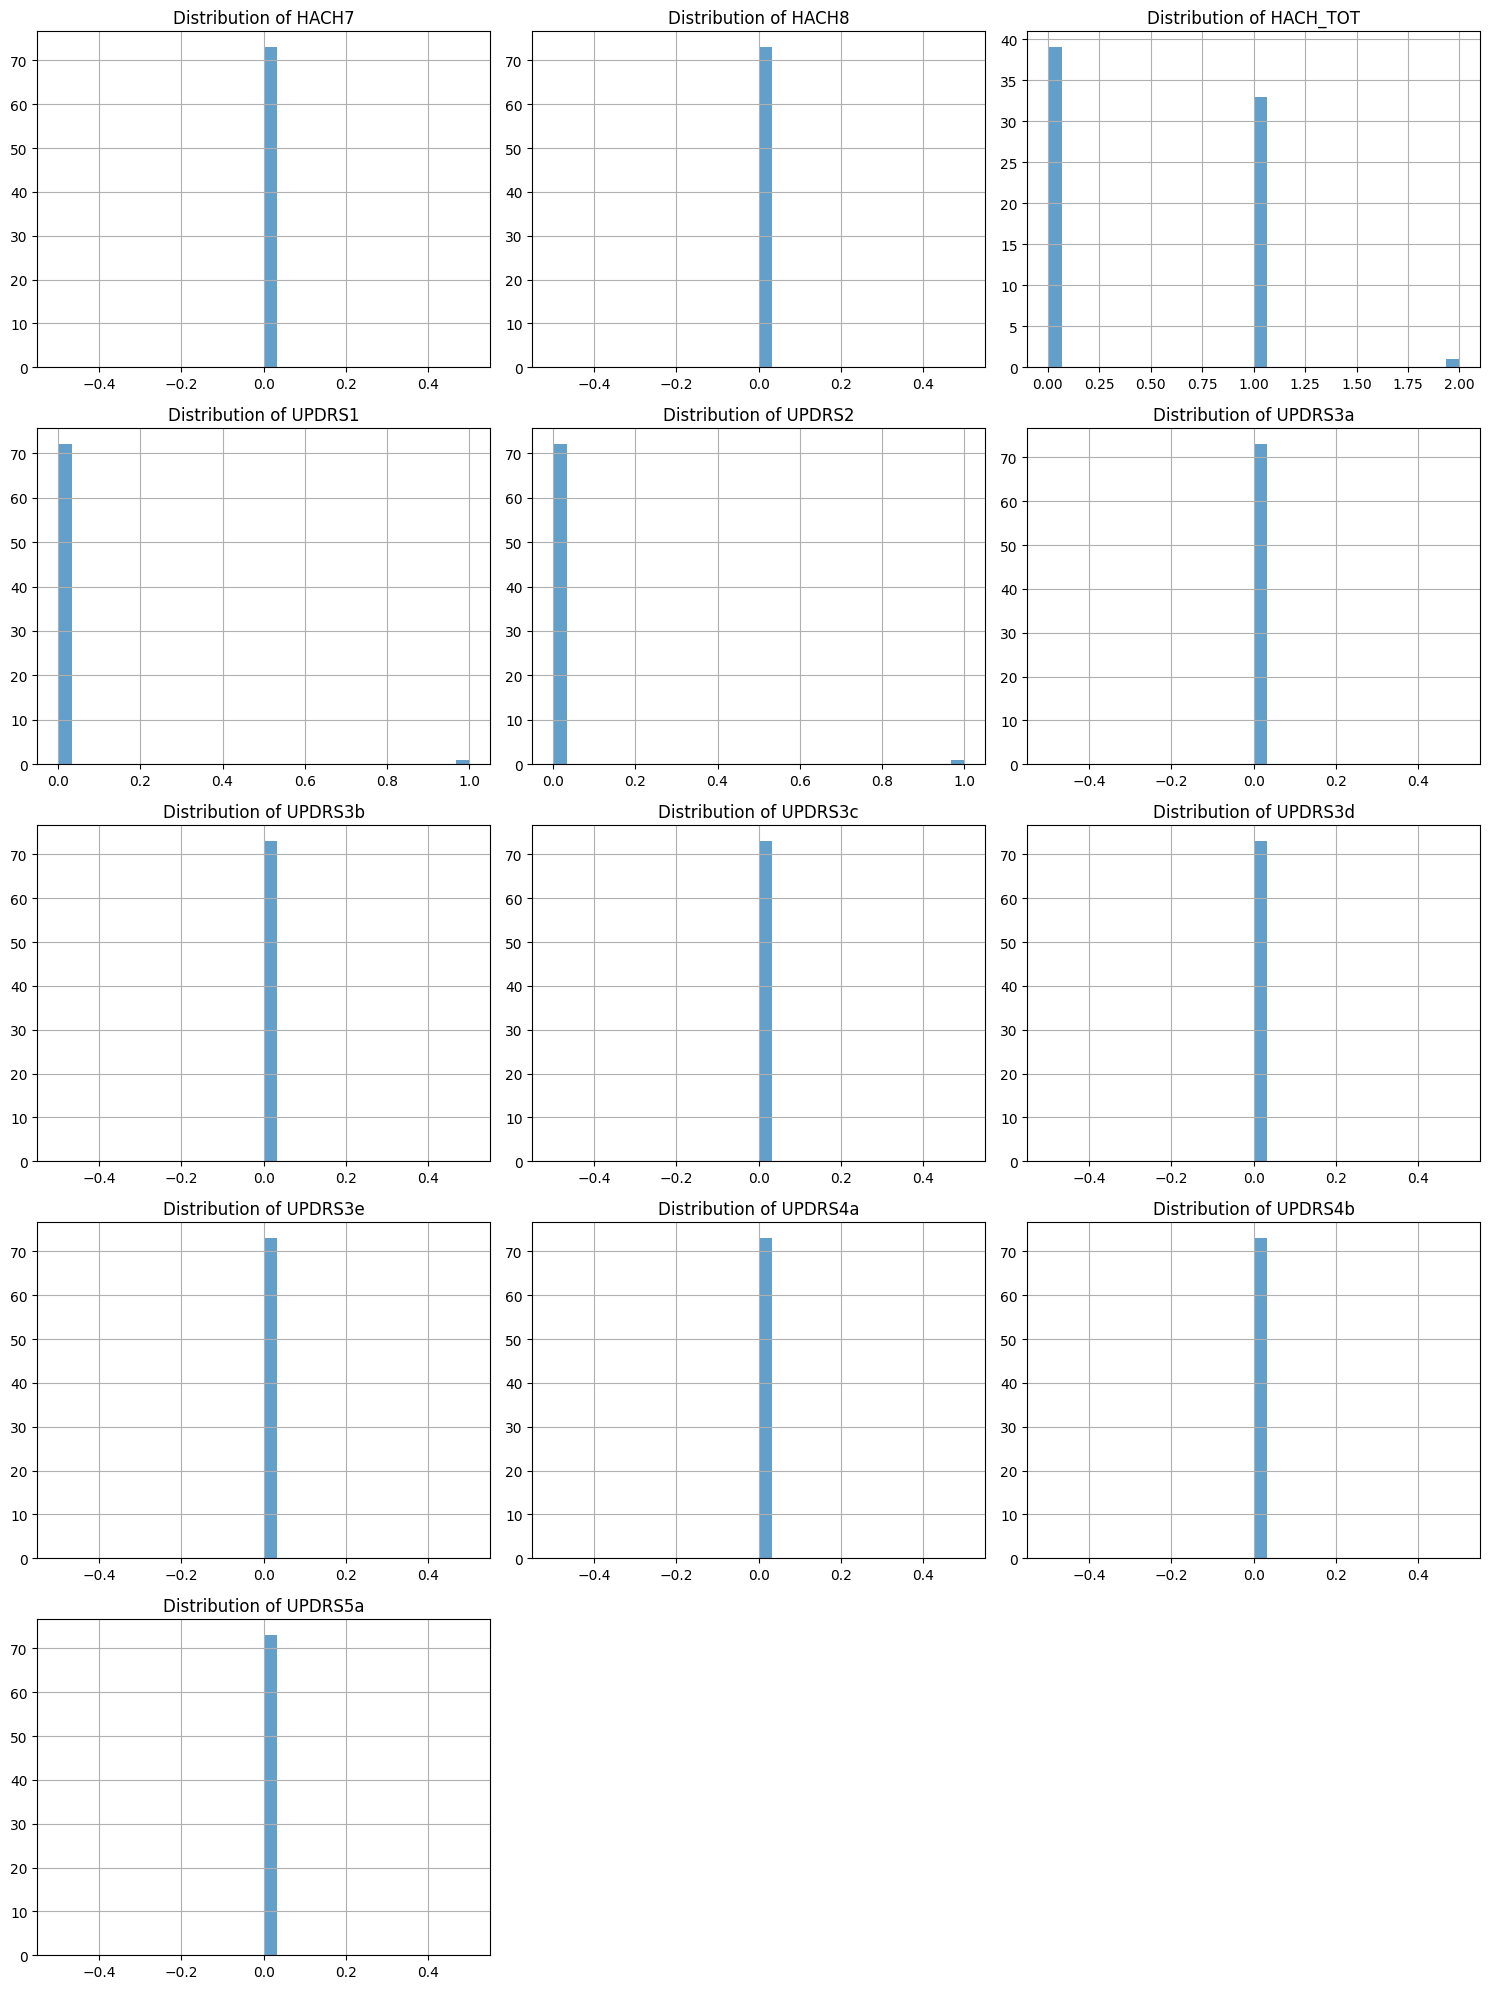

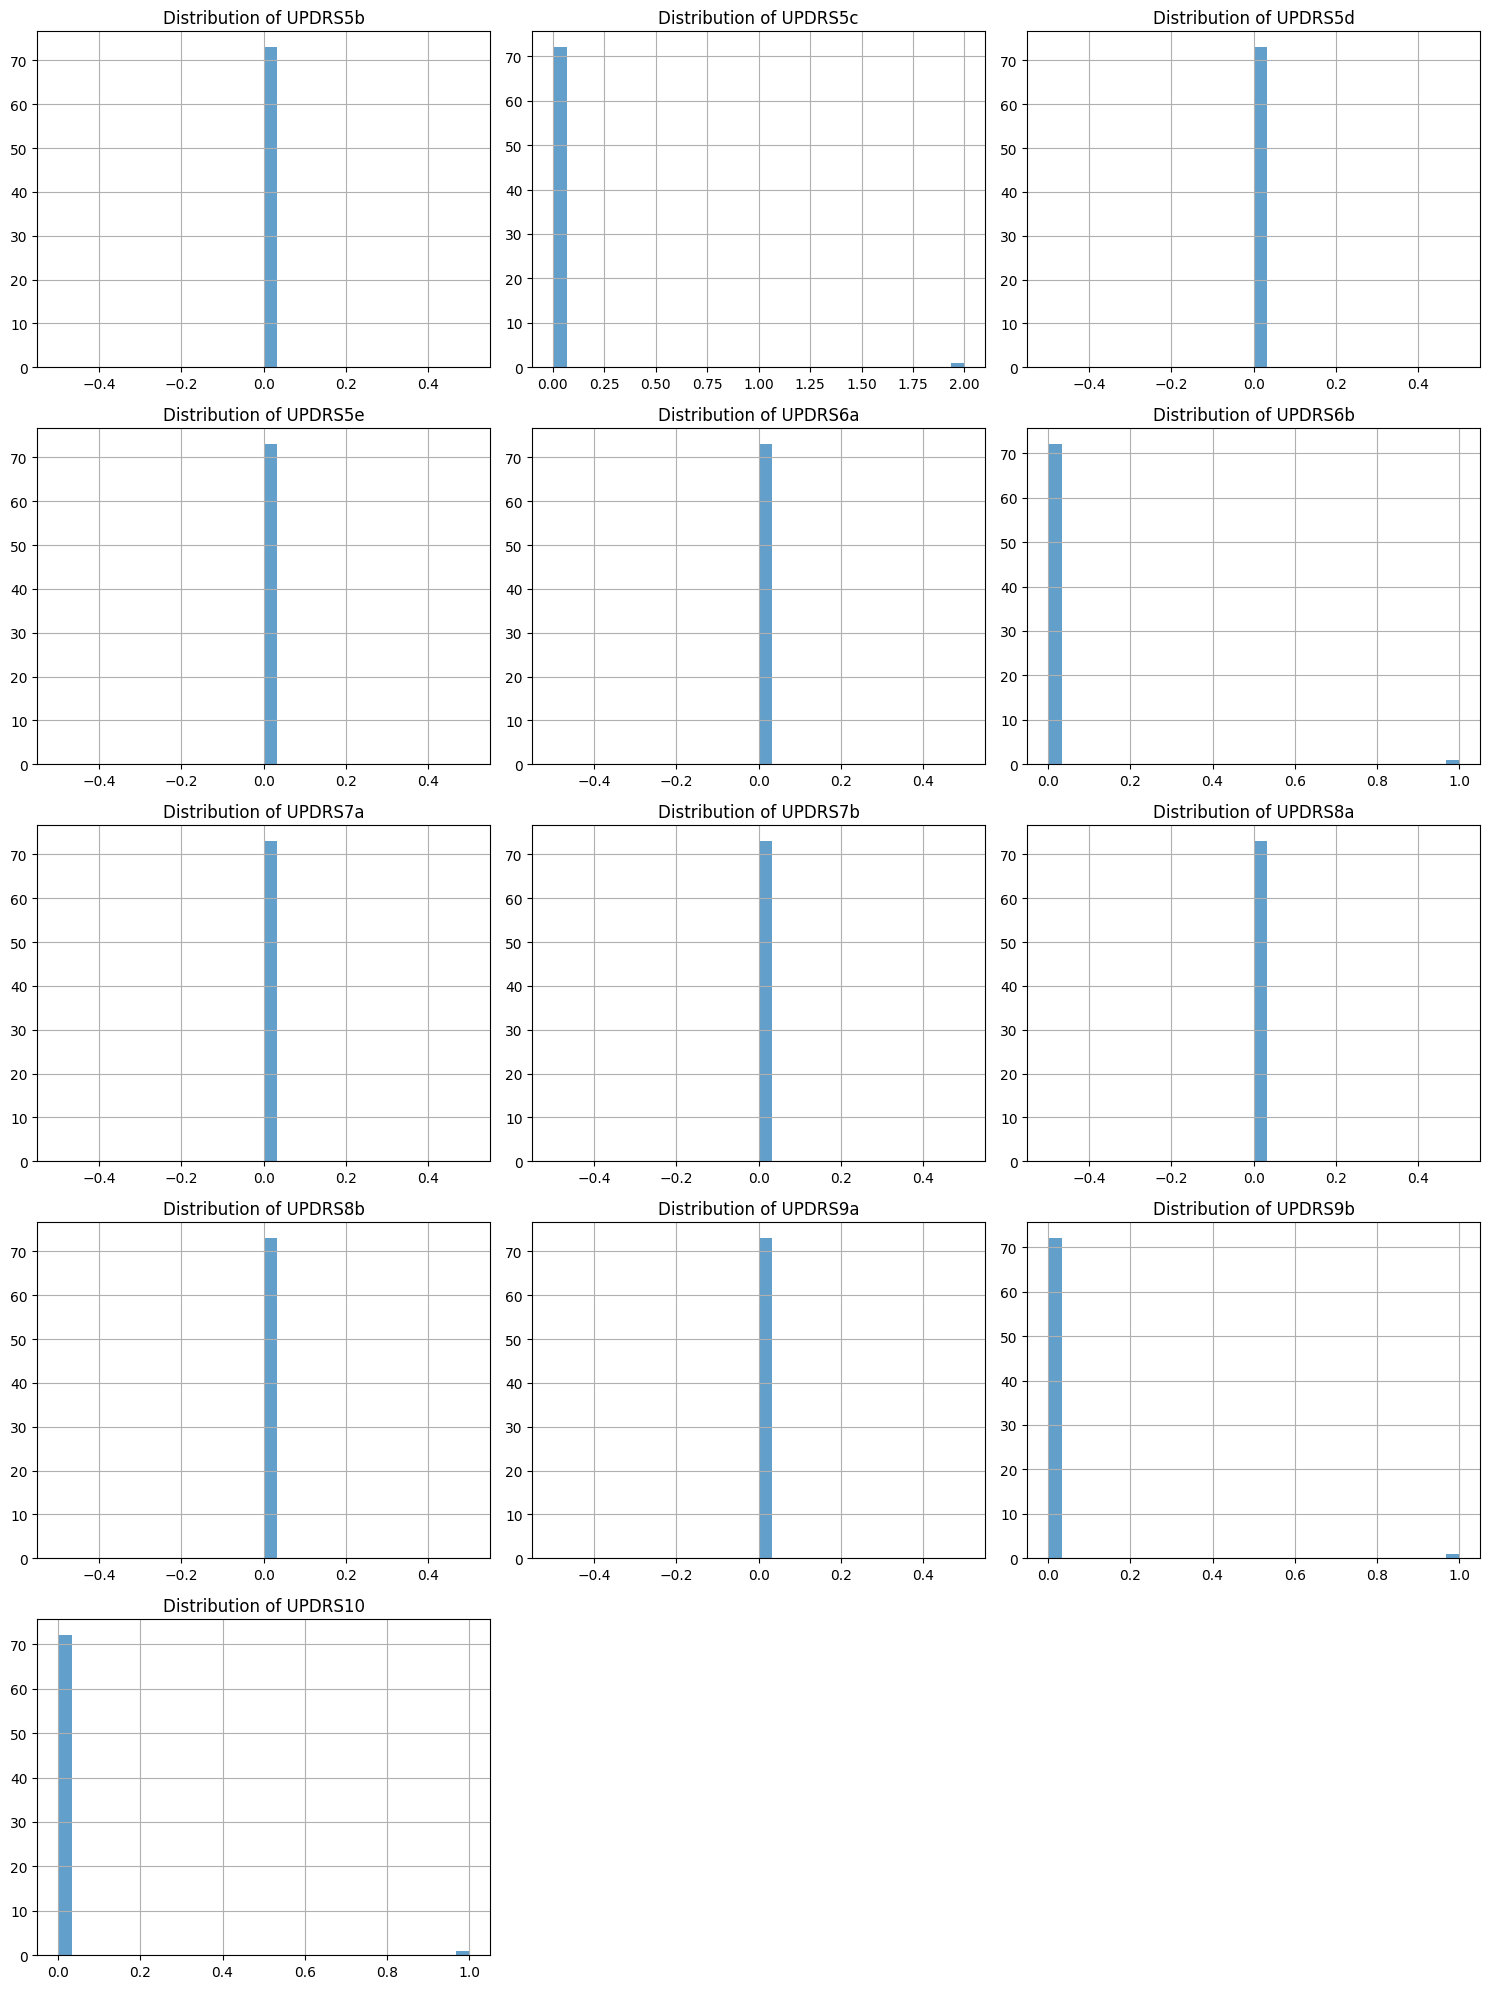

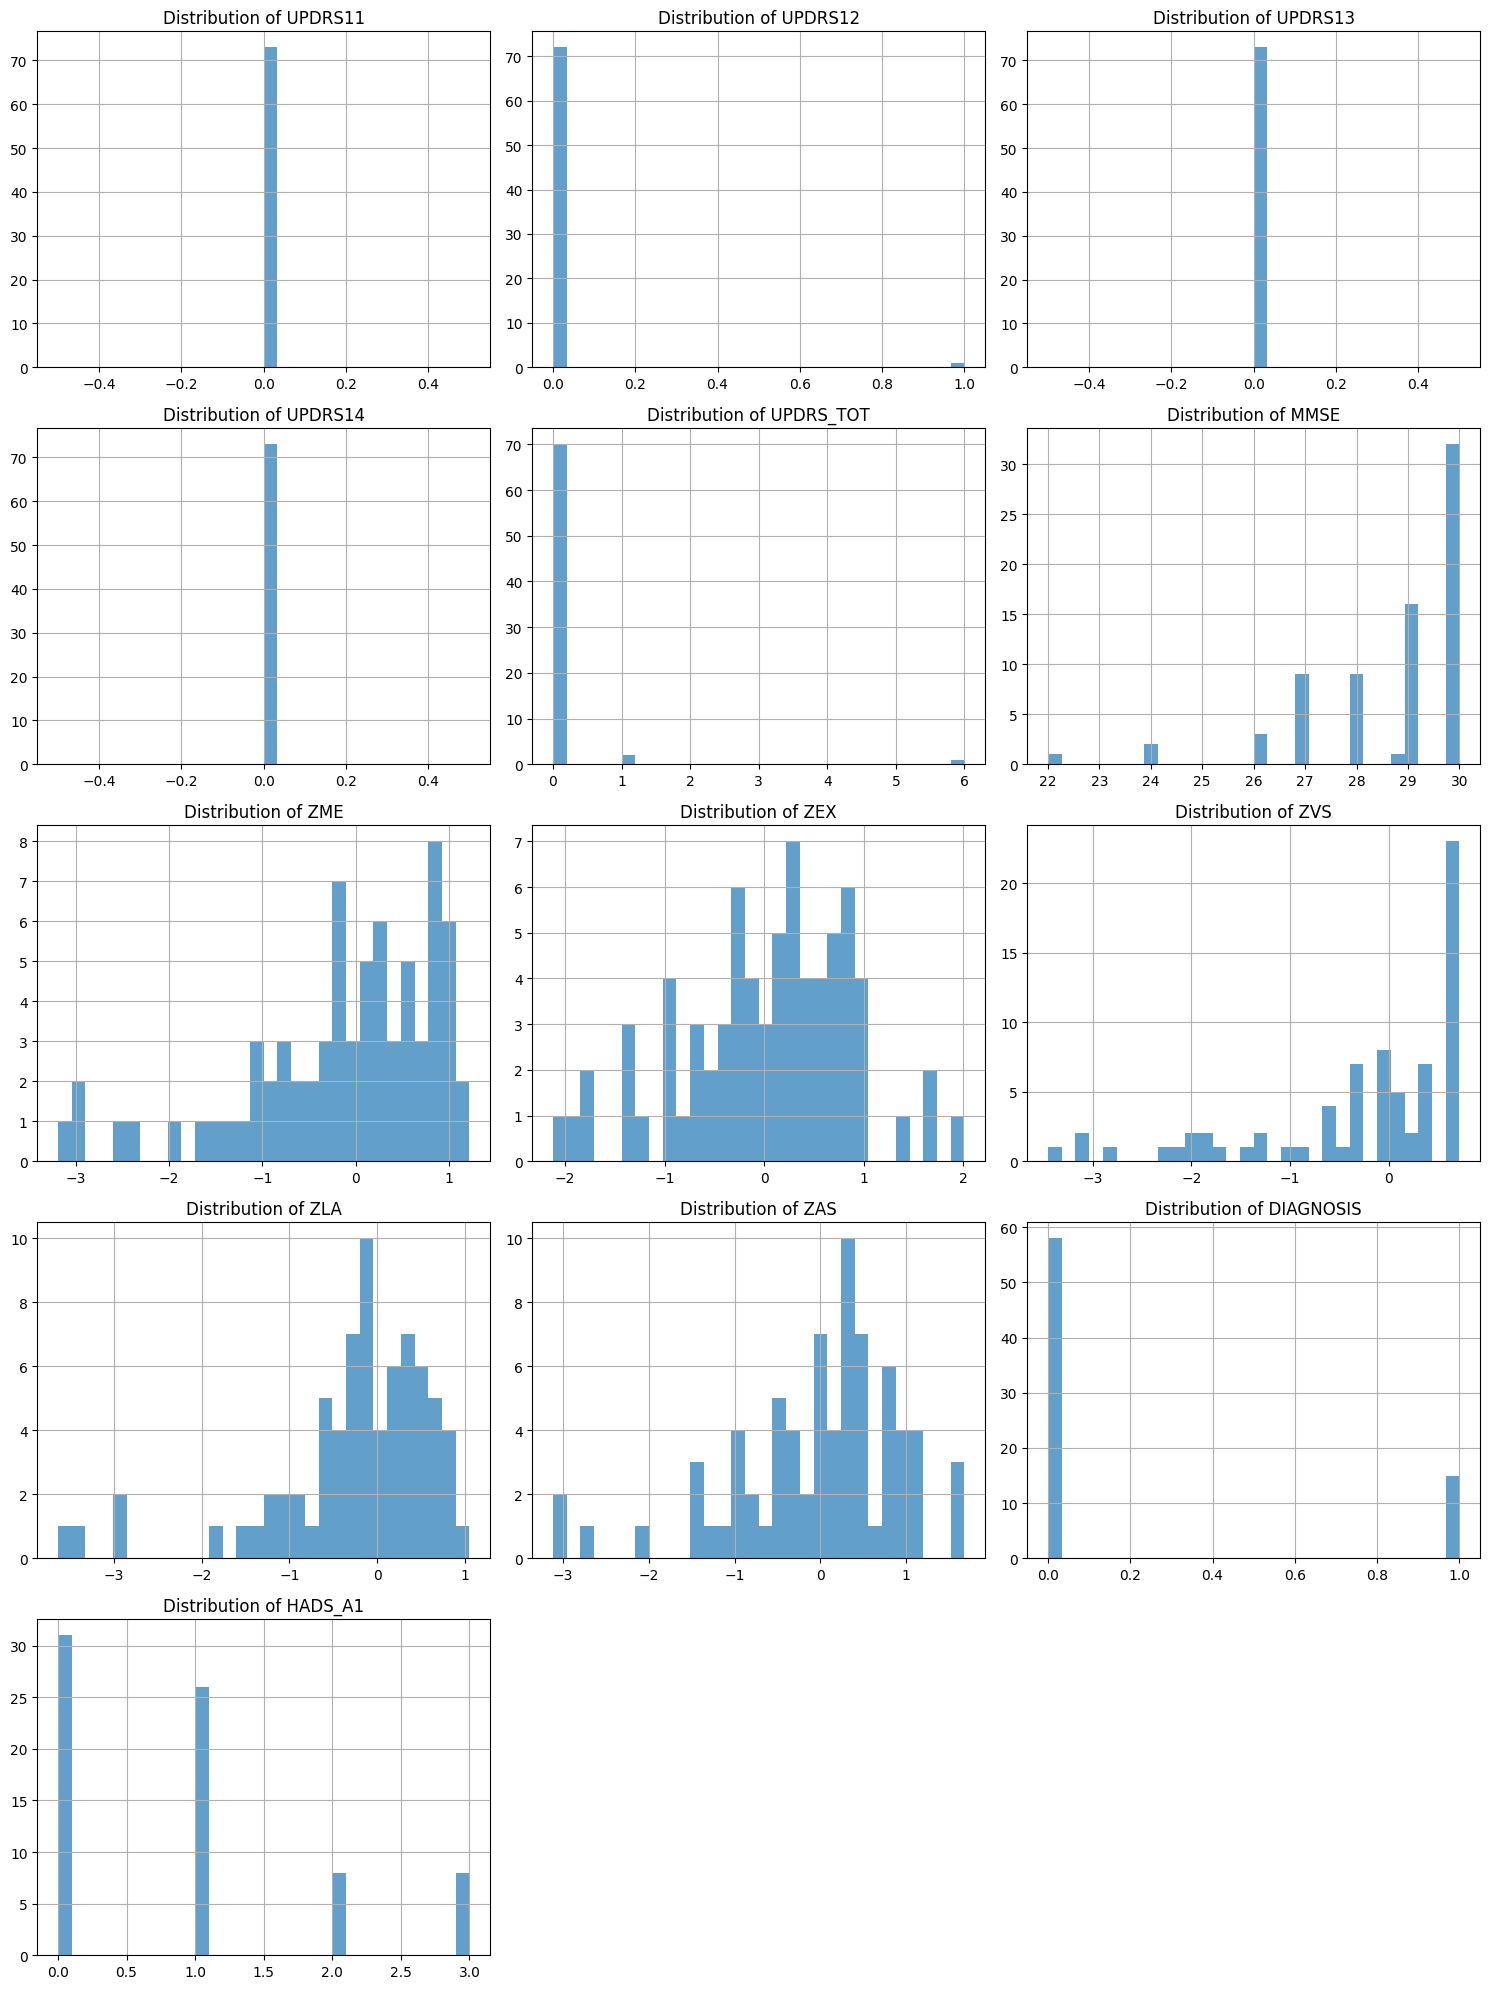

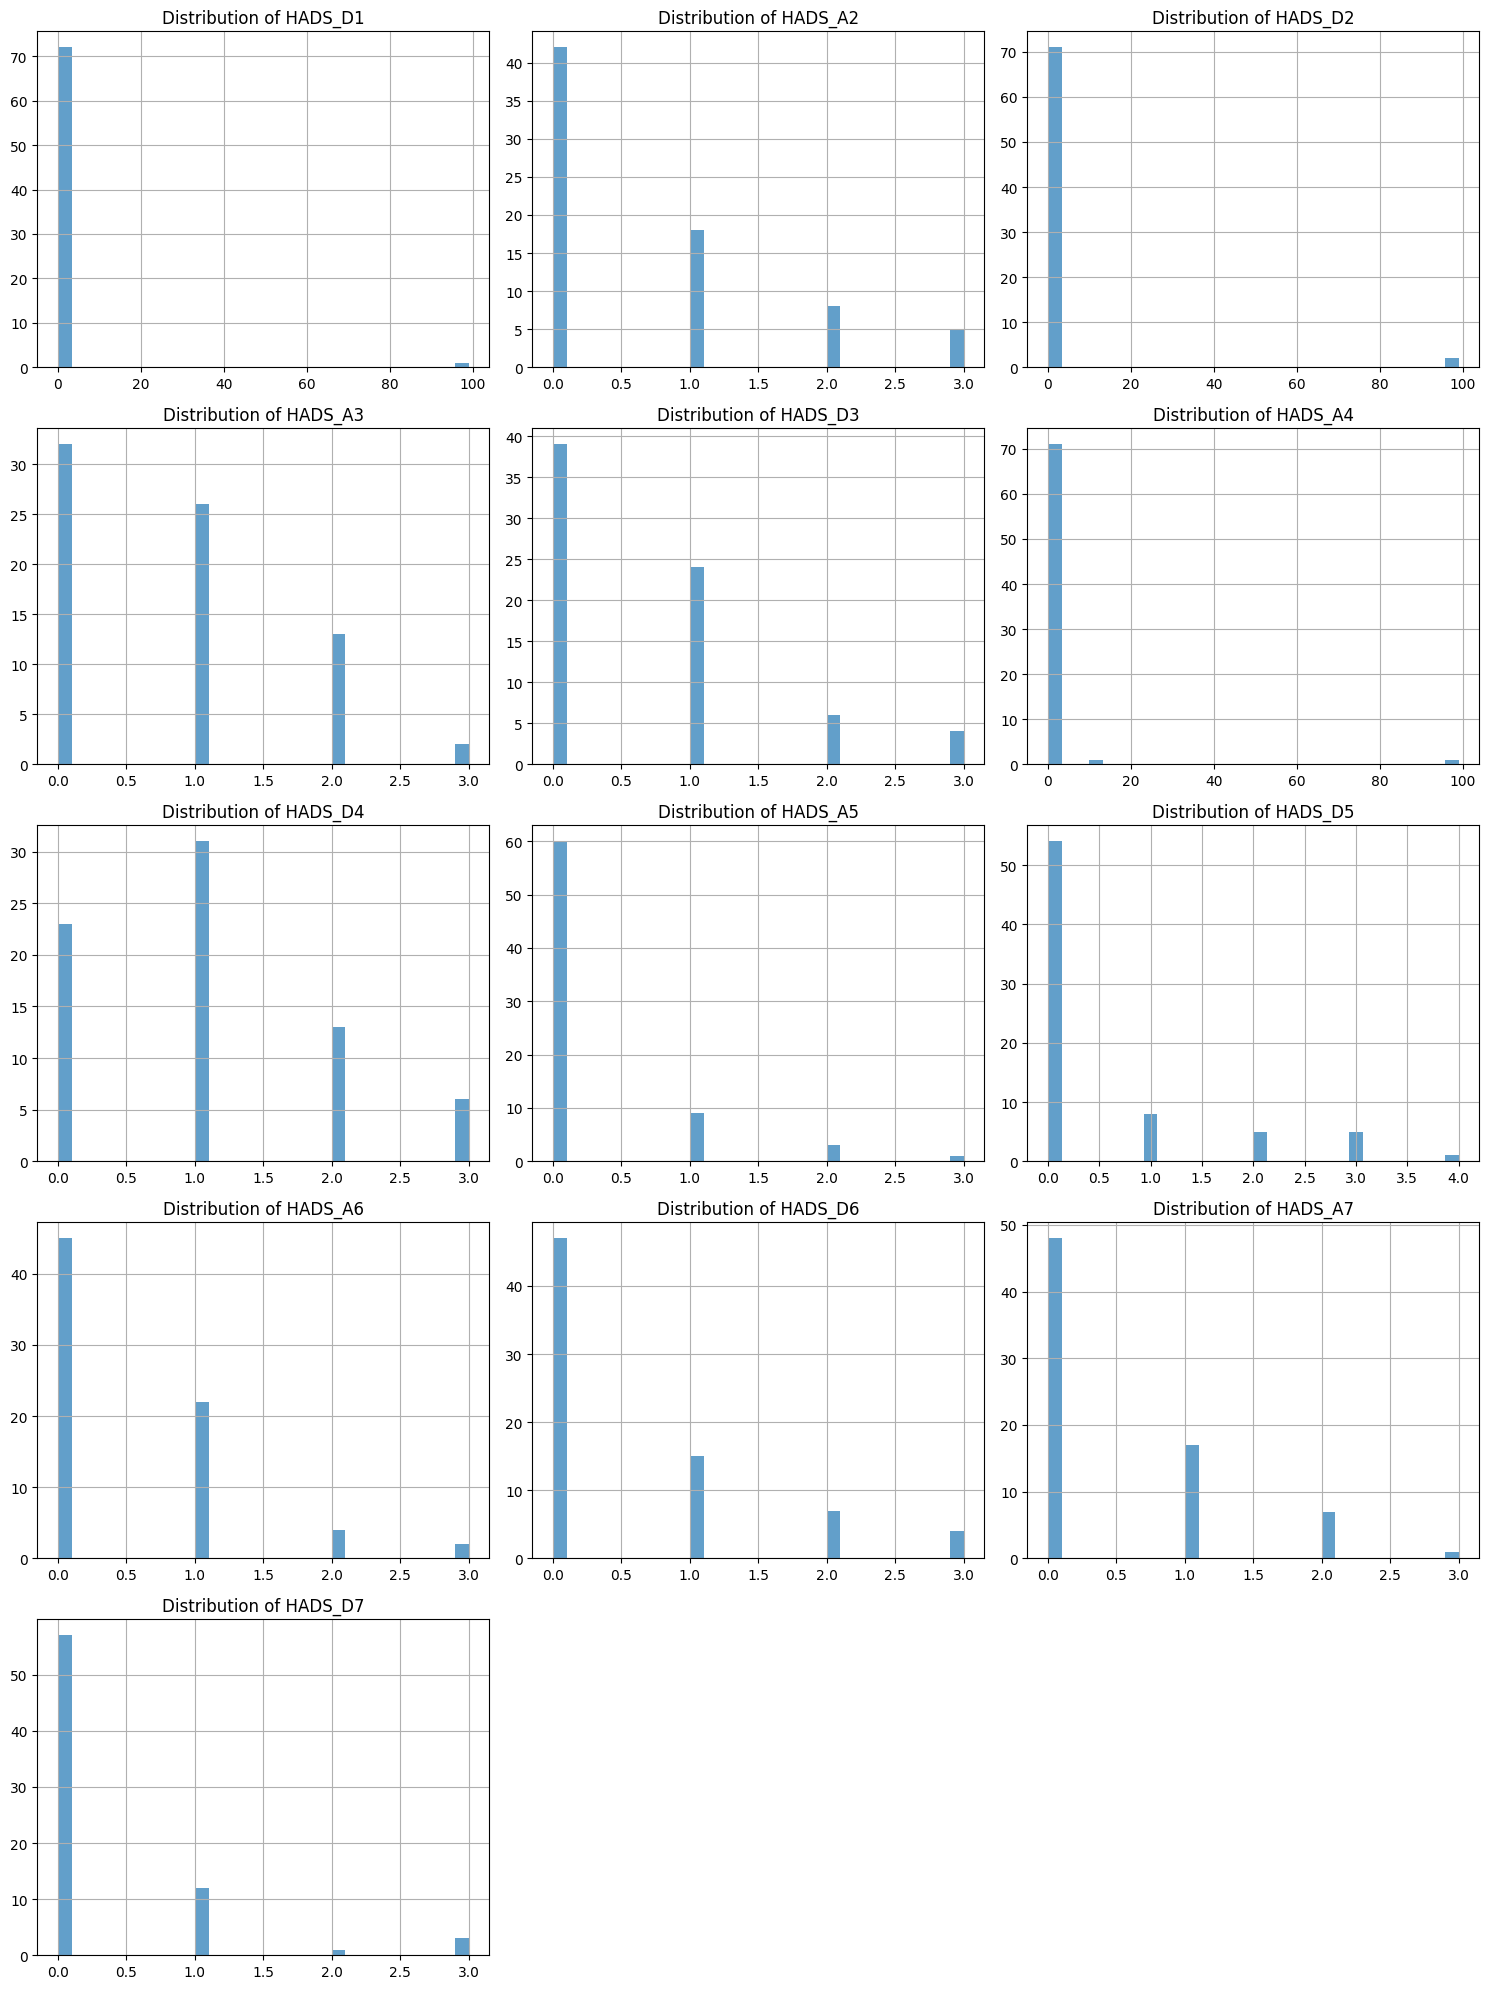

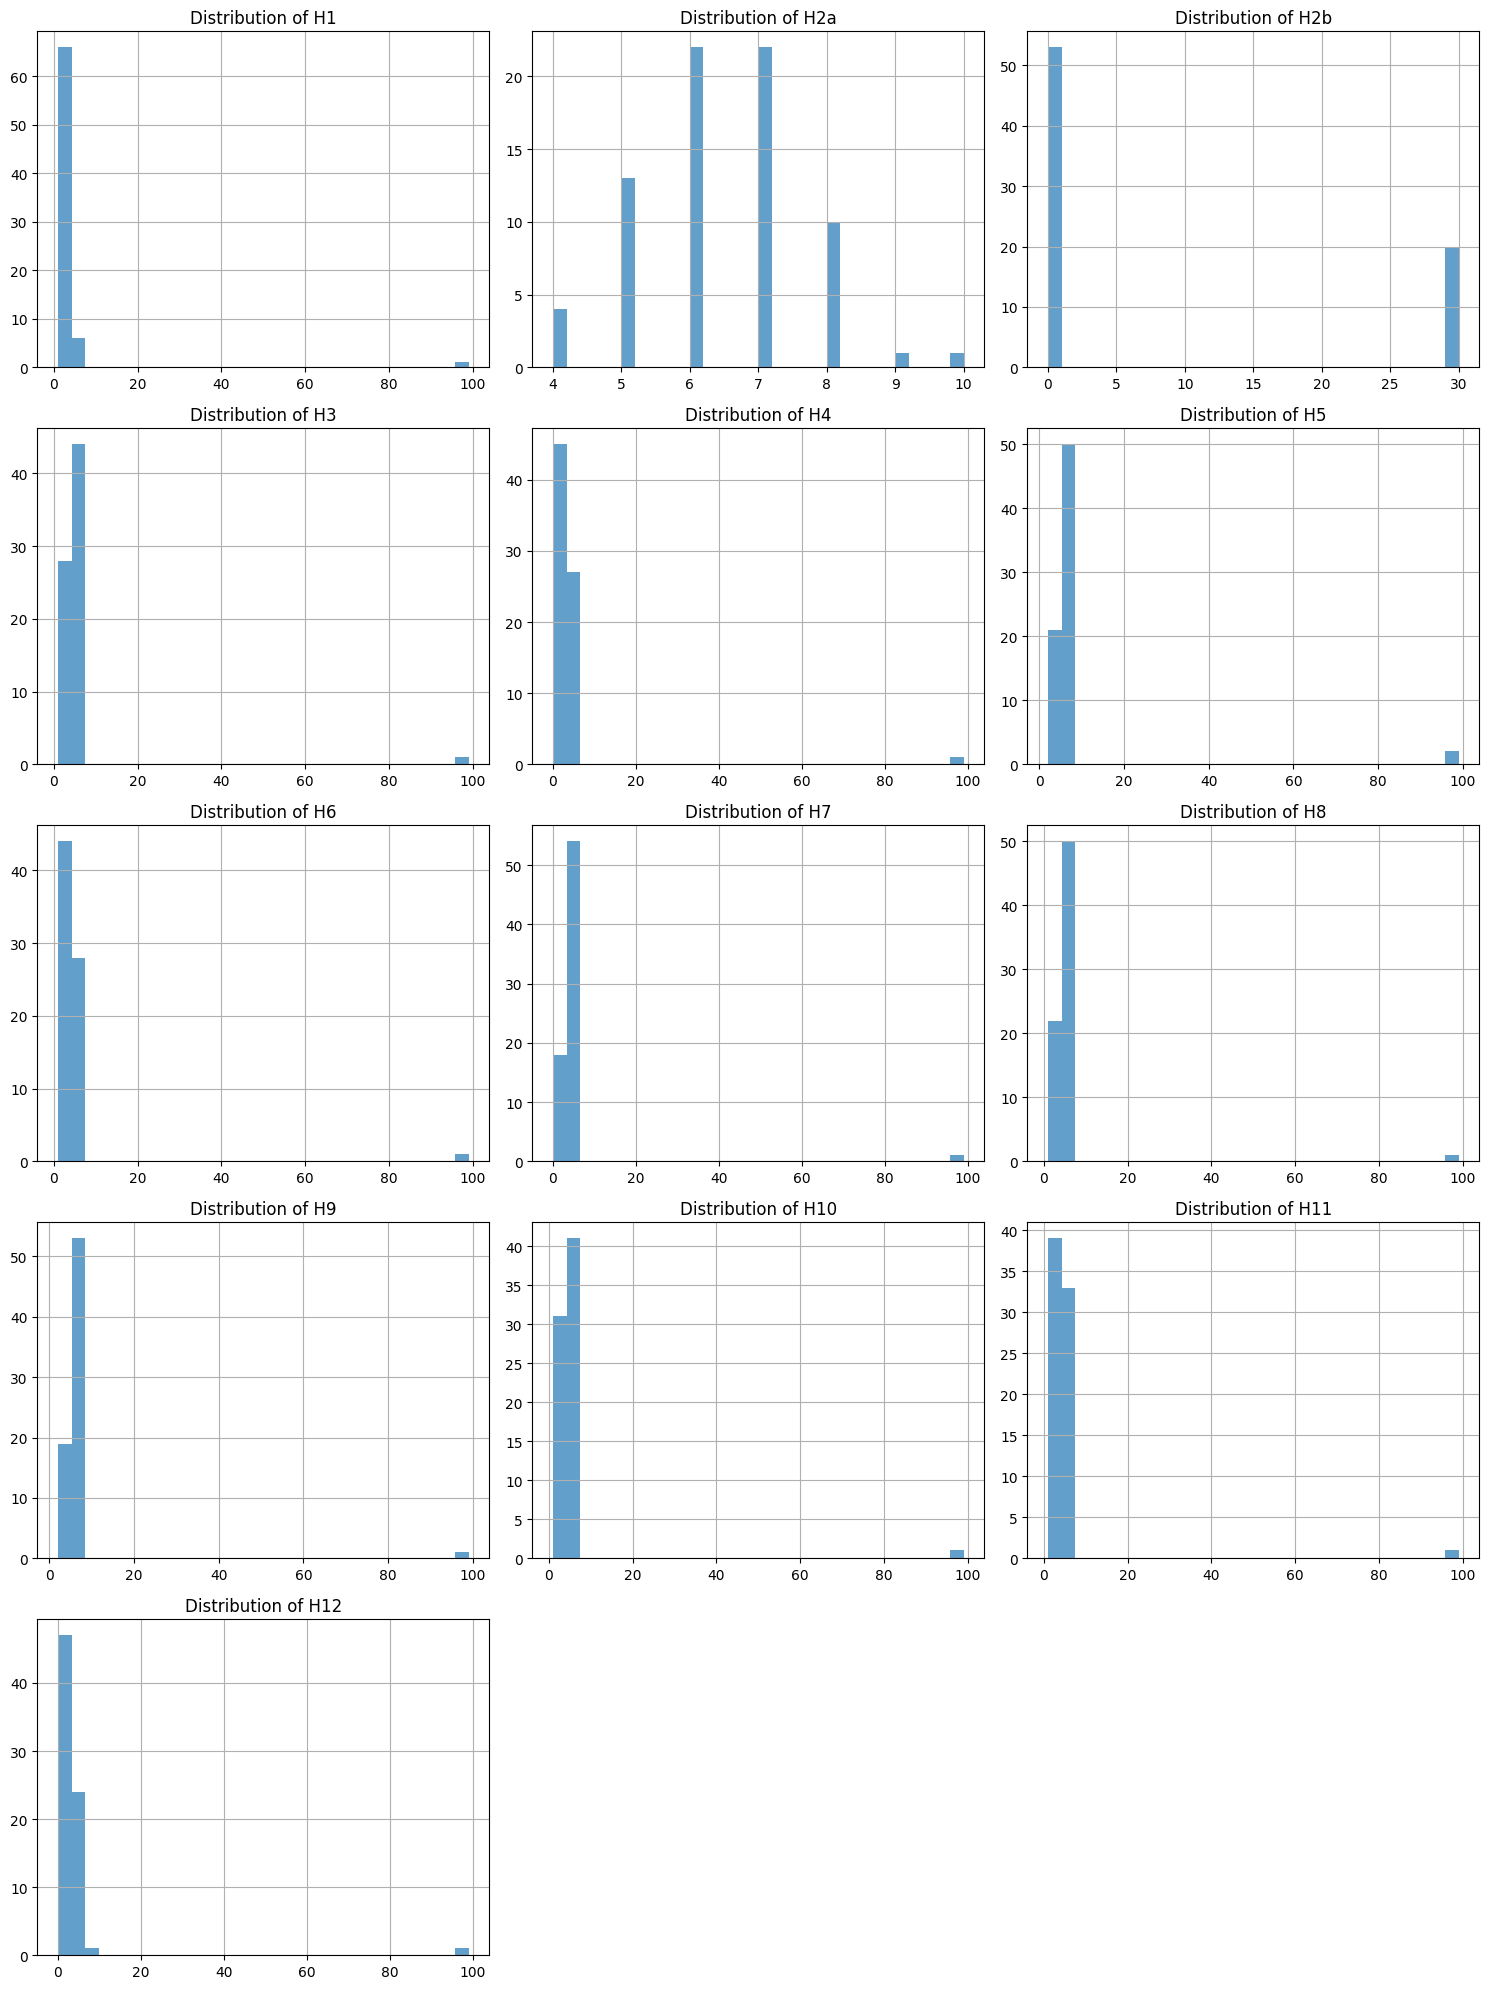

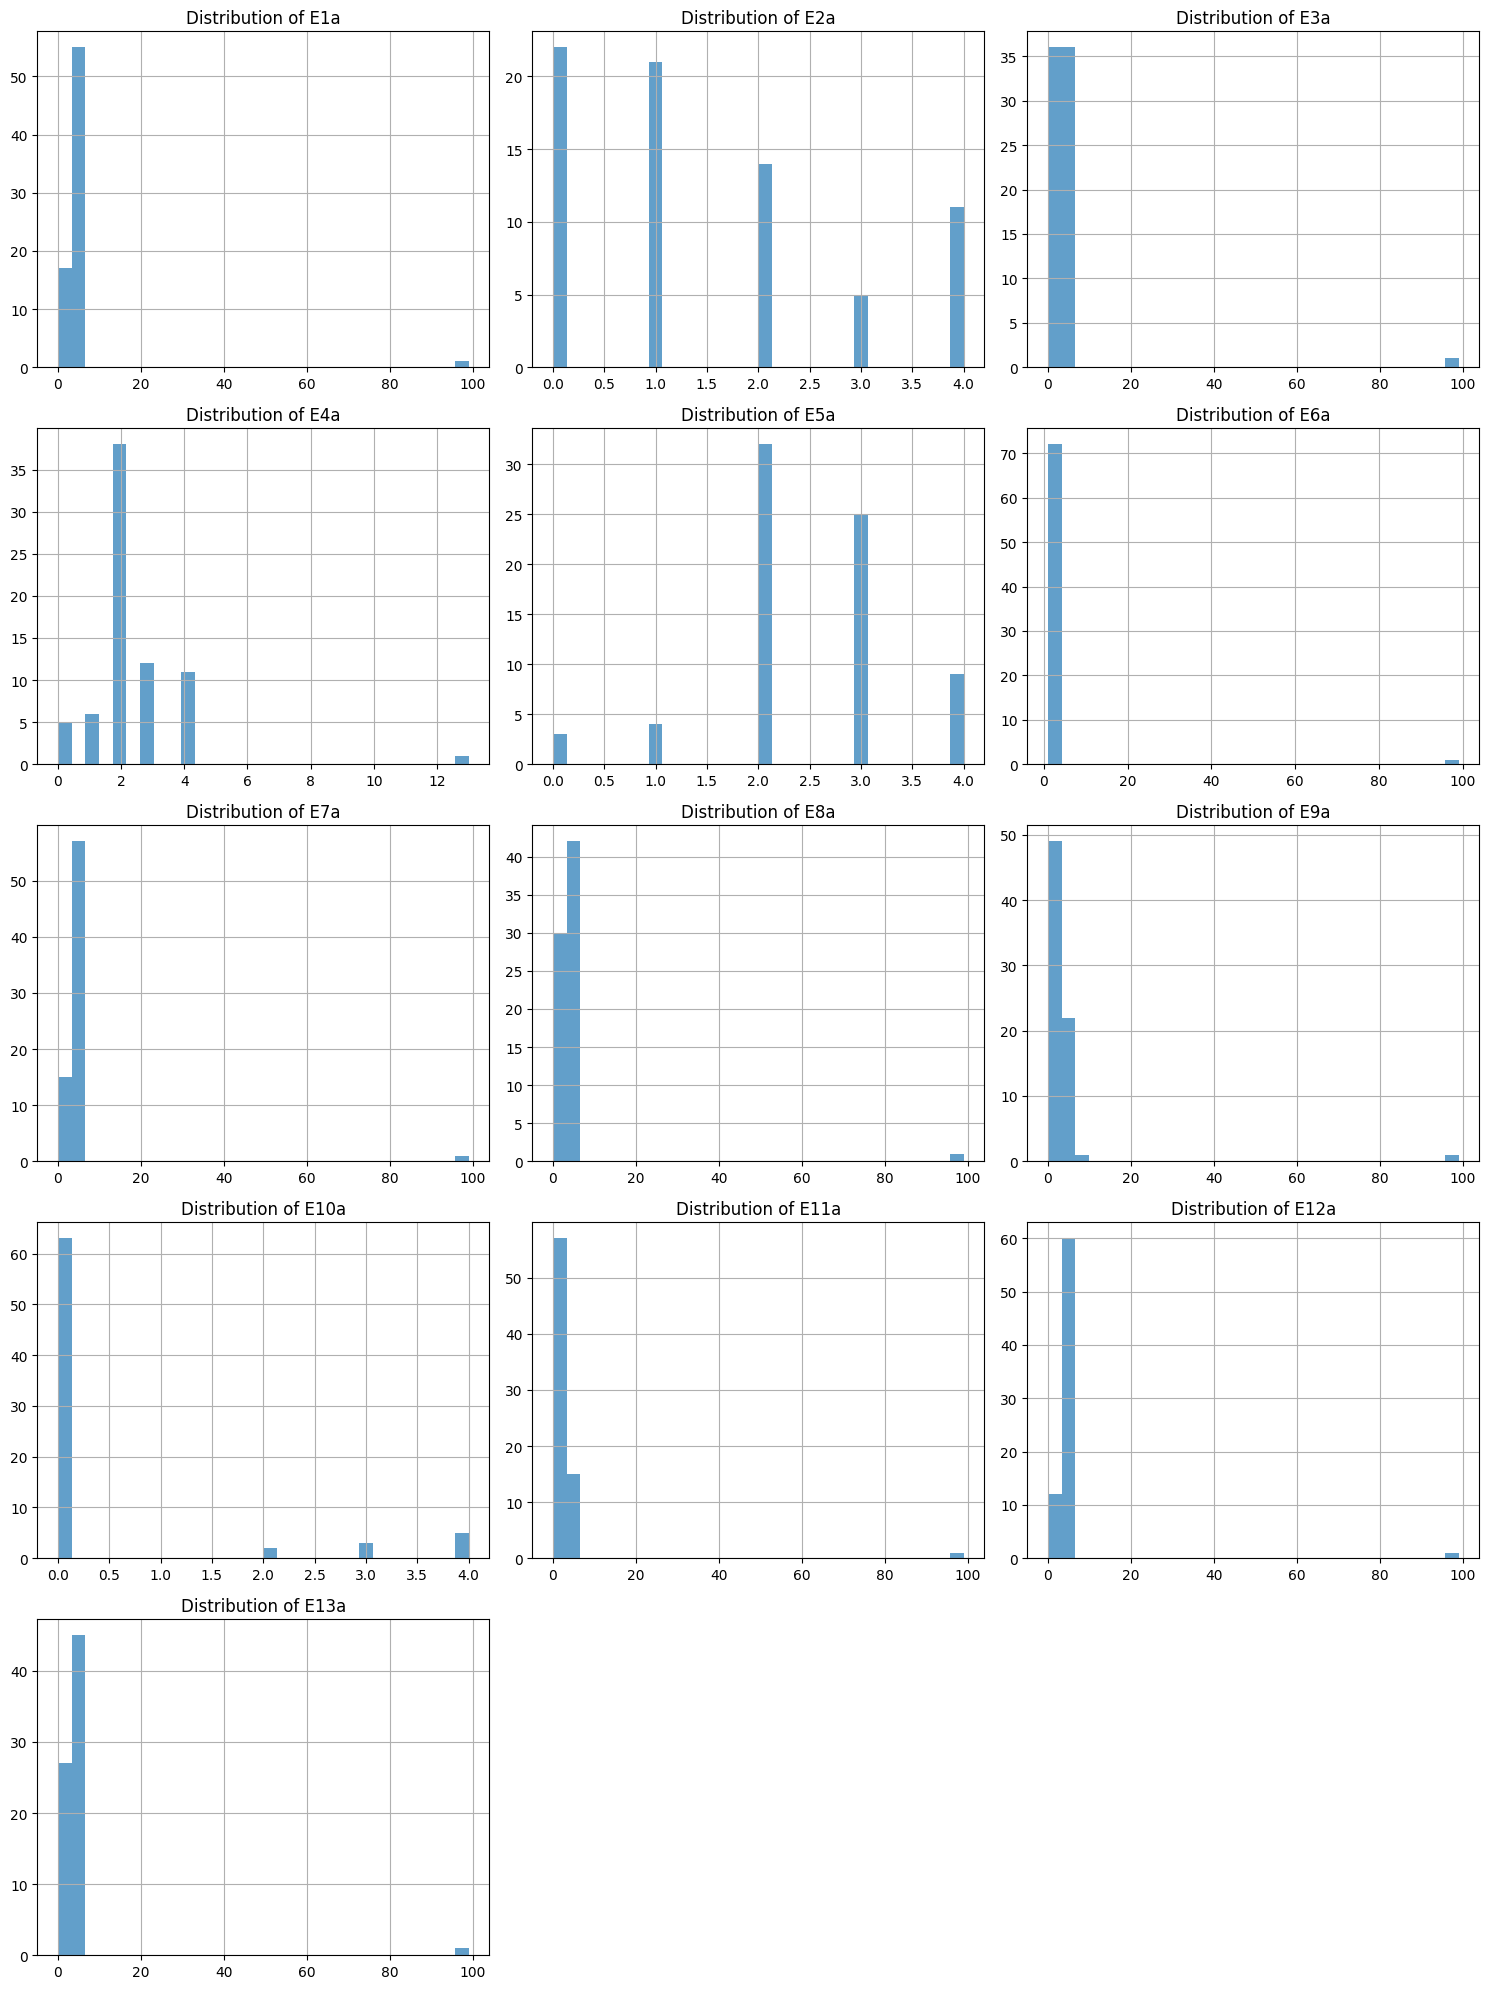

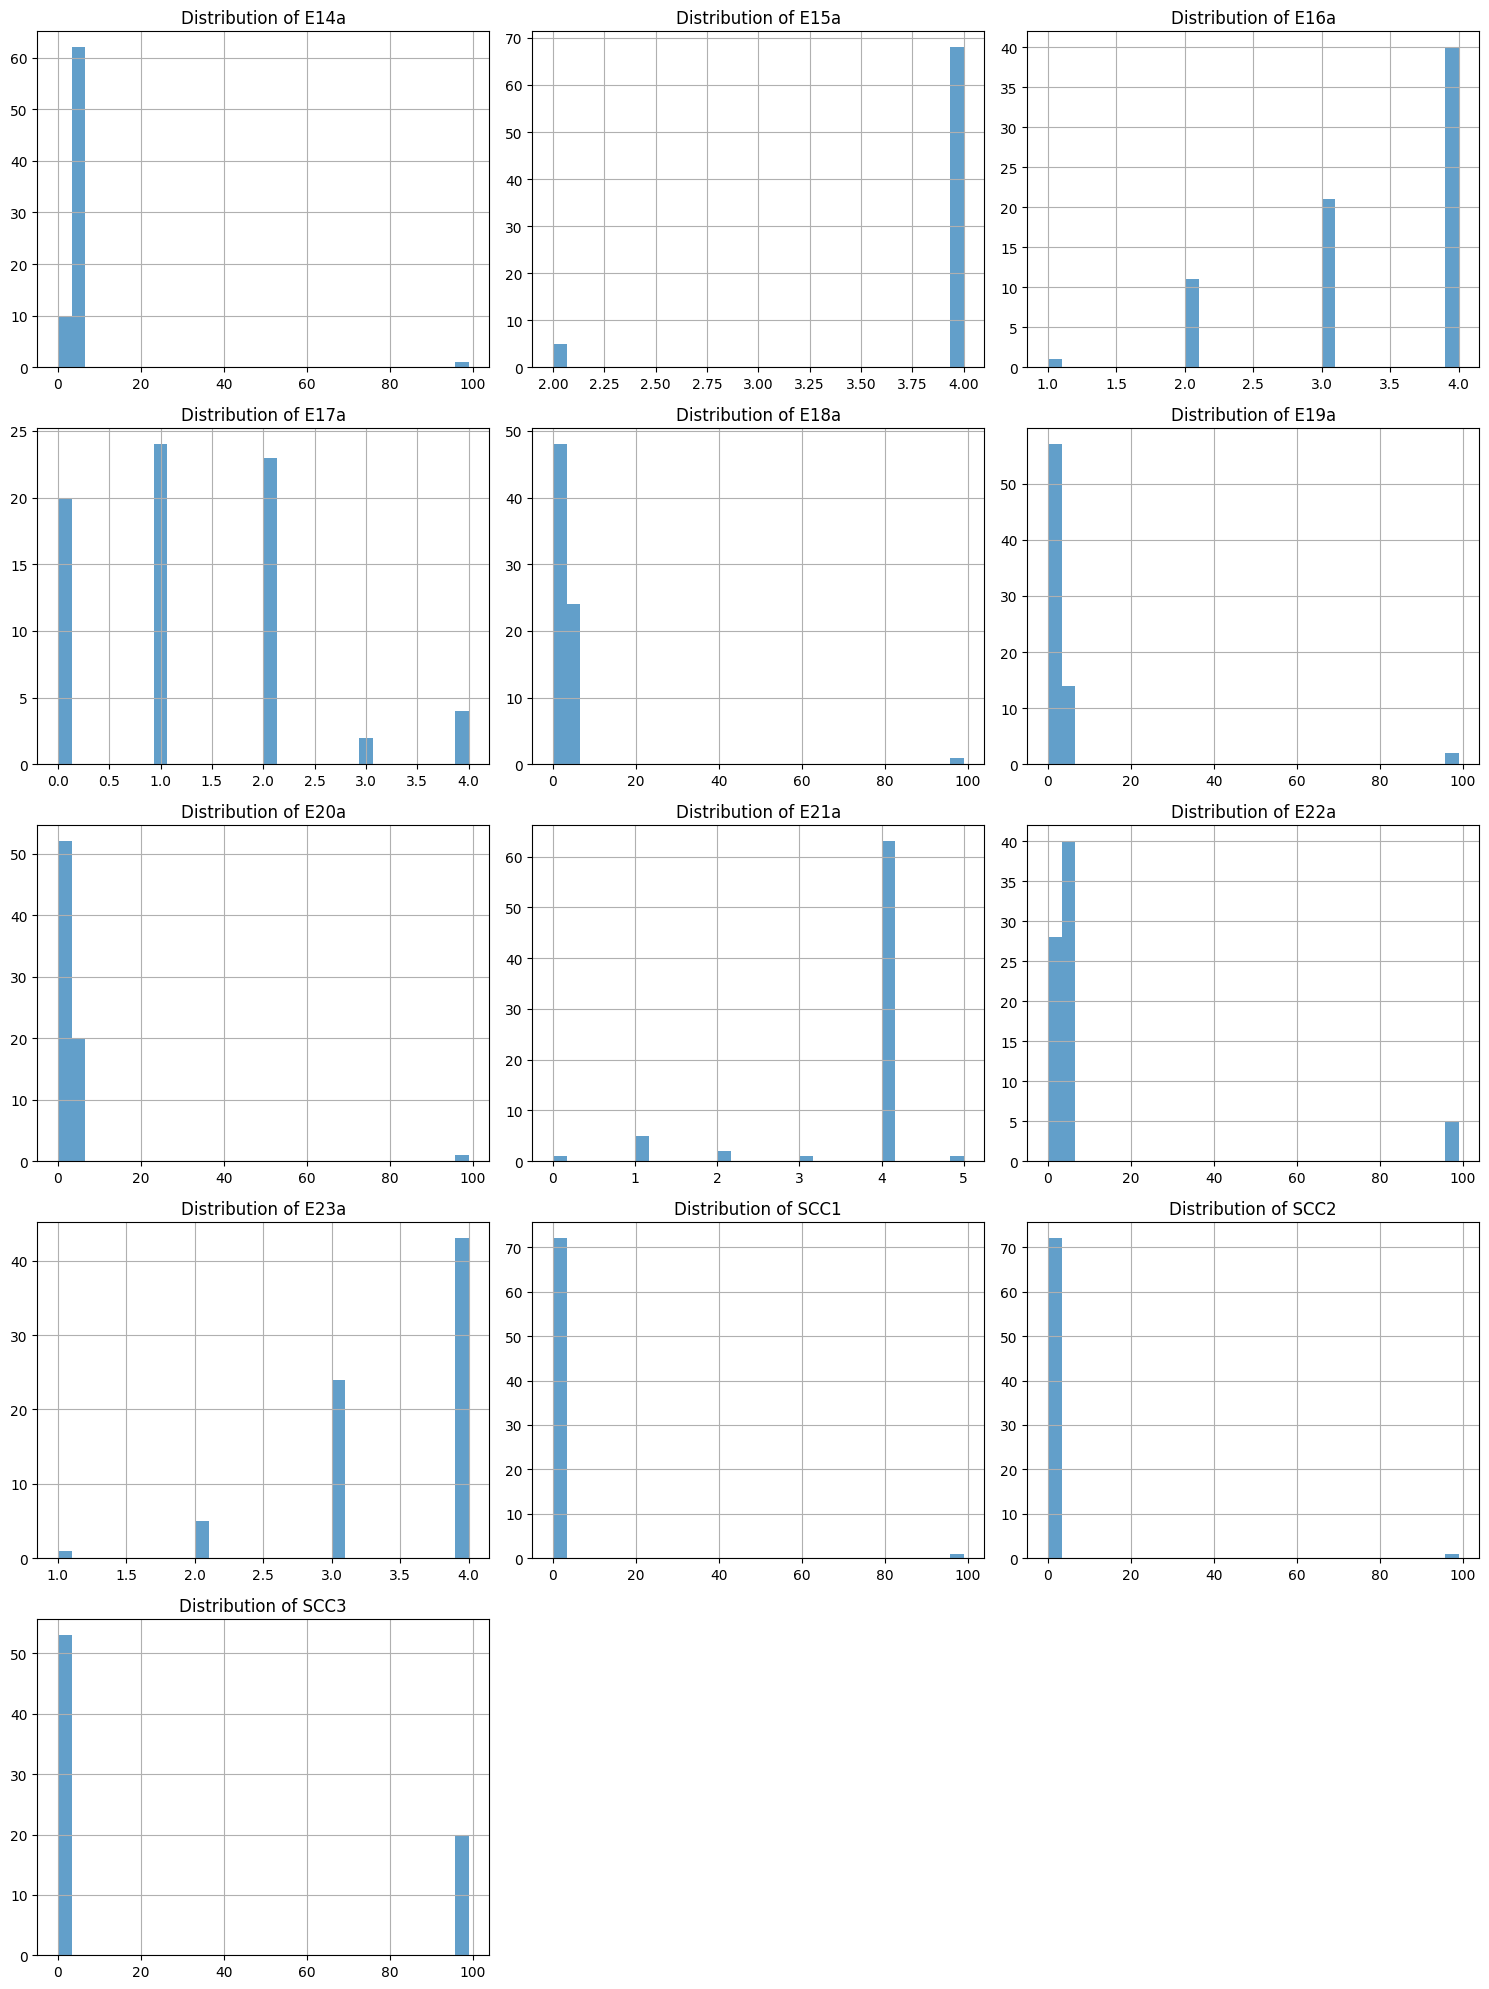

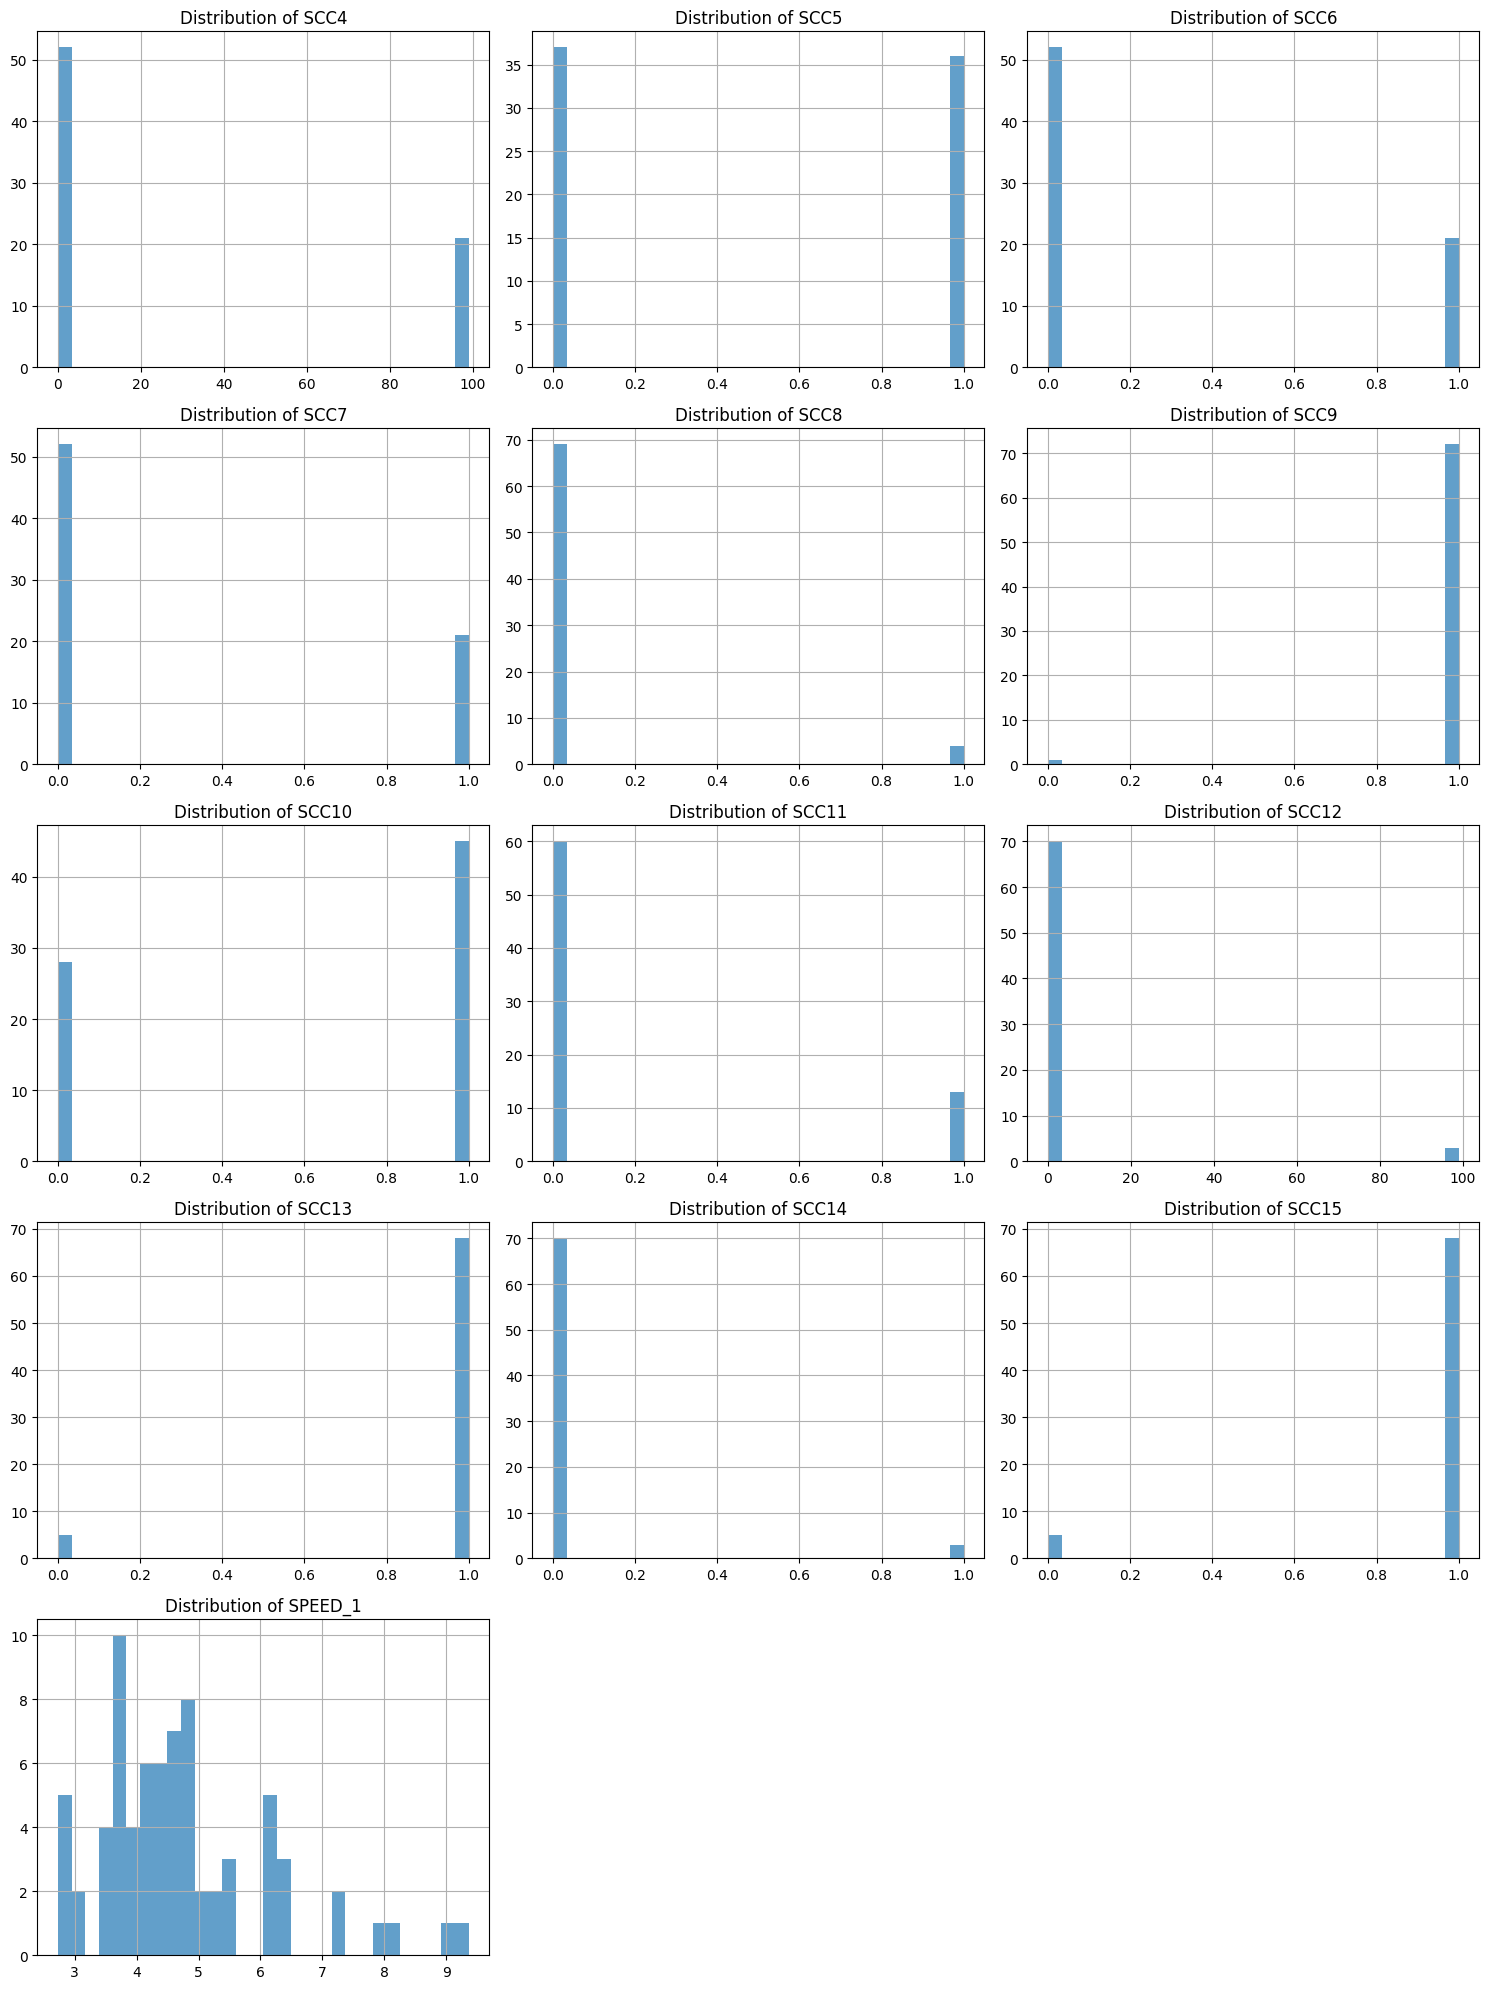

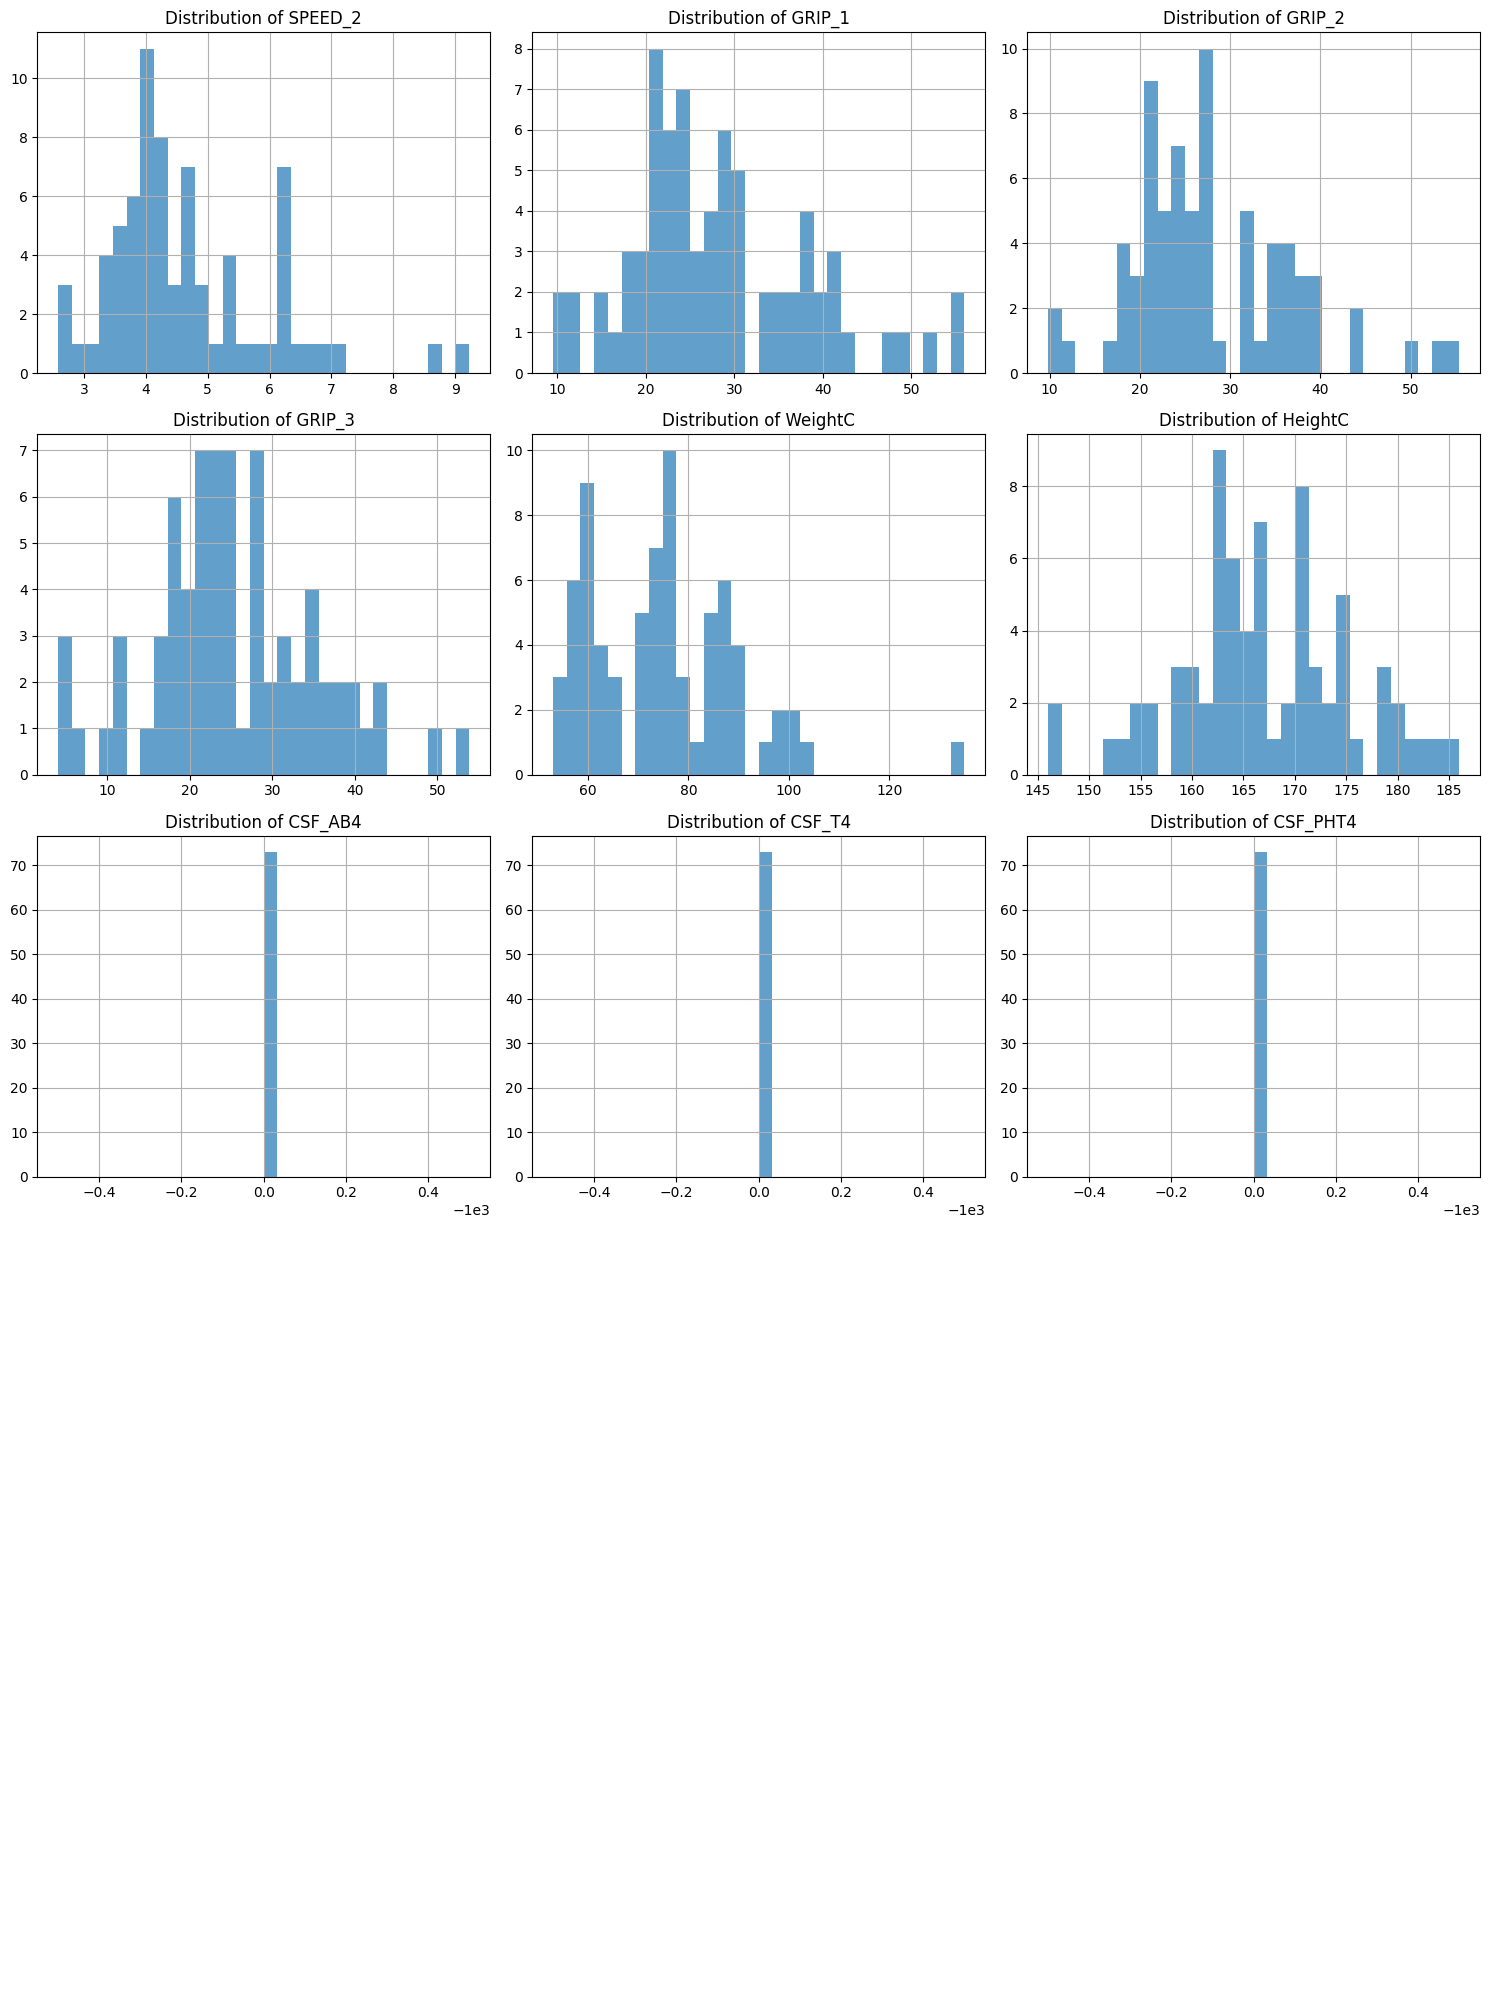

In [176]:
# Set the number of features per figure to 13
features_per_plot = 13
num_features = train_df.shape[1]
num_chunks = (num_features // features_per_plot) + 1

# Loop through features in chunks
for chunk in range(num_chunks):
    fig, axes = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows and 3 columns for 13 plots (1 will be empty)
    axes = axes.ravel()

    start_idx = chunk * features_per_plot
    end_idx = min((chunk + 1) * features_per_plot, num_features)

    for i, feature in enumerate(train_df.columns[start_idx:end_idx]):
        train_df[feature].hist(ax=axes[i], bins=30, alpha=0.7)
        axes[i].set_title(f'Distribution of {feature}')
    
    # Hide any extra axes
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

In [177]:
# Loop through all numerical columns to compare distributions using KS test for the training data
for column in train_df.columns:
    if train_df[column].dtype in ['float64', 'int64']:  # Apply only to numerical columns
        # Drop missing values from the original dataset
        original_data = train_df_copy[column].dropna()
        # Select only the imputed values (rows where original data had NaNs)
        imputed_data = train_df[column][train_df_copy[column].isna()]  

        if len(original_data) > 0 and len(imputed_data) > 0:  # Ensure both datasets are not empty
            # Perform the KS test
            ks_stat, ks_p_value = ks_2samp(original_data, imputed_data)
            print(f"KS test for {column}: stat={ks_stat}, p-value={ks_p_value}")
        else:
            print(f"Not enough data for column: {column}")


Not enough data for column: ID
Not enough data for column: SEX
Not enough data for column: EDU
Not enough data for column: AgeC
KS test for ΜaritalC: stat=0.8194444444444444, p-value=0.38356164383561653
KS test for Living_Arrangement: stat=0.2535211267605634, p-value=1.0
KS test for WorkStat: stat=0.14788732394366197, p-value=1.0
Not enough data for column: MH1
Not enough data for column: MH2
Not enough data for column: MH3
Not enough data for column: MH4
Not enough data for column: MH5
Not enough data for column: MH6
Not enough data for column: MH7
Not enough data for column: MH8
Not enough data for column: MH9
Not enough data for column: MH10
Not enough data for column: MH11
Not enough data for column: MH12
Not enough data for column: MH13
Not enough data for column: MH14
Not enough data for column: MH15
Not enough data for column: MH16
Not enough data for column: MH17
Not enough data for column: MH18
Not enough data for column: MH19
Not enough data for column: MH20
Not enough data f

In [178]:
# Loop through all numerical columns to compare distributions using KS test for the test data
for column in test_df.columns:
    if test_df[column].dtype in ['float64', 'int64']:  # Apply only to numerical columns
        # Drop missing values from the original dataset
        original_data = test_df_copy[column].dropna()
        # Select only the imputed values (rows where original data had NaNs)
        imputed_data = test_df[column][test_df_copy[column].isna()]  

        if len(original_data) > 0 and len(imputed_data) > 0:  # Ensure both datasets are not empty
            # Perform the KS test
            ks_stat, ks_p_value = ks_2samp(original_data, imputed_data)
            print(f"KS test for {column}: stat={ks_stat}, p-value={ks_p_value}")
        else:
            print(f"Not enough data for column: {column}")


Not enough data for column: ID
Not enough data for column: SEX
Not enough data for column: EDU
Not enough data for column: AgeC
KS test for ΜaritalC: stat=0.8823529411764706, p-value=0.3333333333333333
KS test for Living_Arrangement: stat=0.8235294117647058, p-value=0.4444444444444444
KS test for WorkStat: stat=0.5882352941176471, p-value=0.8888888888888888
Not enough data for column: MH1
Not enough data for column: MH2
Not enough data for column: MH3
Not enough data for column: MH4
Not enough data for column: MH5
Not enough data for column: MH6
Not enough data for column: MH7
Not enough data for column: MH8
Not enough data for column: MH9
Not enough data for column: MH10
Not enough data for column: MH11
Not enough data for column: MH12
Not enough data for column: MH13
Not enough data for column: MH14
Not enough data for column: MH15
Not enough data for column: MH16
Not enough data for column: MH17
Not enough data for column: MH18
Not enough data for column: MH19
Not enough data for co

In [179]:
# Save train_df_copy and test_df_copy to csv
train_df_copy.to_csv('../data/train_df_NON_imputed_3rdvisit.csv', index=False)
test_df_copy.to_csv('../data/test_df_NON_imputed_3rdvisit.csv', index=False)